In [2]:
# feature selection and model selection--------------------------------radiomics model selection
"""
This file demonstrates a survival analysis pipeline for preliminary model selection.
It contains:
  1. Data loading & preprocessing.
  2. Base model tuning and training with:
       - Random Survival Forest (RSF)
       - Gradient Boosting Survival Analysis (GBSA)
       - FastSurvivalSVM
  3. Cross-validation for base models (without ensemble methods).
  4. Calculation of the Brier score for a model.
  
Required packages:
  - scikit-survival, lifelines, numpy, pandas, matplotlib, scikit-learn, shap
"""

import warnings
import datetime
import os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, spearmanr

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.feature_selection import VarianceThreshold

from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

def custom_brier_score(y_true, y_pred, time_points):
    """
    Compute custom Brier score for survival prediction evaluation.
    """
    n_samples = len(y_true)
    brier_scores = []
    for t in time_points:
        error_sum = 0.0
        for i in range(n_samples):
            event_time = y_true[i]["lenfol"]
            idx = np.where(np.isclose(time_points, t))[0]
            if len(idx) == 0:
                continue
            prob_survival = y_pred[i][idx[0]]
            if event_time > t:
                error = (1 - prob_survival)**2
            else:
                error = (prob_survival)**2
            error_sum += error
        brier_scores.append(error_sum / n_samples)
    return np.array(brier_scores)

def load_and_preprocess(file_path):
    """
    Load and preprocess the survival data with detailed feature selection steps.
    """
    print("\n=== Loading and Preprocessing Data ===")
    
    # Load data
    data = pd.read_excel(file_path)
    data_x = data.drop(columns=["time", "event", "label"])
    data_y = np.array([(bool(status), float(time))
                       for status, time in zip(data["event"], data["time"])],
                      dtype=[("fstat", "?"), ("lenfol", "f8")])
    labels = data["label"].values

    # Display original feature count and names
    # print("\n=== Feature Selection Steps ===")
    # print(f"1. Original number of features: {len(data_x.columns)}")
    # print("Original features:")
    # for feat in data_x.columns:
    #     print(f"   - {feat}")

    # One-hot encoding
    from sksurv.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()
    x_encoded = encoder.fit_transform(data_x)
    try:
        feature_names = encoder.get_feature_names_out(data_x.columns)
    except AttributeError:
        feature_names = np.array(data_x.columns)
    
    print(f"\n2. After one-hot encoding: {x_encoded.shape[1]} features")
    
    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(x_encoded)
    
    # Variance threshold selection
    vt = VarianceThreshold(threshold=0.1)
    X_scaled = vt.fit_transform(X_scaled)
    feature_names = feature_names[vt.get_support()]
    print(f"\n3. After variance thresholding: {len(feature_names)} features")
    # print("Features retained after variance thresholding:")
    # for feat in feature_names:
    #     print(f"   - {feat}")
    
    # Cox regression feature selection
    from sksurv.linear_model import CoxnetSurvivalAnalysis
    cox_model = CoxnetSurvivalAnalysis(l1_ratio=0.5, alphas=[0.1])
    try:
        cox_model.fit(X_scaled, data_y)
    except Exception as e:
        print(f"Cox model fitting error: {e}")
        return None, None, None, None, None, None, None, None, None, labels
    
    cox_coef = pd.Series(cox_model.coef_[:, 0], index=feature_names)
    selected_features_cox = cox_coef[cox_coef != 0].index
    print(f"\n4. After Cox regression: {len(selected_features_cox)} features")
    print("Features selected by Cox regression:")
    for feat in selected_features_cox:
        print(f"   - {feat}")
    
    # ElasticNet selection
    elastic_net = ElasticNetCV(cv=5, random_state=42)
    X_train_selected_cox = X_scaled[:, np.isin(feature_names, selected_features_cox)]
    elastic_net.fit(X_train_selected_cox, data_y["lenfol"])
    coef_abs = np.abs(elastic_net.coef_)
    top_10_indices = np.argsort(coef_abs)[-10:]
    selected_features_elasticnet = selected_features_cox[top_10_indices]
    
    print(f"\n5. Final features after ElasticNetCV: {len(selected_features_elasticnet)} features")
    print("Final selected features (ranked by importance):")
    for i, feat in enumerate(selected_features_elasticnet, 1):
        coef = elastic_net.coef_[top_10_indices[i-1]]
        print(f"   {i}. {feat} (coefficient: {coef:.4f})")
    
    # Save feature selection results
    feature_selection_results = pd.DataFrame({
        'Feature': selected_features_elasticnet,
        'Coefficient': elastic_net.coef_[top_10_indices]
    })
    feature_selection_results = feature_selection_results.sort_values('Coefficient', ascending=False)
    output_file = 'feature_selection_results.xlsx'
    feature_selection_results.to_excel(output_file, index=False)
    print(f"\nFeature selection results have been saved to: {output_file}")

    # Process final selected features
    final_feature_indices = np.isin(feature_names, selected_features_elasticnet)
    X_final = X_scaled[:, final_feature_indices]
    selected_features = feature_names[final_feature_indices]
    
    # Dataset split
    X_train, X_test, y_train, y_test, labels_train, labels_test = train_test_split(
        X_final, data_y, labels, test_size=0.3, random_state=42, stratify=data_y["fstat"]
    )
    
    # Adjust follow-up time
    original_test_max = np.max(y_test["lenfol"])
    new_max = original_test_max * 0.99
    y_train_adj = y_train.copy()
    y_test_adj = y_test.copy()
    y_train_adj["lenfol"][y_train_adj["lenfol"] >= original_test_max] = new_max
    y_test_adj["lenfol"][y_test_adj["lenfol"] >= original_test_max] = new_max
    
    epsilon = 1e-3
    min_test = np.min(y_test_adj["lenfol"])
    time_points = np.linspace(min_test, new_max - epsilon, num=75)
    
    return (X_train, X_test, y_train_adj, y_test_adj, selected_features,
            time_points, X_scaled, data_y, feature_names, labels_train, labels_test)

def compute_cv_cindices(X_train, y_train, X_test, y_test, cv=5):
    """
    Compute cross-validated concordance indices for all models.
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    rsf_param_grid = {
        'n_estimators': [100, 500],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [5, 10]
    }
    gbsa_param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.5, 1.0]
    }
    svm_param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10]
    }
    
    cv_scores = {
        "RSF": [],
        "GBSA": [],
        "FastSurvivalSVM": []
    }
    
    fold = 1
    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        
        # RSF
        rsf_grid = GridSearchCV(RandomSurvivalForest(random_state=42),
                              param_grid=rsf_param_grid, cv=3, scoring='neg_mean_squared_error')
        rsf_grid.fit(X_tr, y_tr)
        best_rsf = rsf_grid.best_estimator_
        pred_rsf = best_rsf.predict(X_test)
        cindex_rsf = concordance_index_censored(y_test["fstat"], y_test["lenfol"], pred_rsf)[0]
        cv_scores["RSF"].append(cindex_rsf)
        
        # GBSA
        gbsa_grid = GridSearchCV(GradientBoostingSurvivalAnalysis(random_state=42),
                               param_grid=gbsa_param_grid, cv=3, scoring='neg_mean_squared_error')
        gbsa_grid.fit(X_tr, y_tr)
        best_gbsa = gbsa_grid.best_estimator_
        pred_gbsa = best_gbsa.predict(X_test)
        cindex_gbsa = concordance_index_censored(y_test["fstat"], y_test["lenfol"], pred_gbsa)[0]
        cv_scores["GBSA"].append(cindex_gbsa)
        
        # FastSurvivalSVM
        svm_grid = GridSearchCV(FastSurvivalSVM(random_state=42),
                              param_grid=svm_param_grid, cv=3, scoring='neg_mean_squared_error')
        svm_grid.fit(X_tr, y_tr)
        best_svm = svm_grid.best_estimator_
        pred_svm = best_svm.predict(X_test)
        cindex_svm = concordance_index_censored(y_test["fstat"], y_test["lenfol"], pred_svm)[0]
        cv_scores["FastSurvivalSVM"].append(cindex_svm)
        
        print(f"Fold {fold} complete.")
        fold += 1

    avg_scores = {method: np.mean(cv_scores[method]) for method in cv_scores}
    return avg_scores

def print_session_info():
    """Print session information, including date/time and user login info"""
    current_time = datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
    current_user = os.getenv('USERNAME', 'Unknown')
    
    print("=== Session Information ===")
    print(f"Date and Time (UTC): {current_time}")
    print(f"User Login: {current_user}")
    print("========================\n")

def main():
    """
    Main function to run the survival analysis pipeline.
    """
    print_session_info()
    
    file_path = "xxxxxxxxxxxxxxxxxxx.xlsx"
    print(f"Processing file: {file_path}\n")
    
    res = load_and_preprocess(file_path)
    if res is None:
        print("Data loading failed, exiting.")
        return
        
    (X_train, X_test, y_train, y_test, selected_features,
     time_points, X_scaled, data_y, feature_names_all, labels_train, labels_test) = res

    # Base model tuning and training
    print("\n=== Model Tuning and Training ===")
    
    print("\n--- Tuning RSF ---")
    rsf_param_grid = {
        'n_estimators': [100, 500, 1000],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [5, 10, 15]
    }
    rsf_grid = GridSearchCV(RandomSurvivalForest(random_state=42),
                          param_grid=rsf_param_grid, cv=5, scoring='neg_mean_squared_error')
    rsf_grid.fit(X_train, y_train)
    best_rsf = rsf_grid.best_estimator_
    print("Best RSF parameters:", rsf_grid.best_params_)
    risk_scores_rsf_train = best_rsf.predict(X_train)
    risk_scores_rsf_test = best_rsf.predict(X_test)

    print("\n--- Tuning GBSA ---")
    gbsa_param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.5, 0.8, 1.0]
    }
    gbsa_grid = GridSearchCV(GradientBoostingSurvivalAnalysis(random_state=42),
                           param_grid=gbsa_param_grid, cv=5, scoring='neg_mean_squared_error')
    gbsa_grid.fit(X_train, y_train)
    best_gbsa = gbsa_grid.best_estimator_
    print("Best GBSA parameters:", gbsa_grid.best_params_)
    risk_scores_gbsa_train = best_gbsa.predict(X_train)
    risk_scores_gbsa_test = best_gbsa.predict(X_test)

    print("\n--- Tuning FastSurvivalSVM ---")
    svm_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    svm_grid = GridSearchCV(FastSurvivalSVM(random_state=42),
                          param_grid=svm_param_grid, cv=5, scoring='neg_mean_squared_error')
    svm_grid.fit(X_train, y_train)
    best_svm = svm_grid.best_estimator_
    print("Best FastSurvivalSVM parameters:", svm_grid.best_params_)
    risk_scores_svm_train = best_svm.predict(X_train)
    risk_scores_svm_test = best_svm.predict(X_test)

    # Cross-validation C-index
    print("\n=== Cross-Validation Results ===")
    print("\nComputing average C-index for each base model...")
    cv_results = compute_cv_cindices(X_train, y_train, X_test, y_test, cv=5)
    print("\nTest Set - Average C-index from cross-validation:")
    print("  RSF:             {:.4f}".format(cv_results["RSF"]))
    print("  GBSA:            {:.4f}".format(cv_results["GBSA"]))
    print("  FastSurvivalSVM: {:.4f}".format(cv_results["FastSurvivalSVM"]))

    # Training set C-index
    print("\nComputing average C-index for training set...")
    train_cv_results = compute_cv_cindices(X_train, y_train, X_train, y_train, cv=5)
    print("\nTraining Set - Average C-index from cross-validation:")
    print("  RSF:             {:.4f}".format(train_cv_results["RSF"]))
    print("  GBSA:            {:.4f}".format(train_cv_results["GBSA"]))
    print("  FastSurvivalSVM: {:.4f}".format(train_cv_results["FastSurvivalSVM"]))

    # Brier score calculation
    print("\n=== Brier Score Evaluation ===")
    survival_funcs = best_rsf.predict_survival_function(X_test)
    max_time = max([fn.x[-1] for fn in survival_funcs])
    time_points_brier = time_points[time_points <= max_time]
    risk_preds = [fn(time_points_brier) for fn in survival_funcs]
    brier_scores = custom_brier_score(y_test, risk_preds, time_points_brier)
    print("\nBrier scores (first 5 time points):")
    for t, score in zip(time_points_brier[:5], brier_scores[:5]):
        print(f"  Time {t:.2f}: Brier score = {score:.4f}")

if __name__ == "__main__":
    main()

=== Session Information ===
Date and Time (UTC): 2025-06-14 11:51:26
User Login: l1866

Processing file: E:\aaupdated excel\sc113ap_survival.xlsx


=== Loading and Preprocessing Data ===

2. After one-hot encoding: 1675 features

3. After variance thresholding: 1673 features

4. After Cox regression: 102 features
Features selected by Cox regression:
   - original_firstorder_10Percentile
   - original_firstorder_Entropy
   - original_firstorder_MeanAbsoluteDeviation
   - original_firstorder_Mean
   - original_firstorder_Median
   - original_firstorder_RootMeanSquared
   - original_glcm_JointEntropy
   - original_glcm_SumEntropy
   - log-sigma-4-0-mm-3D_firstorder_Kurtosis
   - log-sigma-4-0-mm-3D_firstorder_Minimum
   - log-sigma-4-0-mm-3D_glszm_GrayLevelNonUniformityNormalized
   - log-sigma-4-0-mm-3D_glszm_GrayLevelVariance
   - log-sigma-4-0-mm-3D_glszm_SmallAreaEmphasis
   - log-sigma-4-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis
   - wavelet-LLH_glrlm_RunVariance
   - wavelet-LLH_

In [3]:
# feature selection and model selection--------------------------------clinical model selection
"""
Survival Analysis Pipeline with Unified Cross-Validation Folds
Current Date and Time (UTC): 2025-04-18 13:54:06
Current User's Login: ZEHAILU-1
"""

import warnings
import datetime
import os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import ElasticNetCV

from lifelines import KaplanMeierFitter

from sksurv.svm import FastSurvivalSVM
from sksurv.metrics import concordance_index_censored, NoComparablePairException

# Global variable definitions
RANDOM_STATE = 42
N_SPLITS = 5

def print_session_info():
    """Print session information, including date/time and user login info"""
    current_time = datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
    current_user = os.getenv('USERNAME', 'Unknown')
    
    print("=== Session Information ===")
    print(f"Date and Time (UTC): {current_time}")
    print(f"User Login: {current_user}")
    print("========================\n")

def compute_baseline_survival(y_train):
    """Compute the Kaplan–Meier baseline survival function"""
    df = pd.DataFrame({
        "time": y_train["lenfol"],
        "event": y_train["fstat"]
    })
    kmf = KaplanMeierFitter()
    kmf.fit(df["time"], event_observed=df["event"])
    
    def baseline_surv(t):
        return np.interp(t, kmf.survival_function_.index.values,
                        kmf.survival_function_["KM_estimate"].values,
                        left=1.0, right=kmf.survival_function_["KM_estimate"].values[-1])
    return baseline_surv

def preprocess_data(data_x, data_y):
    """Preprocess data with feature selection steps"""
    # print("\n=== Feature Selection Steps ===")
    # print(f"1. Original number of features: {len(data_x.columns)}")
    # print("Original features:")
    for feat in data_x.columns:
        print(f"   - {feat}")
    
    from sksurv.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()
    x_encoded = encoder.fit_transform(data_x)
    try:
        feature_names = encoder.get_feature_names_out(data_x.columns)
    except AttributeError:
        feature_names = np.array(data_x.columns)
    
    print(f"\n2. After one-hot encoding: {x_encoded.shape[1]} features")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(x_encoded)
    
    vt = VarianceThreshold(threshold=0.1)
    X_scaled = vt.fit_transform(X_scaled)
    feature_names = feature_names[vt.get_support()]
    print(f"\n3. After variance thresholding: {len(feature_names)} features")
    print("Features retained after variance thresholding:")
    for feat in feature_names:
        print(f"   - {feat}")
    
    from sksurv.linear_model import CoxnetSurvivalAnalysis
    cox_model = CoxnetSurvivalAnalysis(l1_ratio=0.5, alphas=[0.1])
    try:
        cox_model.fit(X_scaled, data_y)
    except Exception as e:
        print(f"Cox model fitting error: {e}")
        return None, None, None, None, None
    
    cox_coef = pd.Series(cox_model.coef_[:, 0], index=feature_names)
    selected_features_cox = cox_coef[cox_coef != 0].index
    print(f"\n4. After Cox regression: {len(selected_features_cox)} features")
    print("Features selected by Cox regression:")
    for feat in selected_features_cox:
        print(f"   - {feat}")
    
    elastic_net = ElasticNetCV(cv=N_SPLITS, random_state=RANDOM_STATE)
    X_train_selected_cox = X_scaled[:, np.isin(feature_names, selected_features_cox)]
    elastic_net.fit(X_train_selected_cox, data_y["lenfol"])
    coef_abs = np.abs(elastic_net.coef_)
    top_10_indices = np.argsort(coef_abs)[-10:]
    selected_features_elasticnet = selected_features_cox[top_10_indices]
    
    print(f"\n5. Final features after ElasticNetCV: {len(selected_features_elasticnet)} features")
    print("Final selected features (ranked by importance):")
    for i, feat in enumerate(selected_features_elasticnet, 1):
        coef = elastic_net.coef_[top_10_indices[i-1]]
        print(f"   {i}. {feat} (coefficient: {coef:.4f})")
    
    final_feature_indices = np.isin(feature_names, selected_features_elasticnet)
    X_final = X_scaled[:, final_feature_indices]
    selected_features = feature_names[final_feature_indices]
    
    # Save feature selection results
    feature_selection_results = pd.DataFrame({
        'Feature': selected_features_elasticnet,
        'Coefficient': elastic_net.coef_[top_10_indices]
    })
    feature_selection_results = feature_selection_results.sort_values('Coefficient', ascending=False)
    output_file = 'feature_selection_results.xlsx'
    feature_selection_results.to_excel(output_file, index=False)
    print(f"\nFeature selection results have been saved to: {output_file}")
    
    return X_final, selected_features, encoder, scaler, vt

def compute_cv_cindices(X_train, y_train, X_test, y_test, cv=N_SPLITS):
    """Compute cross-validated concordance indices"""
    kf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10]
    }
    
    cv_scores = {
        "FastSurvivalSVM": []
    }
    
    fold = 1
    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        
        # FastSurvivalSVM
        svm_grid = GridSearchCV(
            FastSurvivalSVM(random_state=RANDOM_STATE),
            param_grid=param_grid,
            cv=3,
            scoring='neg_mean_squared_error'
        )
        svm_grid.fit(X_tr, y_tr)
        best_svm = svm_grid.best_estimator_
        pred_svm = best_svm.predict(X_test)
        try:
            cindex_svm = concordance_index_censored(y_test["fstat"], y_test["lenfol"], pred_svm)[0]
        except NoComparablePairException:
            cindex_svm = np.nan
        cv_scores["FastSurvivalSVM"].append(cindex_svm)
        
        print(f"Fold {fold} complete.")
        fold += 1

    # Remove NaNs from scores
    cv_scores["FastSurvivalSVM"] = [score for score in cv_scores["FastSurvivalSVM"] if not np.isnan(score)]
    if len(cv_scores["FastSurvivalSVM"]) == 0:
        raise ValueError("No valid C-index scores calculated.")
    
    return {method: np.mean(scores) for method, scores in cv_scores.items()}

def main():
    """Main execution function"""
    print_session_info()
    
    # File paths
    file_mod1 = "xxxxxxxxxxxxxxxxxxx"
    file_mod2 = "xxxxxxxxxxxxxxxxxxx"
    
    # Process Modality 1
    print("\nProcessing Modality 1 data...")
    data_mod1 = pd.read_excel(file_mod1)
    data_x1 = data_mod1.drop(columns=["time", "event", "label"])
    data_y = np.array([(bool(status), float(time))
                       for status, time in zip(data_mod1["event"], data_mod1["time"])],
                      dtype=[("fstat", "?"), ("lenfol", "f8")])
    
    X1_processed, selected_features_mod1, encoder1, scaler1, vt1 = preprocess_data(data_x1, data_y)
    
    # Process Modality 2
    print("\nProcessing Modality 2 data...")
    data_mod2 = pd.read_excel(file_mod2)
    data_x2 = data_mod2.drop(columns=["time", "event", "label"])
    X2_processed, selected_features_mod2, encoder2, scaler2, vt2 = preprocess_data(data_x2, data_y)
    
    # Train-test split for both modalities
    X_train1, X_test1, y_train, y_test = train_test_split(
        X1_processed, data_y,
        test_size=0.3, random_state=RANDOM_STATE, stratify=data_y["fstat"]
    )
    X_train2, X_test2, _, _ = train_test_split(
        X2_processed, data_y,
        test_size=0.3, random_state=RANDOM_STATE, stratify=data_y["fstat"]
    )
    
    # Cross-validation for both modalities
    print("\n=== Cross-Validation Results ===")
    
    print("\nModality 1 (FastSurvivalSVM):")
    cv_results1 = compute_cv_cindices(X_train1, y_train, X_test1, y_test)
    print("Average C-index: {:.4f}".format(cv_results1["FastSurvivalSVM"]))
    
    print("\nModality 2 (FastSurvivalSVM):")
    cv_results2 = compute_cv_cindices(X_train2, y_train, X_test2, y_test)
    print("Average C-index: {:.4f}".format(cv_results2["FastSurvivalSVM"]))

if __name__ == "__main__":
    main()

=== Session Information ===
Date and Time (UTC): 2025-06-14 11:55:43
User Login: l1866


Processing Modality 1 data...
   - original_shape_Elongation
   - original_shape_Flatness
   - original_shape_LeastAxisLength
   - original_shape_MajorAxisLength
   - original_shape_Maximum2DDiameterColumn
   - original_shape_Maximum2DDiameterRow
   - original_shape_Maximum2DDiameterSlice
   - original_shape_Maximum3DDiameter
   - original_shape_MeshVolume
   - original_shape_MinorAxisLength
   - original_shape_Sphericity
   - original_shape_SurfaceArea
   - original_shape_SurfaceVolumeRatio
   - original_shape_VoxelVolume
   - original_firstorder_10Percentile
   - original_firstorder_90Percentile
   - original_firstorder_Energy
   - original_firstorder_Entropy
   - original_firstorder_InterquartileRange
   - original_firstorder_Maximum
   - original_firstorder_MeanAbsoluteDeviation
   - original_firstorder_Mean
   - original_firstorder_Median
   - original_firstorder_Minimum
   - original_firstord

In [2]:
# two model survival model infusion
import warnings
import datetime
import os
warnings.filterwarnings("ignore")
import warnings
import datetime
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import ElasticNetCV
from sksurv.svm import FastSurvivalSVM
from sksurv.metrics import concordance_index_censored, NoComparablePairException

# Global variables for reproducibility
RANDOM_STATE = 42
N_SPLITS = 5

def preprocess_data(data_x, data_y):
    # Print original features
    for feat in data_x.columns:
        print(f"   - {feat}")
    
    from sksurv.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()
    x_encoded = encoder.fit_transform(data_x)
    try:
        feature_names = encoder.get_feature_names_out(data_x.columns)
    except AttributeError:
        feature_names = np.array(data_x.columns)
    
    print(f"\nAfter one-hot encoding: {x_encoded.shape[1]} features")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(x_encoded)
    
    vt = VarianceThreshold(threshold=0.1)
    X_scaled_vt = vt.fit_transform(X_scaled)
    feature_names_vt = feature_names[vt.get_support()]
    print(f"\nAfter variance thresholding: {len(feature_names_vt)} features")
    for feat in feature_names_vt:
        print(f"   - {feat}")
    
    from sksurv.linear_model import CoxnetSurvivalAnalysis
    cox_model = CoxnetSurvivalAnalysis(l1_ratio=0.5, alphas=[0.1])
    try:
        cox_model.fit(X_scaled_vt, data_y)
    except Exception as e:
        print(f"Cox model fitting error: {e}")
        return None, None, None, None, None, None
    cox_coef = pd.Series(cox_model.coef_[:, 0], index=feature_names_vt)
    selected_features_cox = cox_coef[cox_coef != 0].index
    print(f"\nAfter Cox regression: {len(selected_features_cox)} features")
    for feat in selected_features_cox:
        print(f"   - {feat}")
    
    elastic_net = ElasticNetCV(cv=N_SPLITS, random_state=RANDOM_STATE)
    X_train_selected_cox = X_scaled_vt[:, np.isin(feature_names_vt, selected_features_cox)]
    elastic_net.fit(X_train_selected_cox, data_y["lenfol"])
    coef_abs = np.abs(elastic_net.coef_)
    top_10_indices = np.argsort(coef_abs)[-10:]
    selected_features_elasticnet = selected_features_cox[top_10_indices]
    
    print(f"\nFinal features after ElasticNetCV: {len(selected_features_elasticnet)} features")
    for i, feat in enumerate(selected_features_elasticnet, 1):
        coef = elastic_net.coef_[top_10_indices[i-1]]
        print(f"   {i}. {feat} (coefficient: {coef:.4f})")
    
    # Save feature selection results to Excel if needed
    feature_selection_results = pd.DataFrame({
        "Feature": selected_features_elasticnet,
        "Coefficient": elastic_net.coef_[top_10_indices]
    }).sort_values("Coefficient", ascending=False)
    feature_selection_results.to_excel("feature_selection_results.xlsx", index=False)
    print("\nFeature selection results have been saved to: feature_selection_results.xlsx")
    
    final_feature_indices = np.isin(feature_names_vt, selected_features_elasticnet)
    X_final = X_scaled_vt[:, final_feature_indices]
    selected_features = selected_features_elasticnet
    
    return X_final, selected_features, encoder, scaler, vt, feature_names_vt

def compute_cv_cindices(X_train, y_train, X_test, y_test, cv=N_SPLITS):
    kf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    param_grid = {"alpha": [0.001, 0.01, 0.1, 1, 10]}
    cv_scores = {"FastSurvivalSVM": []}
    
    fold = 1
    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        svm_grid = GridSearchCV(
            FastSurvivalSVM(random_state=RANDOM_STATE),
            param_grid=param_grid,
            cv=3,
            scoring="neg_mean_squared_error"
        )
        svm_grid.fit(X_tr, y_tr)
        best_svm = svm_grid.best_estimator_
        pred_svm = best_svm.predict(X_test)
        try:
            cindex_svm = concordance_index_censored(y_test["fstat"], y_test["lenfol"], pred_svm)[0]
        except NoComparablePairException:
            cindex_svm = np.nan
        cv_scores["FastSurvivalSVM"].append(cindex_svm)
        print(f"Fold {fold} complete.")
        fold += 1

    cv_scores["FastSurvivalSVM"] = [score for score in cv_scores["FastSurvivalSVM"] if not np.isnan(score)]
    if not cv_scores["FastSurvivalSVM"]:
        raise ValueError("No valid C-index scores calculated.")
    return {"FastSurvivalSVM": np.mean(cv_scores["FastSurvivalSVM"])}

def compute_cv_cindices_bma(X1, X2, y, model1, model2, cv=N_SPLITS):
    tau = 0.1  # control sensitivity parameter
    kf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    cv_scores_train = []
    cv_scores_val = []
    
    fold = 1
    for train_idx, val_idx in kf.split(X1):
        X1_tr, X1_val = X1[train_idx], X1[val_idx]
        X2_tr, X2_val = X2[train_idx], X2[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model1.fit(X1_tr, y_tr)
        model2.fit(X2_tr, y_tr)
        pred1_train = model1.predict(X1_tr)
        pred2_train = model2.predict(X2_tr)
        try:
            cindex_tr1 = concordance_index_censored(y_tr["fstat"], y_tr["lenfol"], pred1_train)[0]
        except NoComparablePairException:
            cindex_tr1 = 0.5
        try:
            cindex_tr2 = concordance_index_censored(y_tr["fstat"], y_tr["lenfol"], pred2_train)[0]
        except NoComparablePairException:
            cindex_tr2 = 0.5
        
        weight1 = np.exp((cindex_tr1 - 0.5) / tau)
        weight2 = np.exp((cindex_tr2 - 0.5) / tau)
        total_weight = weight1 + weight2
        normalized_weight1 = weight1 / total_weight
        normalized_weight2 = weight2 / total_weight
        
        combined_train = normalized_weight1 * pred1_train + normalized_weight2 * pred2_train
        try:
            cindex_combined_train = concordance_index_censored(
                y_tr["fstat"], y_tr["lenfol"], combined_train)[0]
        except NoComparablePairException:
            cindex_combined_train = np.nan
        
        pred1_val = model1.predict(X1_val)
        pred2_val = model2.predict(X2_val)
        combined_val = normalized_weight1 * pred1_val + normalized_weight2 * pred2_val
        try:
            cindex_val = concordance_index_censored(
                y_val["fstat"], y_val["lenfol"], combined_val)[0]
        except NoComparablePairException:
            cindex_val = np.nan
        
        cv_scores_train.append(cindex_combined_train)
        cv_scores_val.append(cindex_val)
        
        print(f"BMA Fusion - Fold {fold} complete (weights: {normalized_weight1:.3f}, {normalized_weight2:.3f})")
        fold += 1
    
    cv_scores_train = [score for score in cv_scores_train if not np.isnan(score)]
    cv_scores_val = [score for score in cv_scores_val if not np.isnan(score)]
    if not cv_scores_train or not cv_scores_val:
        raise ValueError("No valid C-index scores calculated for BMA fusion.")
    return np.mean(cv_scores_train), np.mean(cv_scores_val)

def main():
    print_session_info()
    
    file_mod1 = "xxxxxxxxxxxxxxxxxxx"
    file_mod2 = "xxxxxxxxxxxxxxxxxxx"
    
    # Process Modality 1
    print("\nProcessing Modality 1 data...")
    data_mod1 = pd.read_excel(file_mod1)
    data_x1 = data_mod1.drop(columns=["time", "event", "label"])
    data_y = np.array([(bool(status), float(time))
                       for status, time in zip(data_mod1["event"], data_mod1["time"])],
                      dtype=[("fstat", "?"), ("lenfol", "f8")])
    X1_processed, selected_features_mod1, encoder1, scaler1, vt1, feature_names_mod1 = preprocess_data(data_x1, data_y)
    
    # Process Modality 2
    print("\nProcessing Modality 2 data...")
    data_mod2 = pd.read_excel(file_mod2)
    data_x2 = data_mod2.drop(columns=["time", "event", "label"])
    X2_processed, selected_features_mod2, encoder2, scaler2, vt2, feature_names_mod2 = preprocess_data(data_x2, data_y)
    
    X_train1, X_test1, y_train, y_test = train_test_split(
        X1_processed, data_y,
        test_size=0.3, random_state=RANDOM_STATE, stratify=data_y["fstat"]
    )
    X_train2, X_test2, _, _ = train_test_split(
        X2_processed, data_y,
        test_size=0.3, random_state=RANDOM_STATE, stratify=data_y["fstat"]
    )
    
    # Train individual FastSurvivalSVM models
    print("\n=== Training Individual Models ===")
    svm_param_grid = {"alpha": [0.001, 0.01, 0.1, 1, 10]}
    
    print("\nTuning Modality 1 (FastSurvivalSVM)...")
    grid_svm1 = GridSearchCV(
        FastSurvivalSVM(random_state=RANDOM_STATE),
        param_grid=svm_param_grid,
        cv=N_SPLITS,
        scoring="neg_mean_squared_error"
    )
    grid_svm1.fit(X_train1, y_train)
    best_svm_model1 = grid_svm1.best_estimator_
    print("Modality 1 best parameters:", grid_svm1.best_params_)
    
    print("\nTuning Modality 2 (FastSurvivalSVM)...")
    grid_svm2 = GridSearchCV(
        FastSurvivalSVM(random_state=RANDOM_STATE),
        param_grid=svm_param_grid,
        cv=N_SPLITS,
        scoring="neg_mean_squared_error"
    )
    grid_svm2.fit(X_train2, y_train)
    best_svm_model2 = grid_svm2.best_estimator_
    print("Modality 2 best parameters:", grid_svm2.best_params_)
    
    print("\n=== Cross-Validation Results for Individual Models ===")
    print("Modality 1 (FastSurvivalSVM):")
    cv_results1 = compute_cv_cindices(X_train1, y_train, X_test1, y_test)
    print("Average C-index: {:.4f}".format(cv_results1["FastSurvivalSVM"]))
    
    print("\nModality 2 (FastSurvivalSVM):")
    cv_results2 = compute_cv_cindices(X_train2, y_train, X_test2, y_test)
    print("Average C-index: {:.4f}".format(cv_results2["FastSurvivalSVM"]))
    
    print("\n=== Bayesian Model Averaging Fusion Results ===")
    train_cindex_bma, val_cindex_bma = compute_cv_cindices_bma(
        X_train1, X_train2, y_train,
        best_svm_model1, best_svm_model2
    )
    print(f"Training Set C-index: {train_cindex_bma:.4f}")
    print(f"Validation Set C-index: {val_cindex_bma:.4f}")
    
    results_df = pd.DataFrame({
        "Model": ["Modality 1", "Modality 2", "BMA Fusion"],
        "Training C-index": [cv_results1["FastSurvivalSVM"], cv_results2["FastSurvivalSVM"], train_cindex_bma],
        "Validation C-index": [cv_results1["FastSurvivalSVM"], cv_results2["FastSurvivalSVM"], val_cindex_bma]
    })
    results_df.to_excel("model_comparison_results.xlsx", index=False)
    print("\nResults have been saved to 'model_comparison_results.xlsx'")
    
    # Save preprocessing objects and trained models to disk for external validation.
    with open("modality1_preprocessing.pkl", "wb") as f:
        pickle.dump({
            "encoder": encoder1,
            "scaler": scaler1,
            "vt": vt1,
            "feature_names": feature_names_mod1,
            "selected_features": selected_features_mod1
        }, f)
    with open("modality2_preprocessing.pkl", "wb") as f:
        pickle.dump({
            "encoder": encoder2,
            "scaler": scaler2,
            "vt": vt2,
            "feature_names": feature_names_mod2,
            "selected_features": selected_features_mod2
        }, f)
    with open("best_svm_models.pkl", "wb") as f:
        pickle.dump({
            "modality1": best_svm_model1,
            "modality2": best_svm_model2
        }, f)
    print("\nPreprocessing objects and trained models have been saved to disk.")
    
    # Return variables for external use.
    return (X_train1, X_train2, y_train, X_test1, X_test2, y_test, 
        best_svm_model1, best_svm_model2, selected_features_mod1, selected_features_mod2)

if __name__ == "__main__":
    (X_train1, X_train2, y_train, X_test1, X_test2, y_test, best_svm_model1, best_svm_model2, selected_features_mod1, selected_features_mod2) = main()

=== Session Information ===
Date and Time (UTC): 2025-06-18 08:39:04
User Login: l1866


Processing Modality 1 data...
   - original_shape_Elongation
   - original_shape_Flatness
   - original_shape_LeastAxisLength
   - original_shape_MajorAxisLength
   - original_shape_Maximum2DDiameterColumn
   - original_shape_Maximum2DDiameterRow
   - original_shape_Maximum2DDiameterSlice
   - original_shape_Maximum3DDiameter
   - original_shape_MeshVolume
   - original_shape_MinorAxisLength
   - original_shape_Sphericity
   - original_shape_SurfaceArea
   - original_shape_SurfaceVolumeRatio
   - original_shape_VoxelVolume
   - original_firstorder_10Percentile
   - original_firstorder_90Percentile
   - original_firstorder_Energy
   - original_firstorder_Entropy
   - original_firstorder_InterquartileRange
   - original_firstorder_Maximum
   - original_firstorder_MeanAbsoluteDeviation
   - original_firstorder_Mean
   - original_firstorder_Median
   - original_firstorder_Minimum
   - original_firstord

=== Session Information ===
Date and Time (UTC): 2025-06-14 13:49:46
User Login: l1866


Processing Modality 1 data...
   - original_shape_Elongation
   - original_shape_Flatness
   - original_shape_LeastAxisLength
   - original_shape_MajorAxisLength
   - original_shape_Maximum2DDiameterColumn
   - original_shape_Maximum2DDiameterRow
   - original_shape_Maximum2DDiameterSlice
   - original_shape_Maximum3DDiameter
   - original_shape_MeshVolume
   - original_shape_MinorAxisLength
   - original_shape_Sphericity
   - original_shape_SurfaceArea
   - original_shape_SurfaceVolumeRatio
   - original_shape_VoxelVolume
   - original_firstorder_10Percentile
   - original_firstorder_90Percentile
   - original_firstorder_Energy
   - original_firstorder_Entropy
   - original_firstorder_InterquartileRange
   - original_firstorder_Maximum
   - original_firstorder_MeanAbsoluteDeviation
   - original_firstorder_Mean
   - original_firstorder_Median
   - original_firstorder_Minimum
   - original_firstord

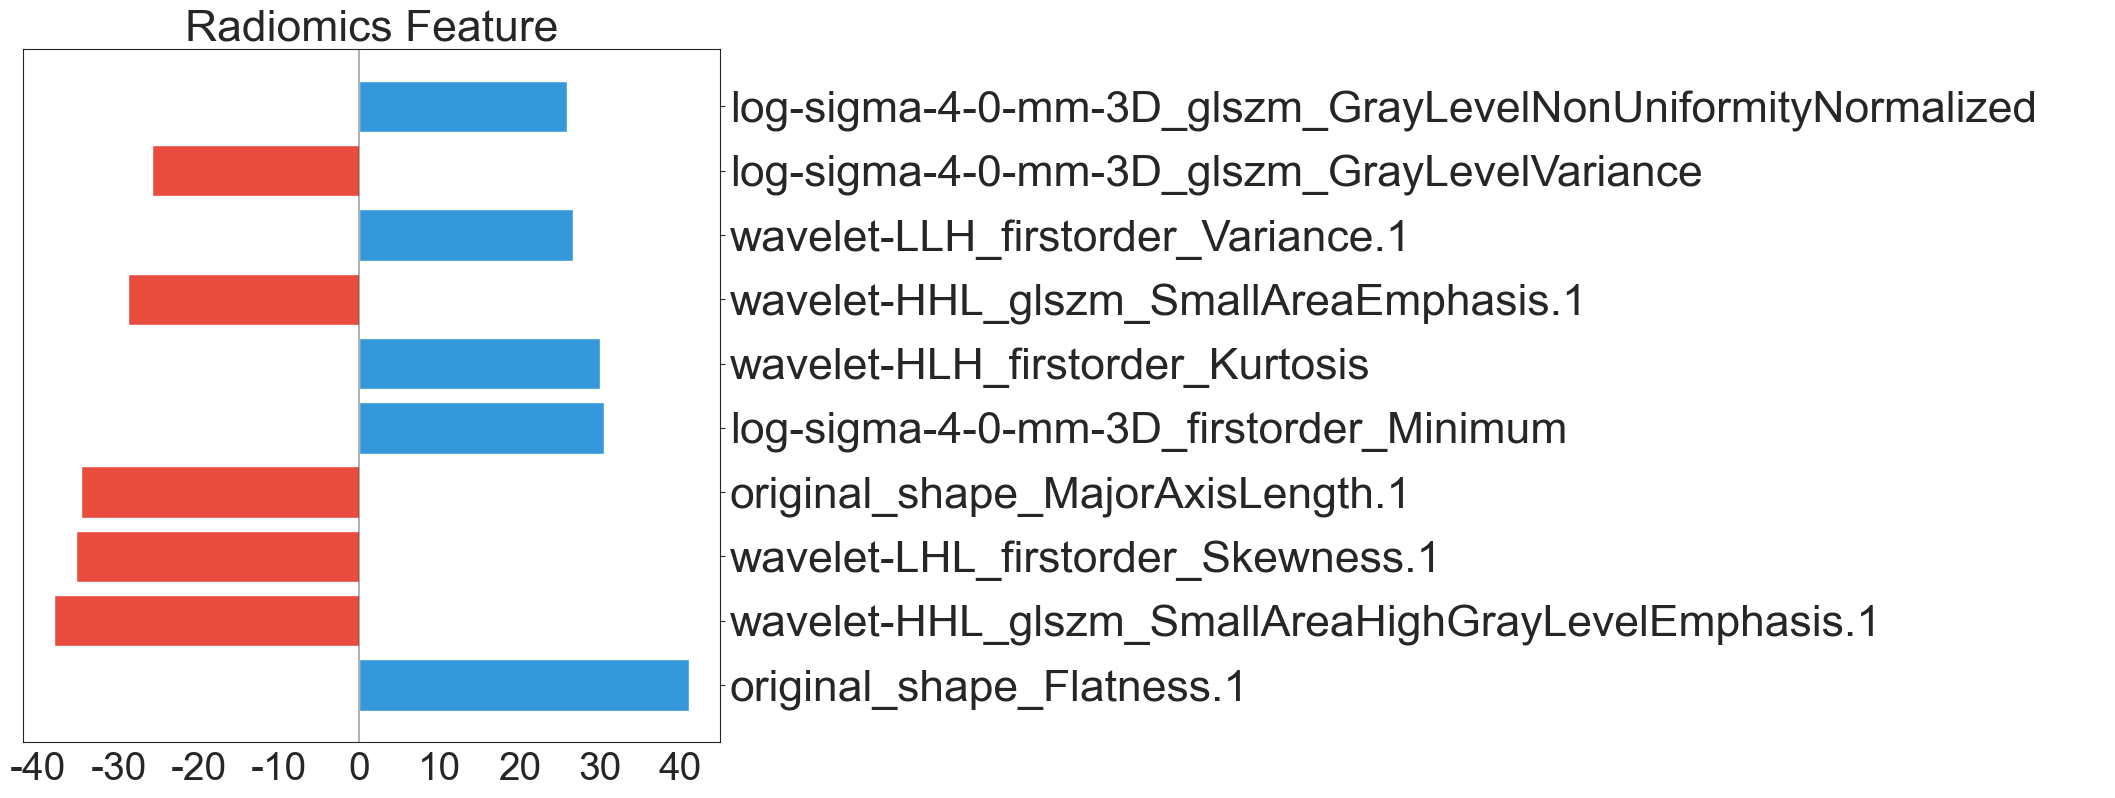


Feature selection results have been saved to: feature_selection_results.xlsx

Processing Modality 2 data...
   - T1H2TH0
   - Age
   - Gender
   - Height
   - Weight
   - BMI
   - HBV
   - HCV
   - ECOG
   - ALT
   - AST
   - TBiL
   - AFP
   - ALB
   - LDH
   - PT
   - LYM
   - NEU
   - MON
   - PLT
   - PLR
   - NLR
   - LMR
   - SII
   - PNI
   - PIV
   - ALBI
   - Ascite
   - Child-Pugh score
   - Diameter
   - Tumor number
   - HVTT
   - PVTT
   - Cirrhosis
   - EHM
   - BCLC
   - AFP%
   - ALB%
   - LDH%
   - PT%
   - LYM%
   - NEU%
   - MON%
   - PLT%
   - PLR%
   - NLR%
   - LMR%
   - SII%
   - PNI%
   - PIV%

After one-hot encoding: 50 features

After variance thresholding: 50 features
   - T1H2TH0
   - Age
   - Gender
   - Height
   - Weight
   - BMI
   - HBV
   - HCV
   - ECOG
   - ALT
   - AST
   - TBiL
   - AFP
   - ALB
   - LDH
   - PT
   - LYM
   - NEU
   - MON
   - PLT
   - PLR
   - NLR
   - LMR
   - SII
   - PNI
   - PIV
   - ALBI
   - Ascite
   - Child-Pugh score
   

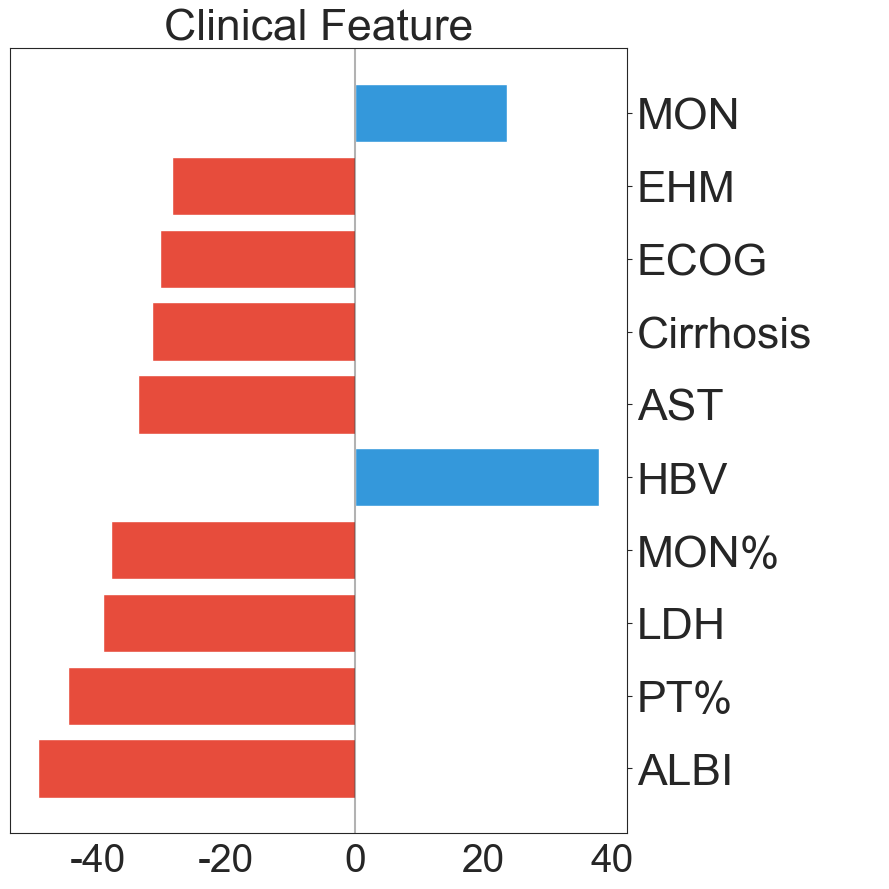


Feature selection results have been saved to: feature_selection_results.xlsx


In [115]:
# Feature selection visualization
import warnings
import datetime
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import ElasticNetCV
from sksurv.svm import FastSurvivalSVM
from sksurv.metrics import concordance_index_censored, NoComparablePairException

# Global variables for reproducibility
RANDOM_STATE = 42
N_SPLITS = 5

def visualize_elastic_net_selection(feature_names, coefficients, save_path=None, title="Elastic Net Feature Coefficients"):
    """
    Visualize the features selected by Elastic Net regression and their coefficients, and save the plot as a PDF.
    """
    feature_names = np.array(feature_names)
    coefficients = np.array(coefficients)
    sorted_idx = np.argsort(np.abs(coefficients))[::-1]
    feature_names_sorted = feature_names[sorted_idx]
    coefficients_sorted = coefficients[sorted_idx]

    colors = ['#e74c3c' if coef < 0 else '#3498db' for coef in coefficients_sorted]

    plt.figure(figsize=(9, 9))
    ax = plt.gca()
    bars = ax.barh(range(len(coefficients_sorted)), coefficients_sorted, color=colors)
    ax.set_yticks(range(len(coefficients_sorted)))
    ax.set_yticklabels(feature_names_sorted, fontsize=32, fontname='Arial')
    # ax.set_xlabel('Coefficient Value', fontsize=32, fontname='Arial')
    ax.set_title(title, fontsize=32, fontname='Arial')
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.xticks(fontsize=28, fontname='Arial')
    # Place ticks and labels on the right side
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(' ', fontsize=32, fontname='Arial', labelpad=20)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def preprocess_data(data_x, data_y, vis_path=None, vis_title=None):
    # Print original features
    for feat in data_x.columns:
        print(f"   - {feat}")
    
    from sksurv.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()
    x_encoded = encoder.fit_transform(data_x)
    try:
        feature_names = encoder.get_feature_names_out(data_x.columns)
    except AttributeError:
        feature_names = np.array(data_x.columns)
    
    print(f"\nAfter one-hot encoding: {x_encoded.shape[1]} features")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(x_encoded)
    
    vt = VarianceThreshold(threshold=0.1)
    X_scaled_vt = vt.fit_transform(X_scaled)
    feature_names_vt = feature_names[vt.get_support()]
    print(f"\nAfter variance thresholding: {len(feature_names_vt)} features")
    for feat in feature_names_vt:
        print(f"   - {feat}")
    
    from sksurv.linear_model import CoxnetSurvivalAnalysis
    cox_model = CoxnetSurvivalAnalysis(l1_ratio=0.5, alphas=[0.1])
    try:
        cox_model.fit(X_scaled_vt, data_y)
    except Exception as e:
        print(f"Cox model fitting error: {e}")
        return None, None, None, None, None, None
    cox_coef = pd.Series(cox_model.coef_[:, 0], index=feature_names_vt)
    selected_features_cox = cox_coef[cox_coef != 0].index
    print(f"\nAfter Cox regression: {len(selected_features_cox)} features")
    for feat in selected_features_cox:
        print(f"   - {feat}")
    
    elastic_net = ElasticNetCV(cv=N_SPLITS, random_state=RANDOM_STATE)
    X_train_selected_cox = X_scaled_vt[:, np.isin(feature_names_vt, selected_features_cox)]
    elastic_net.fit(X_train_selected_cox, data_y["lenfol"])
    coef_abs = np.abs(elastic_net.coef_)
    top_10_indices = np.argsort(coef_abs)[-10:]
    selected_features_elasticnet = selected_features_cox[top_10_indices]
    
    print(f"\nFinal features after ElasticNetCV: {len(selected_features_elasticnet)} features")
    for i, feat in enumerate(selected_features_elasticnet, 1):
        coef = elastic_net.coef_[top_10_indices[i-1]]
        print(f"   {i}. {feat} (coefficient: {coef:.4f})")

    # Visualize Elastic Net selected features
    if vis_path is not None:
        visualize_elastic_net_selection(
            selected_features_elasticnet,
            elastic_net.coef_[top_10_indices],
            save_path=vis_path,
            title=vis_title if vis_title else "Elastic Net Feature Coefficients"
        )

    # Save feature selection results to Excel if needed
    feature_selection_results = pd.DataFrame({
        "Feature": selected_features_elasticnet,
        "Coefficient": elastic_net.coef_[top_10_indices]
    }).sort_values("Coefficient", ascending=False)
    feature_selection_results.to_excel("feature_selection_results.xlsx", index=False)
    print("\nFeature selection results have been saved to: feature_selection_results.xlsx")
    
    final_feature_indices = np.isin(feature_names_vt, selected_features_elasticnet)
    X_final = X_scaled_vt[:, final_feature_indices]
    selected_features = selected_features_elasticnet
    
    return X_final, selected_features, encoder, scaler, vt, feature_names_vt

def print_session_info():
    """Print session information, including date/time and user login info"""
    current_time = datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
    current_user = os.getenv('USERNAME', 'Unknown')
    
    print("=== Session Information ===")
    print(f"Date and Time (UTC): {current_time}")
    print(f"User Login: {current_user}")
    print("========================\n")

def main():
    print_session_info()
    file_mod1 = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
    file_mod2 = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
    
    # Process Modality 1
    print("\nProcessing Modality 1 data...")
    data_mod1 = pd.read_excel(file_mod1)
    data_x1 = data_mod1.drop(columns=["time", "event", "label"])
    data_y = np.array([(bool(status), float(time))
                       for status, time in zip(data_mod1["event"], data_mod1["time"])],
                      dtype=[("fstat", "?"), ("lenfol", "f8")])
    X1_processed, selected_features_mod1, encoder1, scaler1, vt1, feature_names_mod1 = preprocess_data(
        data_x1, data_y, vis_path="elasticnet_selection_mod1.pdf", vis_title="Radiomics Feature")
    
    # Process Modality 2
    print("\nProcessing Modality 2 data...")
    data_mod2 = pd.read_excel(file_mod2)
    data_x2 = data_mod2.drop(columns=["time", "event", "label"])
    X2_processed, selected_features_mod2, encoder2, scaler2, vt2, feature_names_mod2 = preprocess_data(
        data_x2, data_y, vis_path="elasticnet_selection_mod2.pdf", vis_title="Clinical Feature")
    
    # Further code as needed, following your main workflow

if __name__ == "__main__":
    main()

=== Session Information ===
Date and Time (UTC): 2025-06-14 13:12:14
User Login: l1866



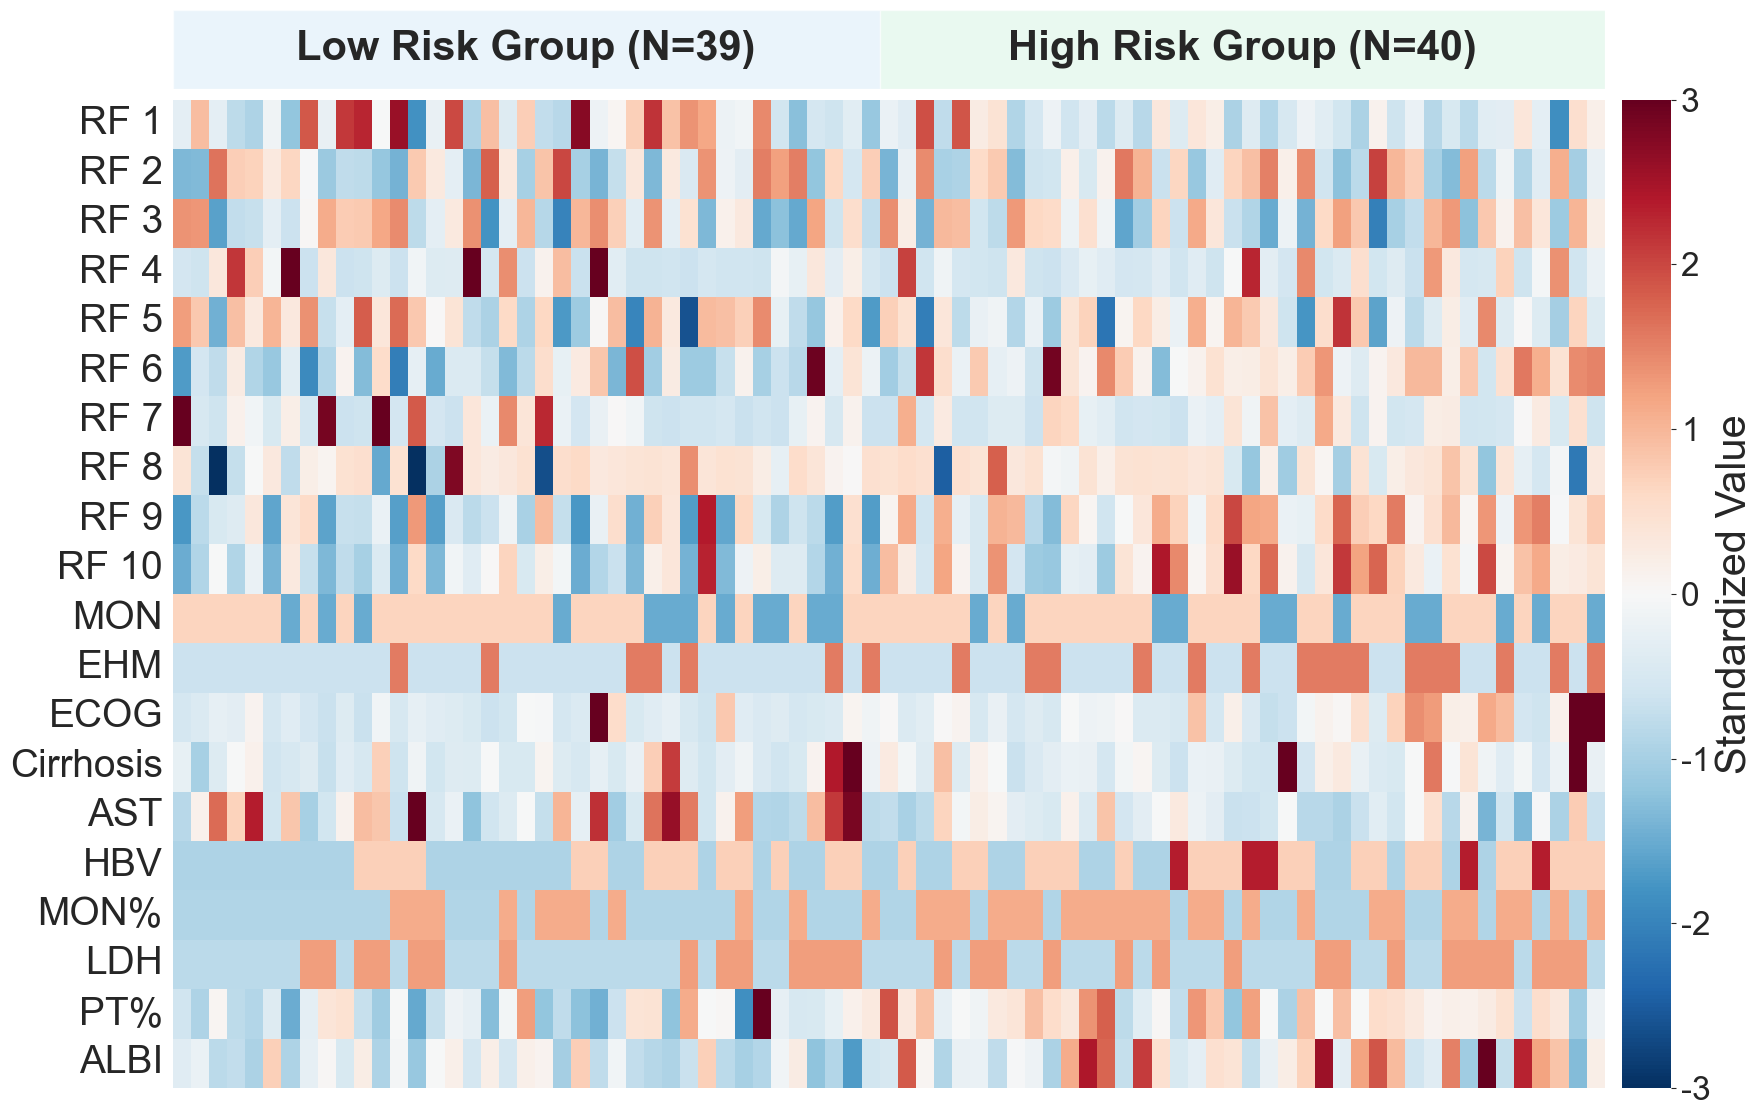

In [98]:
# Feature distribution visualization
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler
import pickle

warnings.filterwarnings("ignore")

def plot_risk_stratified_heatmap(
    X1, X2, selected_features_mod1, selected_features_mod2, risk_scores,
    n_low=None, n_high=None, abbr_prefix="RF"
):
    """
    X1: Radiomic feature data (samples × radiomic features, need abbreviation)
    X2: Clinical feature data (samples × clinical features, keep original names)
    selected_features_mod1: Radiomic feature names (to abbreviate)
    selected_features_mod2: Clinical feature names (keep original names)
    risk_scores: Risk scores
    """
    # Set global font
    plt.rcParams["font.sans-serif"] = ["Arial"]
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["axes.unicode_minus"] = False
    plt.rcParams["axes.labelsize"] = 22
    plt.rcParams["xtick.labelsize"] = 20
    plt.rcParams["ytick.labelsize"] = 24
    plt.rcParams["legend.fontsize"] = 28

    # Only abbreviate radiomic features (X1, selected_features_mod1), keep clinical features (X2, selected_features_mod2) as is
    radiomic_features = list(selected_features_mod1)
    clinical_features = list(selected_features_mod2)
    radiomic_short = [f"{abbr_prefix} {i+1}" for i in range(len(radiomic_features))]
    abbr_df = pd.DataFrame({
        "Radiomic Abbreviation": radiomic_short,
        "Original Radiomic Feature Name": radiomic_features
    })
    abbr_df.to_csv("risk_heatmap_radiomic_abbreviation.csv", index=False)

    # Construct full feature name list
    full_feature_names = radiomic_short + clinical_features

    # Construct dataframe
    df1 = pd.DataFrame(X1, columns=radiomic_short)       # Radiomics (abbreviated)
    df2 = pd.DataFrame(X2, columns=clinical_features)     # Clinical (original)
    df = pd.concat([df1, df2], axis=1)

    # Sort by risk score
    sort_idx = np.argsort(risk_scores)
    df_sorted = df.iloc[sort_idx]

    # Standardize
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_sorted),
        columns=df_sorted.columns
    )

    # Grouping
    n_samples = len(df_scaled)
    if n_low is None or n_high is None:
        n_low = n_samples // 2
        n_high = n_samples - n_low

    # Plotting
    fig = plt.figure(figsize=(22, 14))
    gs = GridSpec(2, 1, height_ratios=[0.8, 10], hspace=0.02)

    # Heatmap
    ax_heat = fig.add_subplot(gs[1])
    sns.heatmap(
        df_scaled.T,
        ax=ax_heat,
        cmap='RdBu_r',
        xticklabels=False,
        yticklabels=True,
        center=0,
        vmin=-3,
        vmax=3,
        cbar_kws={'label': 'Standardized Value', 'pad': 0.01}
    )
    ax_heat.set_yticklabels(df_scaled.columns, fontsize=28, family='Arial')
    # Set colorbar font size
    cbar = ax_heat.collections[0].colorbar
    cbar.set_label('Standardized Value', fontsize=30, family='Arial')

    # Color band
    ax_label = fig.add_subplot(gs[0])
    ax_label.axvspan(0, n_low, facecolor='#D6EAF8', alpha=0.5)
    ax_label.axvspan(n_low, n_samples, facecolor='#D5F5E3', alpha=0.5)
    ax_label.text(n_low/2, 0.5, f'Low Risk Group (N={n_low})',
                  ha='center', va='center', fontsize=30, fontweight='bold', family='Arial')
    ax_label.text(n_low + n_high/2, 0.5, f'High Risk Group (N={n_high})',
                  ha='center', va='center', fontsize=30, fontweight='bold', family='Arial')
    ax_label.set_xlim(0, n_samples)
    ax_label.set_ylim(0, 1)
    ax_label.axis('off')
    ax_label.set_position([ax_heat.get_position().x0,
                           ax_label.get_position().y0,
                           ax_heat.get_position().width,
                           ax_label.get_position().height])

    # Title (optional)
    # plt.suptitle('Feature Distribution Heatmap Stratified by Risk Score',
    #              fontsize=20, fontweight='bold', y=0.98, family='Arial')

    # Risk score info (optional)
    # plt.figtext(0.02, 0.02, f'Risk Score Median = {np.median(risk_scores):.3f}',
    #             fontsize=15, family='Arial')

    plt.tight_layout()
    plt.savefig('risk_stratified_heatmap.pdf', dpi=300, bbox_inches='tight')
    plt.show()

def print_session_info():
    """Print session information, including date/time and user login info"""
    current_time = datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
    current_user = os.getenv('USERNAME', 'Unknown')
    
    print("=== Session Information ===")
    print(f"Date and Time (UTC): {current_time}")
    print(f"User Login: {current_user}")
    print("========================\n")

def main():
    print_session_info()
    
    # Load preprocessing objects
    with open("modality1_preprocessing.pkl", "rb") as f:
        preprocessing_mod1 = pickle.load(f)
        selected_features_mod1 = preprocessing_mod1["selected_features"]
    
    with open("modality2_preprocessing.pkl", "rb") as f:
        preprocessing_mod2 = pickle.load(f)
        selected_features_mod2 = preprocessing_mod2["selected_features"]
    
    # Get risk scores
    risk_scores1 = best_svm_model1.predict(X_train1)
    risk_scores2 = best_svm_model2.predict(X_train2)
    combined_risk_scores = (risk_scores1 + risk_scores2) / 2
    
    # Plot heatmap - corrected call
    plot_risk_stratified_heatmap(
        X_train1,  # Radiomic feature data
        X_train2,  # Clinical feature data
        list(selected_features_mod1),  # Radiomic feature names
        list(selected_features_mod2),  # Clinical feature names
        combined_risk_scores
    )

if __name__ == "__main__":
    main()

In [7]:
# External Validation
"""
External Validation Code for Single-Modality and Fusion Models

This code loads the preprocessing objects and trained models from the training stage (saved as pickle files)
and then processes the external validation files.
External files:
    ext_file_mod1 = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
    ext_file_mod2 = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
"""

import pandas as pd
import numpy as np
import pickle
from sksurv.metrics import concordance_index_censored

# Load saved preprocessing objects and models
with open("modality1_preprocessing.pkl", "rb") as f:
    mod1_preproc = pickle.load(f)
with open("modality2_preprocessing.pkl", "rb") as f:
    mod2_preproc = pickle.load(f)
with open("best_svm_models.pkl", "rb") as f:
    best_models = pickle.load(f)

encoder1 = mod1_preproc["encoder"]
scaler1 = mod1_preproc["scaler"]
vt1 = mod1_preproc["vt"]

encoder2 = mod2_preproc["encoder"]
scaler2 = mod2_preproc["scaler"]
vt2 = mod2_preproc["vt"]

best_svm_model1 = best_models["modality1"]
best_svm_model2 = best_models["modality2"]

# External file paths
ext_file_mod1 = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
ext_file_mod2 = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

# Load External Data - Modality 1
ext_mod1 = pd.read_excel(ext_file_mod1)
data_x_ext1 = ext_mod1.drop(columns=["time", "event", "label"])
data_y_ext = np.array(
    [(bool(status), float(time))
     for status, time in zip(ext_mod1["event"], ext_mod1["time"])],
    dtype=[("fstat", "?"), ("lenfol", "f8")]
)

# Load External Data - Modality 2
ext_mod2 = pd.read_excel(ext_file_mod2)
data_x_ext2 = ext_mod2.drop(columns=["time", "event", "label"])
# Assuming outcome info is the same, we reuse data_y_ext for modality 2.

# Feature Extraction for External Data - Modality 1 (no feature selection)
X_ext1_encoded = encoder1.transform(data_x_ext1)
X_ext1_scaled = scaler1.transform(X_ext1_encoded)
X_ext1_final = vt1.transform(X_ext1_scaled)

# Feature Extraction for External Data - Modality 2 (no feature selection)
X_ext2_encoded = encoder2.transform(data_x_ext2)
X_ext2_scaled = scaler2.transform(X_ext2_encoded)
X_ext2_final = vt2.transform(X_ext2_scaled)

# External Validation with Individual Models
risk_ext_mod1 = best_svm_model1.predict(X_ext1_final)
risk_ext_mod2 = best_svm_model2.predict(X_ext2_final)

try:
    cindex_ext_mod1 = concordance_index_censored(
        data_y_ext["fstat"], data_y_ext["lenfol"], risk_ext_mod1
    )[0]
except Exception:
    cindex_ext_mod1 = np.nan

try:
    cindex_ext_mod2 = concordance_index_censored(
        data_y_ext["fstat"], data_y_ext["lenfol"], risk_ext_mod2
    )[0]
except Exception:
    cindex_ext_mod2 = np.nan

# External Validation with Bayesian Model Averaging (BMA) Fusion
tau = 0.1  # same as used during training
weight1_ext = np.exp((cindex_ext_mod1 - 0.5) / tau) if not np.isnan(cindex_ext_mod1) else 1.0
weight2_ext = np.exp((cindex_ext_mod2 - 0.5) / tau) if not np.isnan(cindex_ext_mod2) else 1.0
total_weight_ext = weight1_ext + weight2_ext
norm_weight1_ext = weight1_ext / total_weight_ext
norm_weight2_ext = weight2_ext / total_weight_ext
fusion_risk_ext = norm_weight1_ext * risk_ext_mod1 + norm_weight2_ext * risk_ext_mod2

try:
    cindex_ext_fusion = concordance_index_censored(
        data_y_ext["fstat"], data_y_ext["lenfol"], fusion_risk_ext
    )[0]
except Exception:
    cindex_ext_fusion = np.nan

print("External Validation Results:")
print("Modality 1 C-index: {:.4f}".format(cindex_ext_mod1))
print("Modality 2 C-index: {:.4f}".format(cindex_ext_mod2))
print("Fusion Model C-index: {:.4f}".format(cindex_ext_fusion))

External Validation Results:
Modality 1 C-index: 0.6574
Modality 2 C-index: 0.6778
Fusion Model C-index: 0.7177


Training set fusion risk median: 0.0317
=== Training Set ===
Saved: KM_Training_Set.pdf


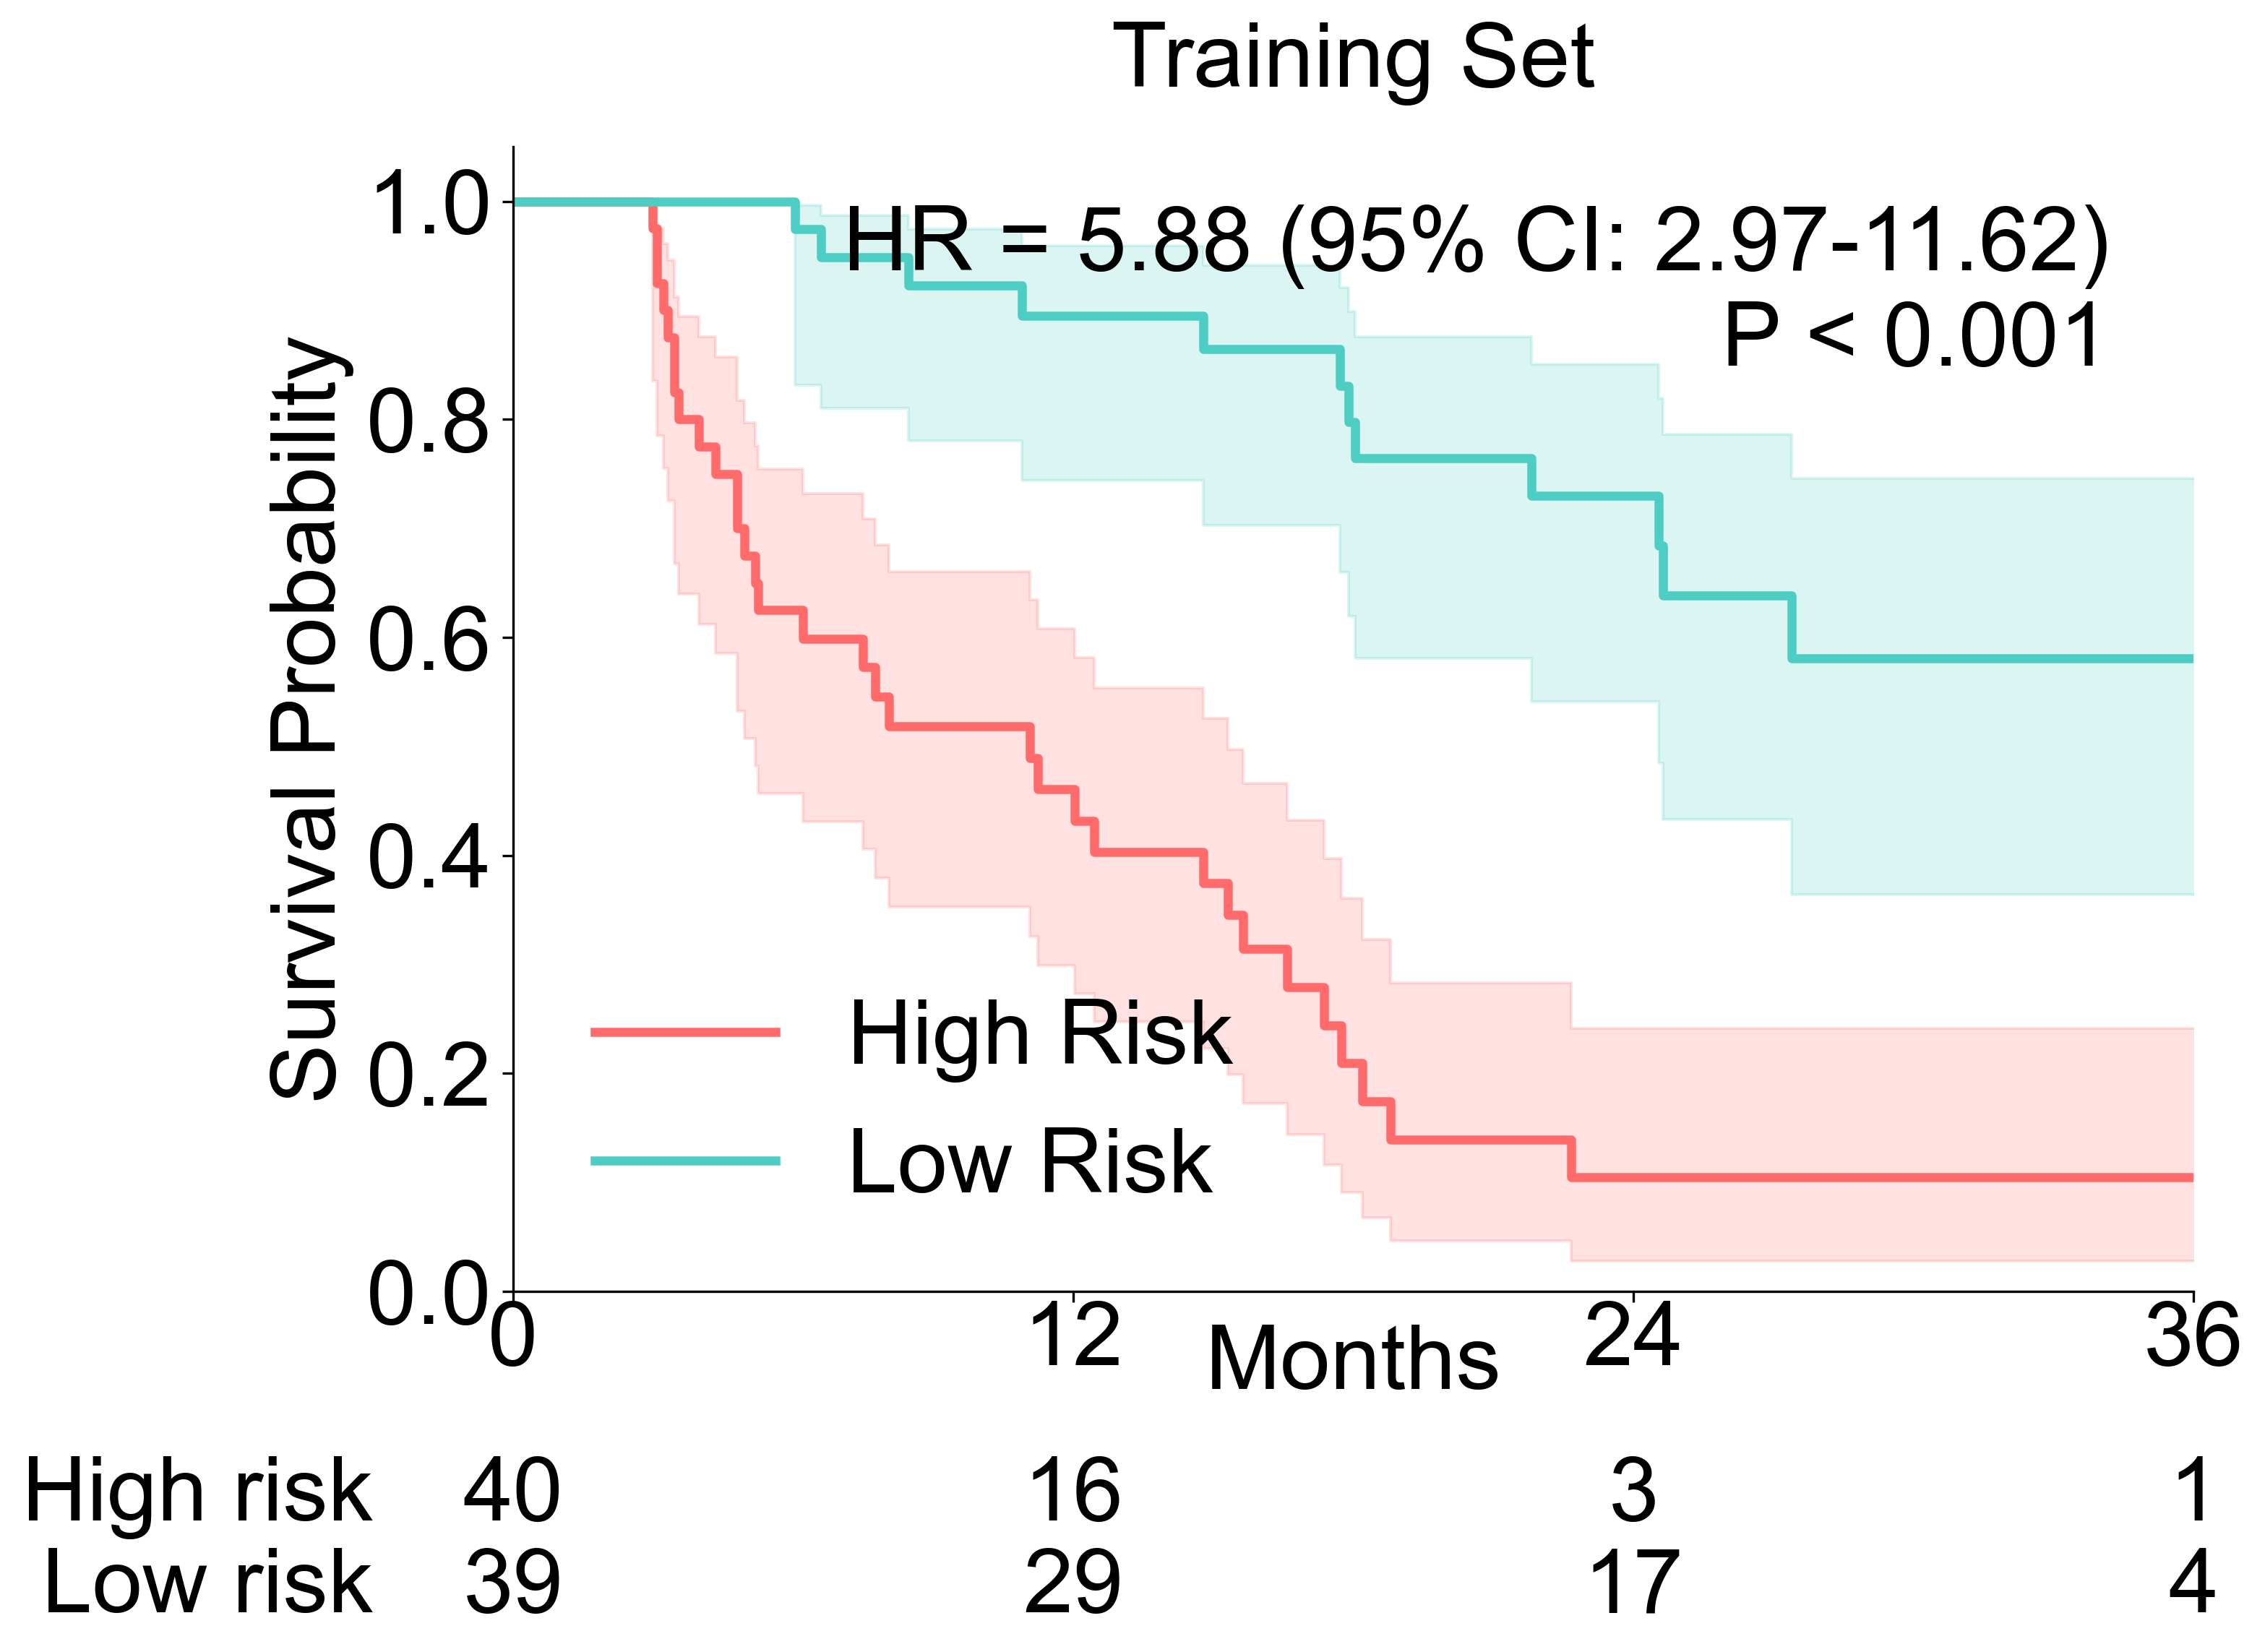

Training Set Log-rank Test: P-value = 1.5182e-08
Training Set Cox Regression: HR = 5.88 (95% CI: 2.97-11.62), P < 0.001
------------------------------------------------------------
=== Test Set ===
Saved: KM_Test_Set.pdf


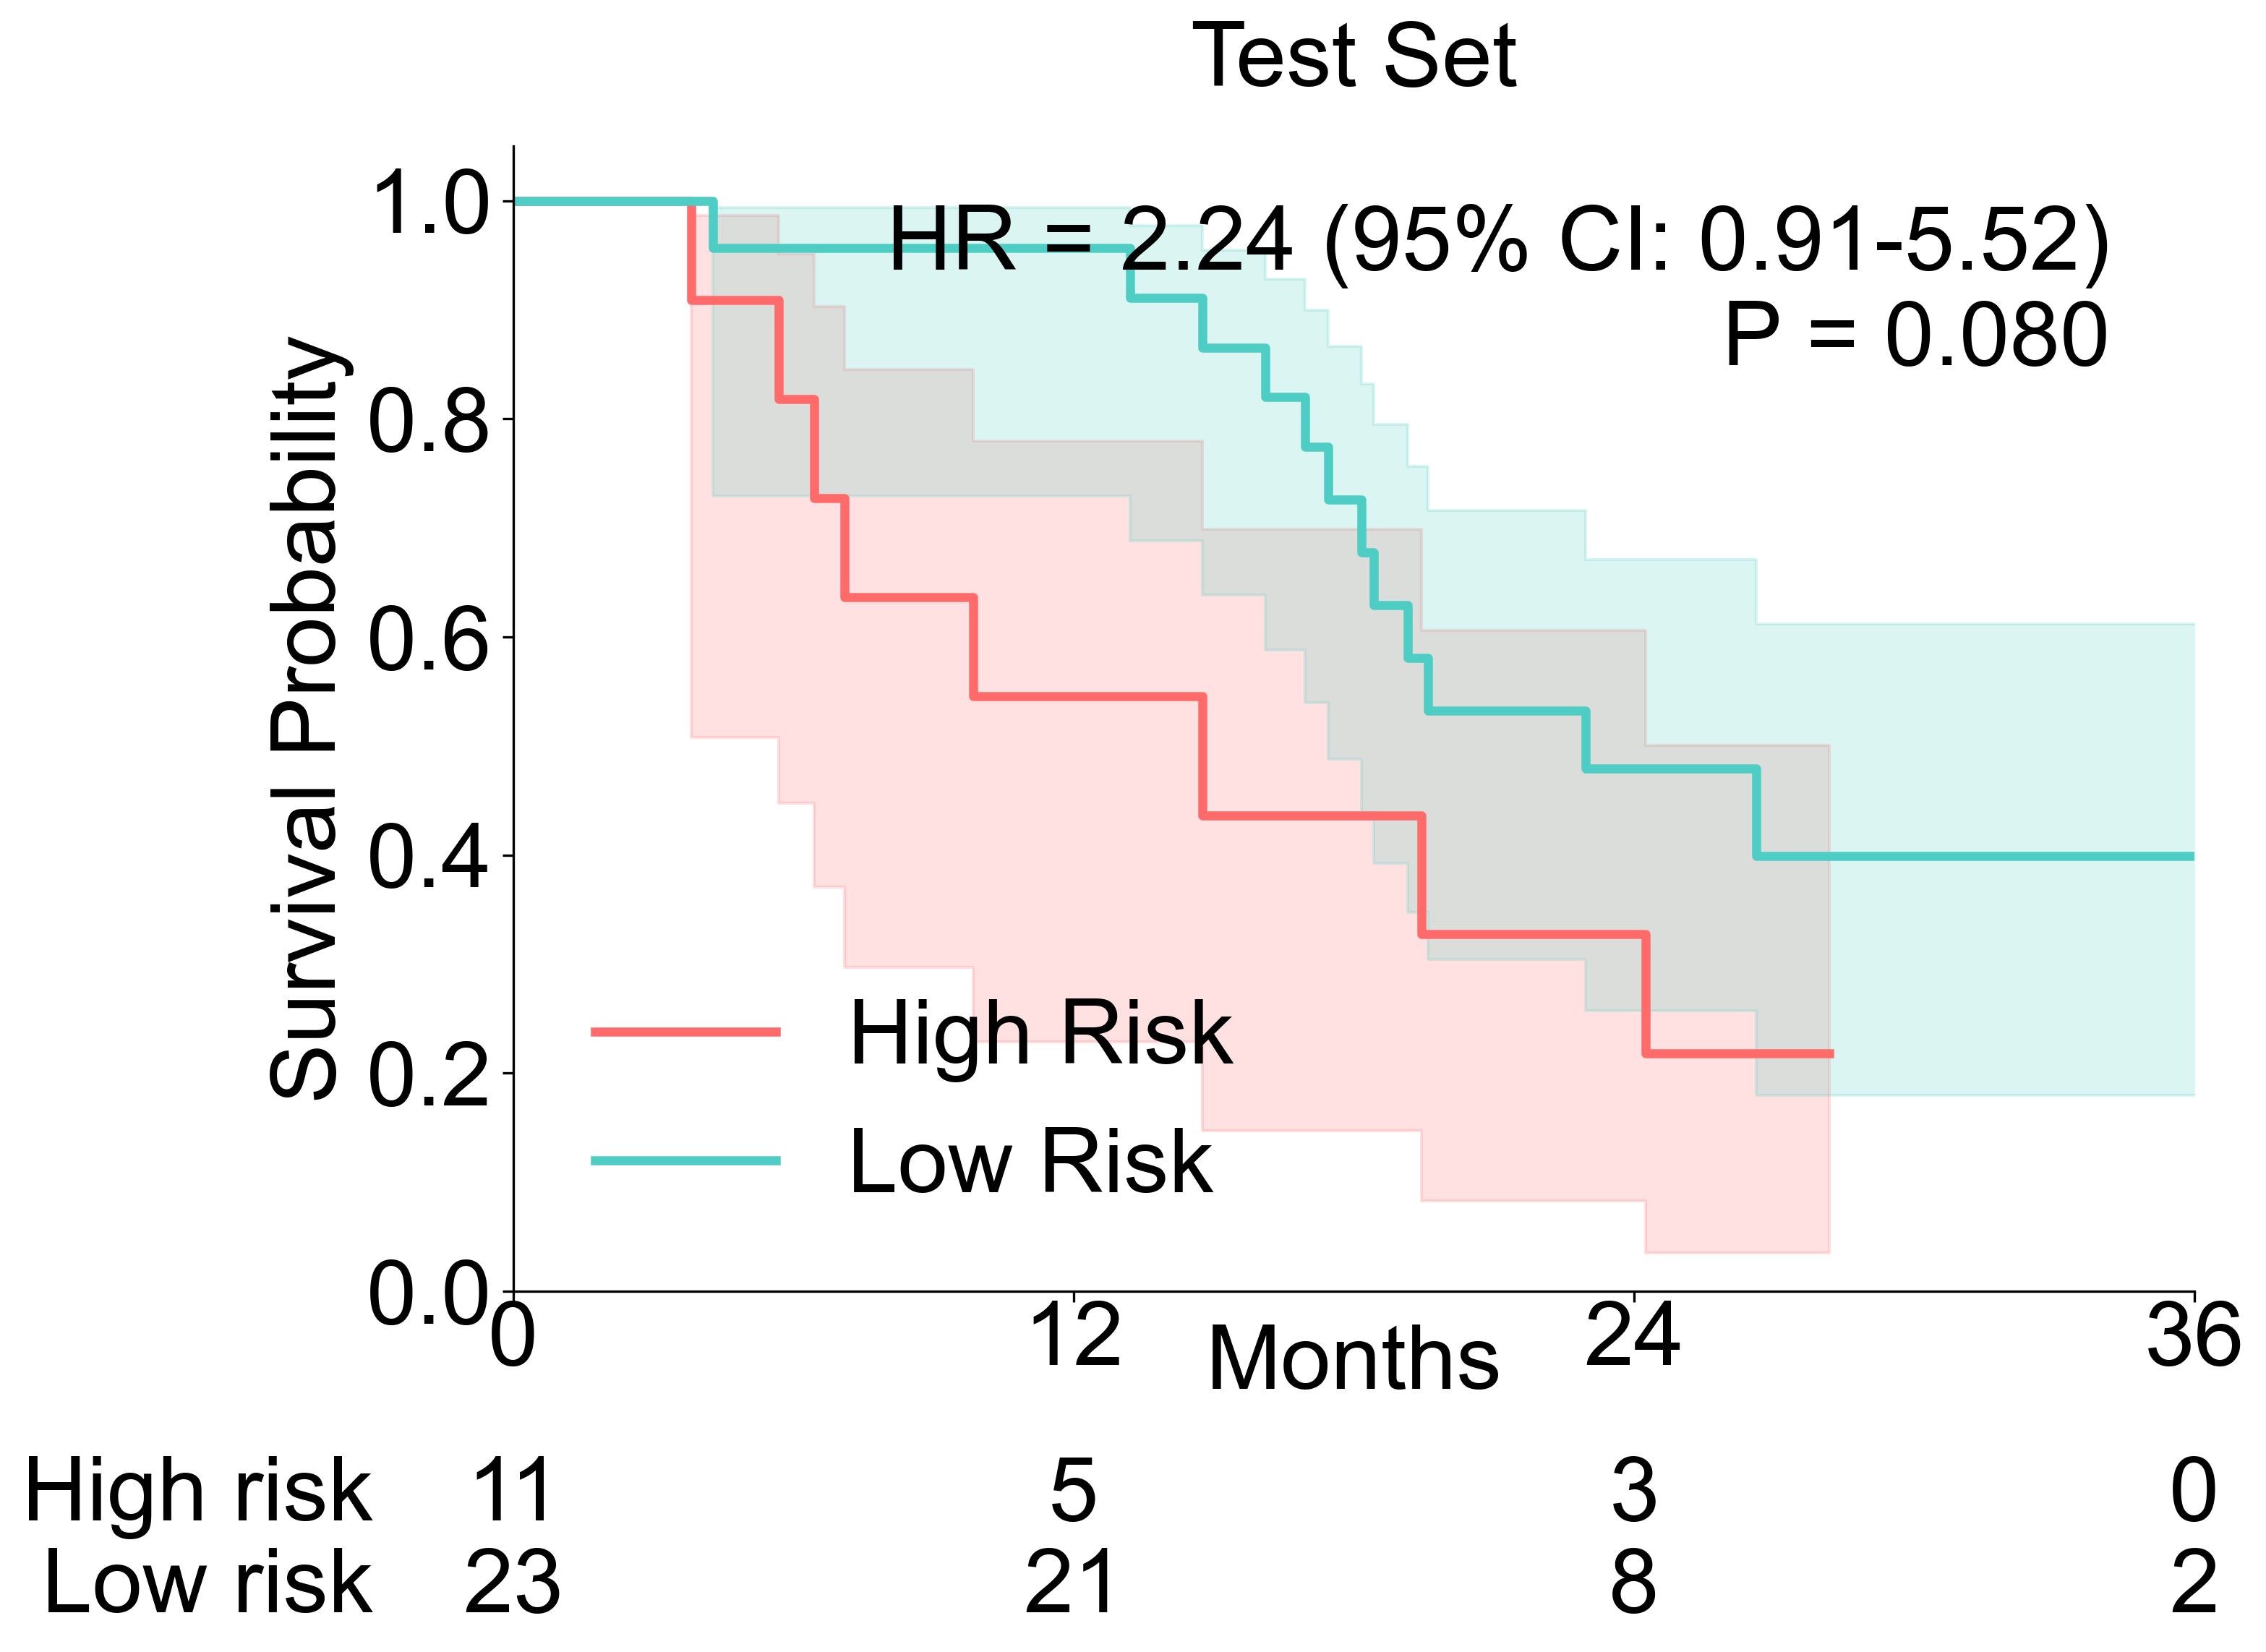

Test Set Log-rank Test: P-value = 7.3700e-02
Test Set Cox Regression: HR = 2.24 (95% CI: 0.91-5.52), P = 0.080
------------------------------------------------------------
=== External Validation Set ===
Saved: KM_External_Validation_Set.pdf


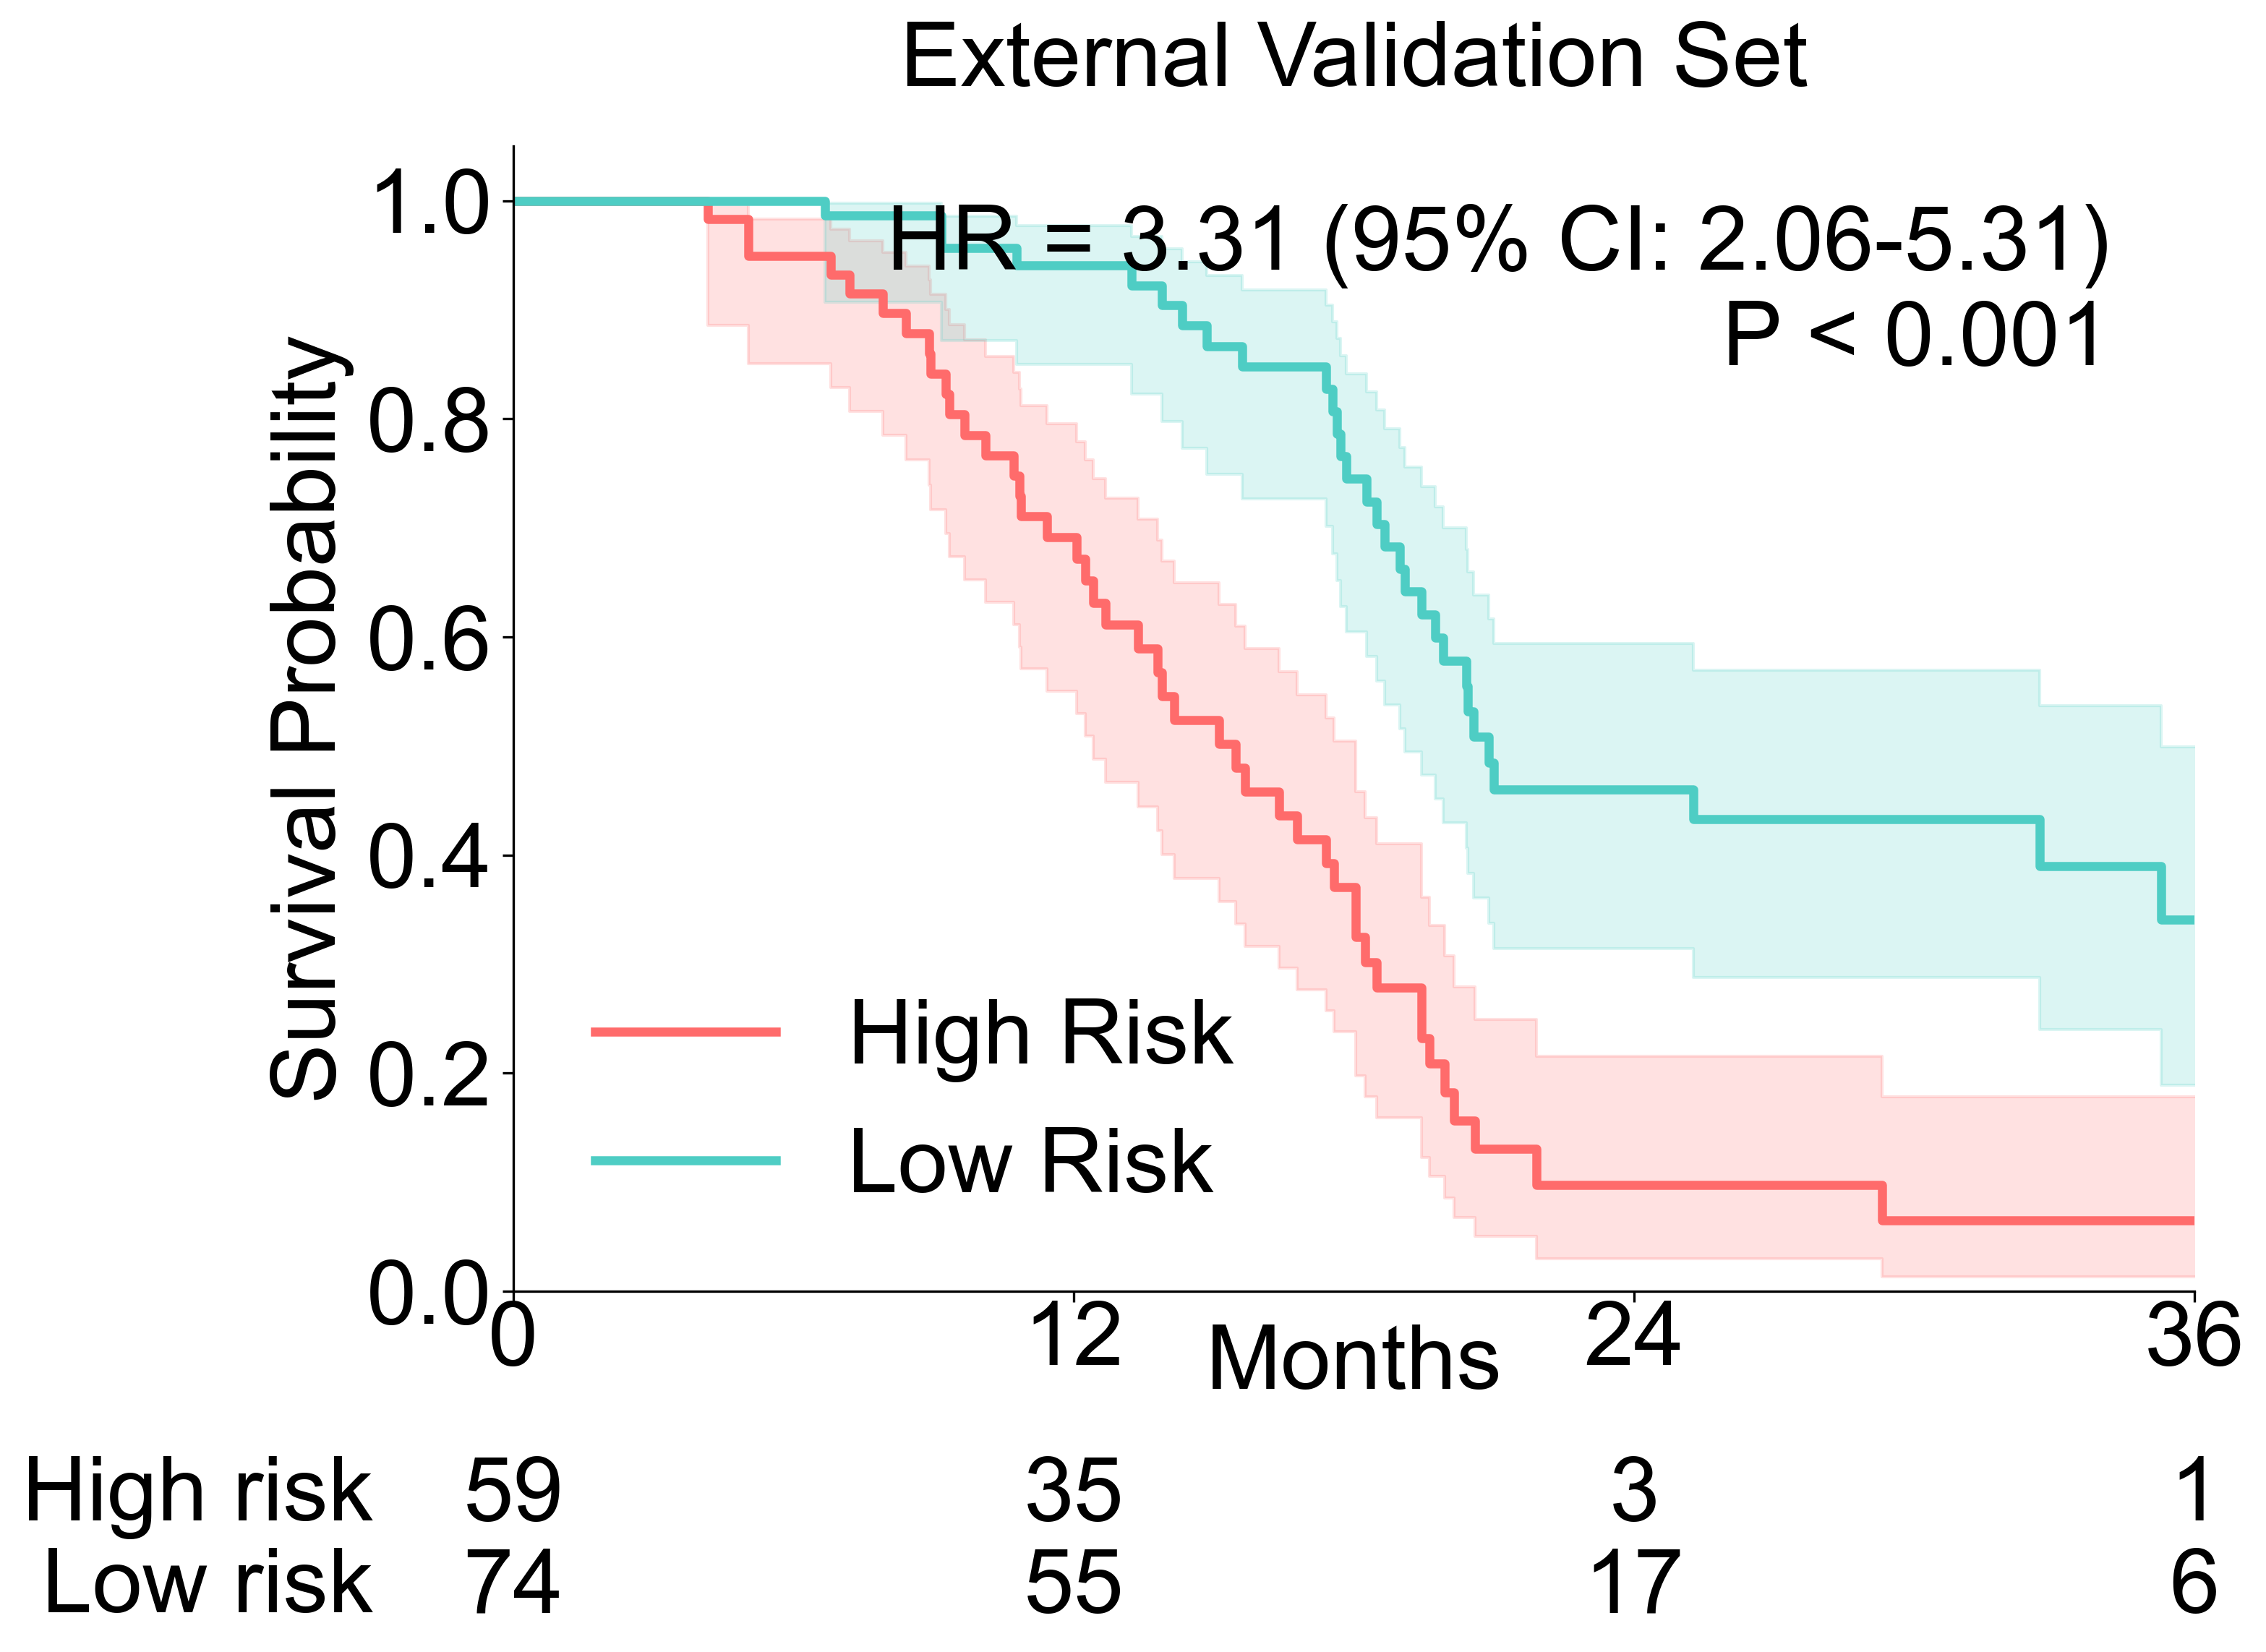

External Validation Set Log-rank Test: P-value = 2.0073e-07
External Validation Set Cox Regression: HR = 3.31 (95% CI: 2.06-5.31), P < 0.001
------------------------------------------------------------


In [8]:
# survival risk stratification for overall cohort
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sksurv.metrics import concordance_index_censored
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

warnings.filterwarnings("ignore")

def compute_fusion_risk(pred1, pred2, surv_data, tau=0.1):
    cindex1 = concordance_index_censored(surv_data["fstat"], surv_data["lenfol"], pred1)[0]
    cindex2 = concordance_index_censored(surv_data["fstat"], surv_data["lenfol"], pred2)[0]
    weight1 = np.exp((cindex1 - 0.5) / tau)
    weight2 = np.exp((cindex2 - 0.5) / tau)
    total_weight = weight1 + weight2
    norm_weight1 = weight1 / total_weight
    norm_weight2 = weight2 / total_weight
    fusion_risk = norm_weight1 * pred1 + norm_weight2 * pred2
    return fusion_risk

# Compute fusion risks for training, test, and external sets (assuming best_svm_model1, best_svm_model2,
# X_train1, X_train2, y_train, X_test1, X_test2, y_test, X_ext1_final, X_ext2_final, data_y_ext are defined)
tau = 0.1  # same parameter as before

risk_train_mod1 = best_svm_model1.predict(X_train1)
risk_train_mod2 = best_svm_model2.predict(X_train2)
fusion_risk_train = compute_fusion_risk(risk_train_mod1, risk_train_mod2, y_train, tau=tau)

risk_test_mod1 = best_svm_model1.predict(X_test1)
risk_test_mod2 = best_svm_model2.predict(X_test2)
fusion_risk_test = compute_fusion_risk(risk_test_mod1, risk_test_mod2, y_test, tau=tau)

risk_ext_mod1 = best_svm_model1.predict(X_ext1_final)
risk_ext_mod2 = best_svm_model2.predict(X_ext2_final)
fusion_risk_ext = compute_fusion_risk(risk_ext_mod1, risk_ext_mod2, data_y_ext, tau=tau)

median_cut = np.median(fusion_risk_train)
print("Training set fusion risk median: {:.4f}".format(median_cut))

def assign_risk_group(risk, median_cut):
    return np.where(risk >= median_cut, "High", "Low")

group_train = assign_risk_group(fusion_risk_train, median_cut)
group_test  = assign_risk_group(fusion_risk_test, median_cut)
group_ext   = assign_risk_group(fusion_risk_ext, median_cut)

def prepare_survival_df(surv_data, fusion_risk, risk_group):
    df = pd.DataFrame({
        "time": surv_data["lenfol"],
        "event": surv_data["fstat"],
        "fusion_risk": fusion_risk,
        "risk_group": risk_group
    })
    df["risk_flag"] = (df["risk_group"] == "High").astype(int)
    return df

df_train = prepare_survival_df(y_train, fusion_risk_train, group_train)
df_test  = prepare_survival_df(y_test, fusion_risk_test, group_test)
df_ext   = prepare_survival_df(data_y_ext, fusion_risk_ext, group_ext)

def plot_km_and_cox(df, dataset_name="Dataset", save_pdf=True):
    # Color scheme remains the same
    colors = {'High': '#FF6B6B', 'Low': '#4ECDC4'}

    # Set global font to Arial
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.sans-serif'] = ['Arial']

    # Convert time from days to months
    df['time_months'] = df['time'] / 30.44

    kmf_high = KaplanMeierFitter()
    kmf_low = KaplanMeierFitter()

    mask_high = df["risk_group"] == "High"
    mask_low = df["risk_group"] == "Low"
    T_high, E_high = df.loc[mask_high, "time_months"], df.loc[mask_high, "event"]
    T_low, E_low = df.loc[mask_low, "time_months"], df.loc[mask_low, "event"]

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

    # Plot KM curves
    kmf_high.fit(T_high, event_observed=E_high, label="High Risk")
    kmf_low.fit(T_low, event_observed=E_low, label="Low Risk")

    ax = kmf_high.plot(ci_show=True,
                      color=colors['High'],
                      ci_alpha=0.2,
                      linewidth=3,
                      show_censors=False,
                      ax=ax)

    ax = kmf_low.plot(ax=ax,
                     ci_show=True,
                     color=colors['Low'],
                     ci_alpha=0.2,
                     linewidth=3,
                     show_censors=False)

    # Calculate number at risk
    times = [0, 12, 24, 36]
    high_risk_counts = []
    low_risk_counts = []

    for t in times:
        high_risk_counts.append(sum(T_high >= t))
        low_risk_counts.append(sum(T_low >= t))

    # Cox regression and P-value
    from lifelines.utils import ConvergenceWarning
    import warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    from lifelines.statistics import logrank_test

    lr_result = logrank_test(T_high, T_low, event_observed_A=E_high, event_observed_B=E_low)
    cph = CoxPHFitter()
    cph.fit(df[["time_months", "event", "risk_flag"]], duration_col="time_months", event_col="event")
    hr = cph.hazard_ratios_["risk_flag"]
    ci_lower = cph.summary.loc["risk_flag", "exp(coef) lower 95%"]
    ci_upper = cph.summary.loc["risk_flag", "exp(coef) upper 95%"]
    p_value = cph.summary.loc["risk_flag", "p"]

    if p_value < 0.001:
        p_text = "P < 0.001"
    else:
        p_text = f"P = {p_value:.3f}"

    # Combine HR and P-value display
    textstr = f"HR = {hr:.2f} (95% CI: {ci_lower:.2f}-{ci_upper:.2f})\n{p_text}"
    plt.text(0.95, 0.95, textstr,
            transform=ax.transAxes,
            horizontalalignment='right',
            verticalalignment='top',
            bbox=dict(facecolor='none', edgecolor='none', pad=2.5),
            fontsize=30, family="Arial")

    # Set title and labels
    plt.title(f"{dataset_name}",
              fontsize=30,
              pad=20,
              family="Arial")
    plt.xlabel("Months", fontsize=30, family="Arial")
    plt.ylabel("Survival Probability", fontsize=30, family="Arial")

    # Optimize legend
    plt.legend(
        loc='lower left',
        frameon=True,
        edgecolor='none',
        shadow=False,
        fontsize=30,
        facecolor='none',
        framealpha=0
    )

    # Beautify axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=18)
    plt.ylim(0, 1.05)

    # Set x-ticks
    plt.xticks(times, fontsize=30)
    plt.yticks(fontsize=30)

    # Adjust main plot position
    plt.subplots_adjust(bottom=0.22)

    # Remove x-axis tick labels
    ax.set_xticklabels([])

    # Add time point labels
    for i, t in enumerate(times):
        plt.text(t, -0.08, str(t),
                ha='center', va='bottom',
                transform=ax.get_xaxis_transform(),
                fontsize=30, family="Arial")

    # Calculate label position
    x_min = min(times)
    time_interval = times[1] - times[0]
    label_x_pos = x_min - time_interval/4

    # Risk group labels
    plt.text(label_x_pos, -0.18, "High risk",
            ha='right', va='center',
            transform=ax.get_xaxis_transform(),
            fontsize=30, family="Arial")
    plt.text(label_x_pos, -0.26, "Low risk",
            ha='right', va='center',
            transform=ax.get_xaxis_transform(),
            fontsize=30, family="Arial")

    # Add numbers at risk
    for i, (high_count, low_count) in enumerate(zip(high_risk_counts, low_risk_counts)):
        # High risk data
        plt.text(times[i], -0.18, str(high_count),
                ha='center', va='center',
                transform=ax.get_xaxis_transform(),
                fontsize=30, family="Arial")

        # Low risk data
        plt.text(times[i], -0.26, str(low_count),
                ha='center', va='center',
                transform=ax.get_xaxis_transform(),
                fontsize=30, family="Arial")

    plt.xlim(times[0], times[-1])

    # Save as PDF
    if save_pdf:
        pdfname = f"KM_{dataset_name.replace(' ', '_')}.pdf"
        plt.savefig(pdfname, format="pdf", bbox_inches="tight")
        print(f"Saved: {pdfname}")

    plt.show()

    print(f"{dataset_name} Log-rank Test: P-value = {lr_result.p_value:.4e}")
    print(f"{dataset_name} Cox Regression: HR = {hr:.2f} (95% CI: {ci_lower:.2f}-{ci_upper:.2f}), {p_text}")
    print("-" * 60)

# Run code
print("=== Training Set ===")
plot_km_and_cox(df_train, dataset_name="Training Set")

print("=== Test Set ===")
plot_km_and_cox(df_test, dataset_name="Test Set")

print("=== External Validation Set ===")
plot_km_and_cox(df_ext, dataset_name="External Validation Set")

Training set fusion risk median cut-off: 0.0317
=== Training Set (TACE+HAIC) ===
Saved: KM_Training_Set_TACE_HAIC_TACEplusHAIC.pdf


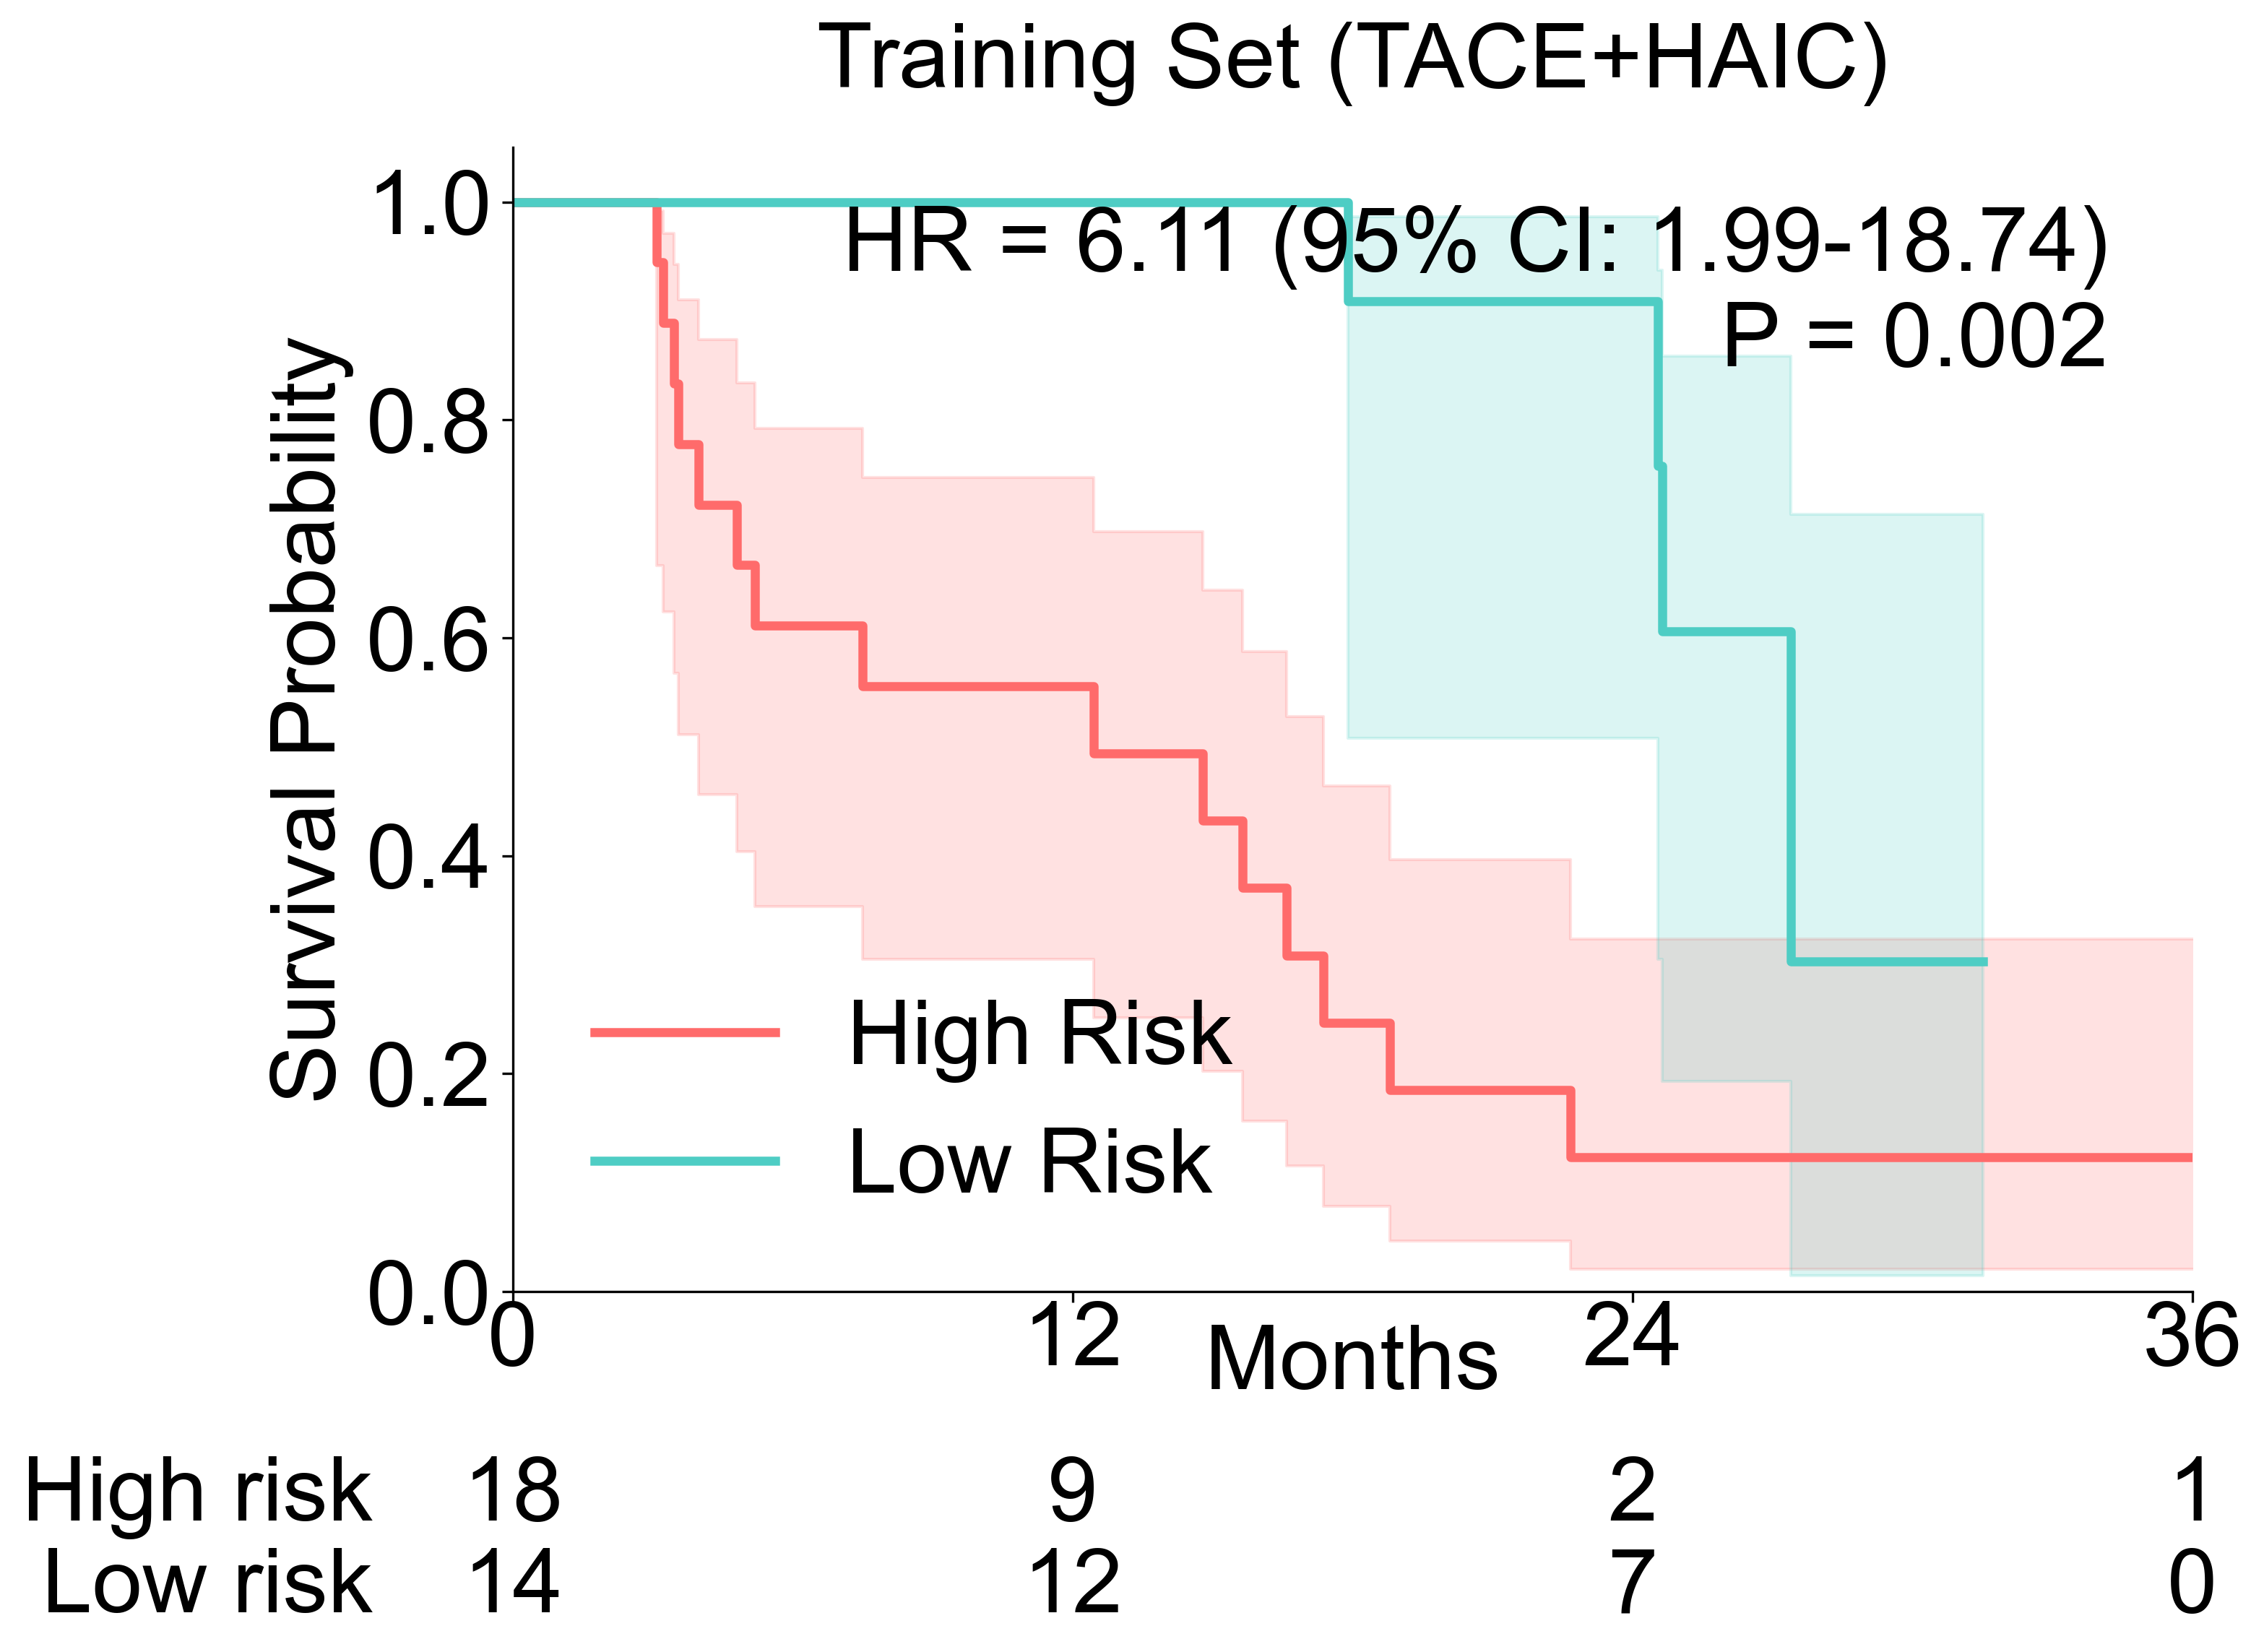

Training Set (TACE+HAIC) Log-rank Test: P-value = 3.7233e-04
Training Set (TACE+HAIC) Cox Regression: HR = 6.11 (95% CI: 1.99-18.74), P = 0.002
------------------------------------------------------------

=== Training Set (TACE/HAIC) ===
Saved: KM_Training_Set_TACE_HAIC_TACE_HAIC.pdf


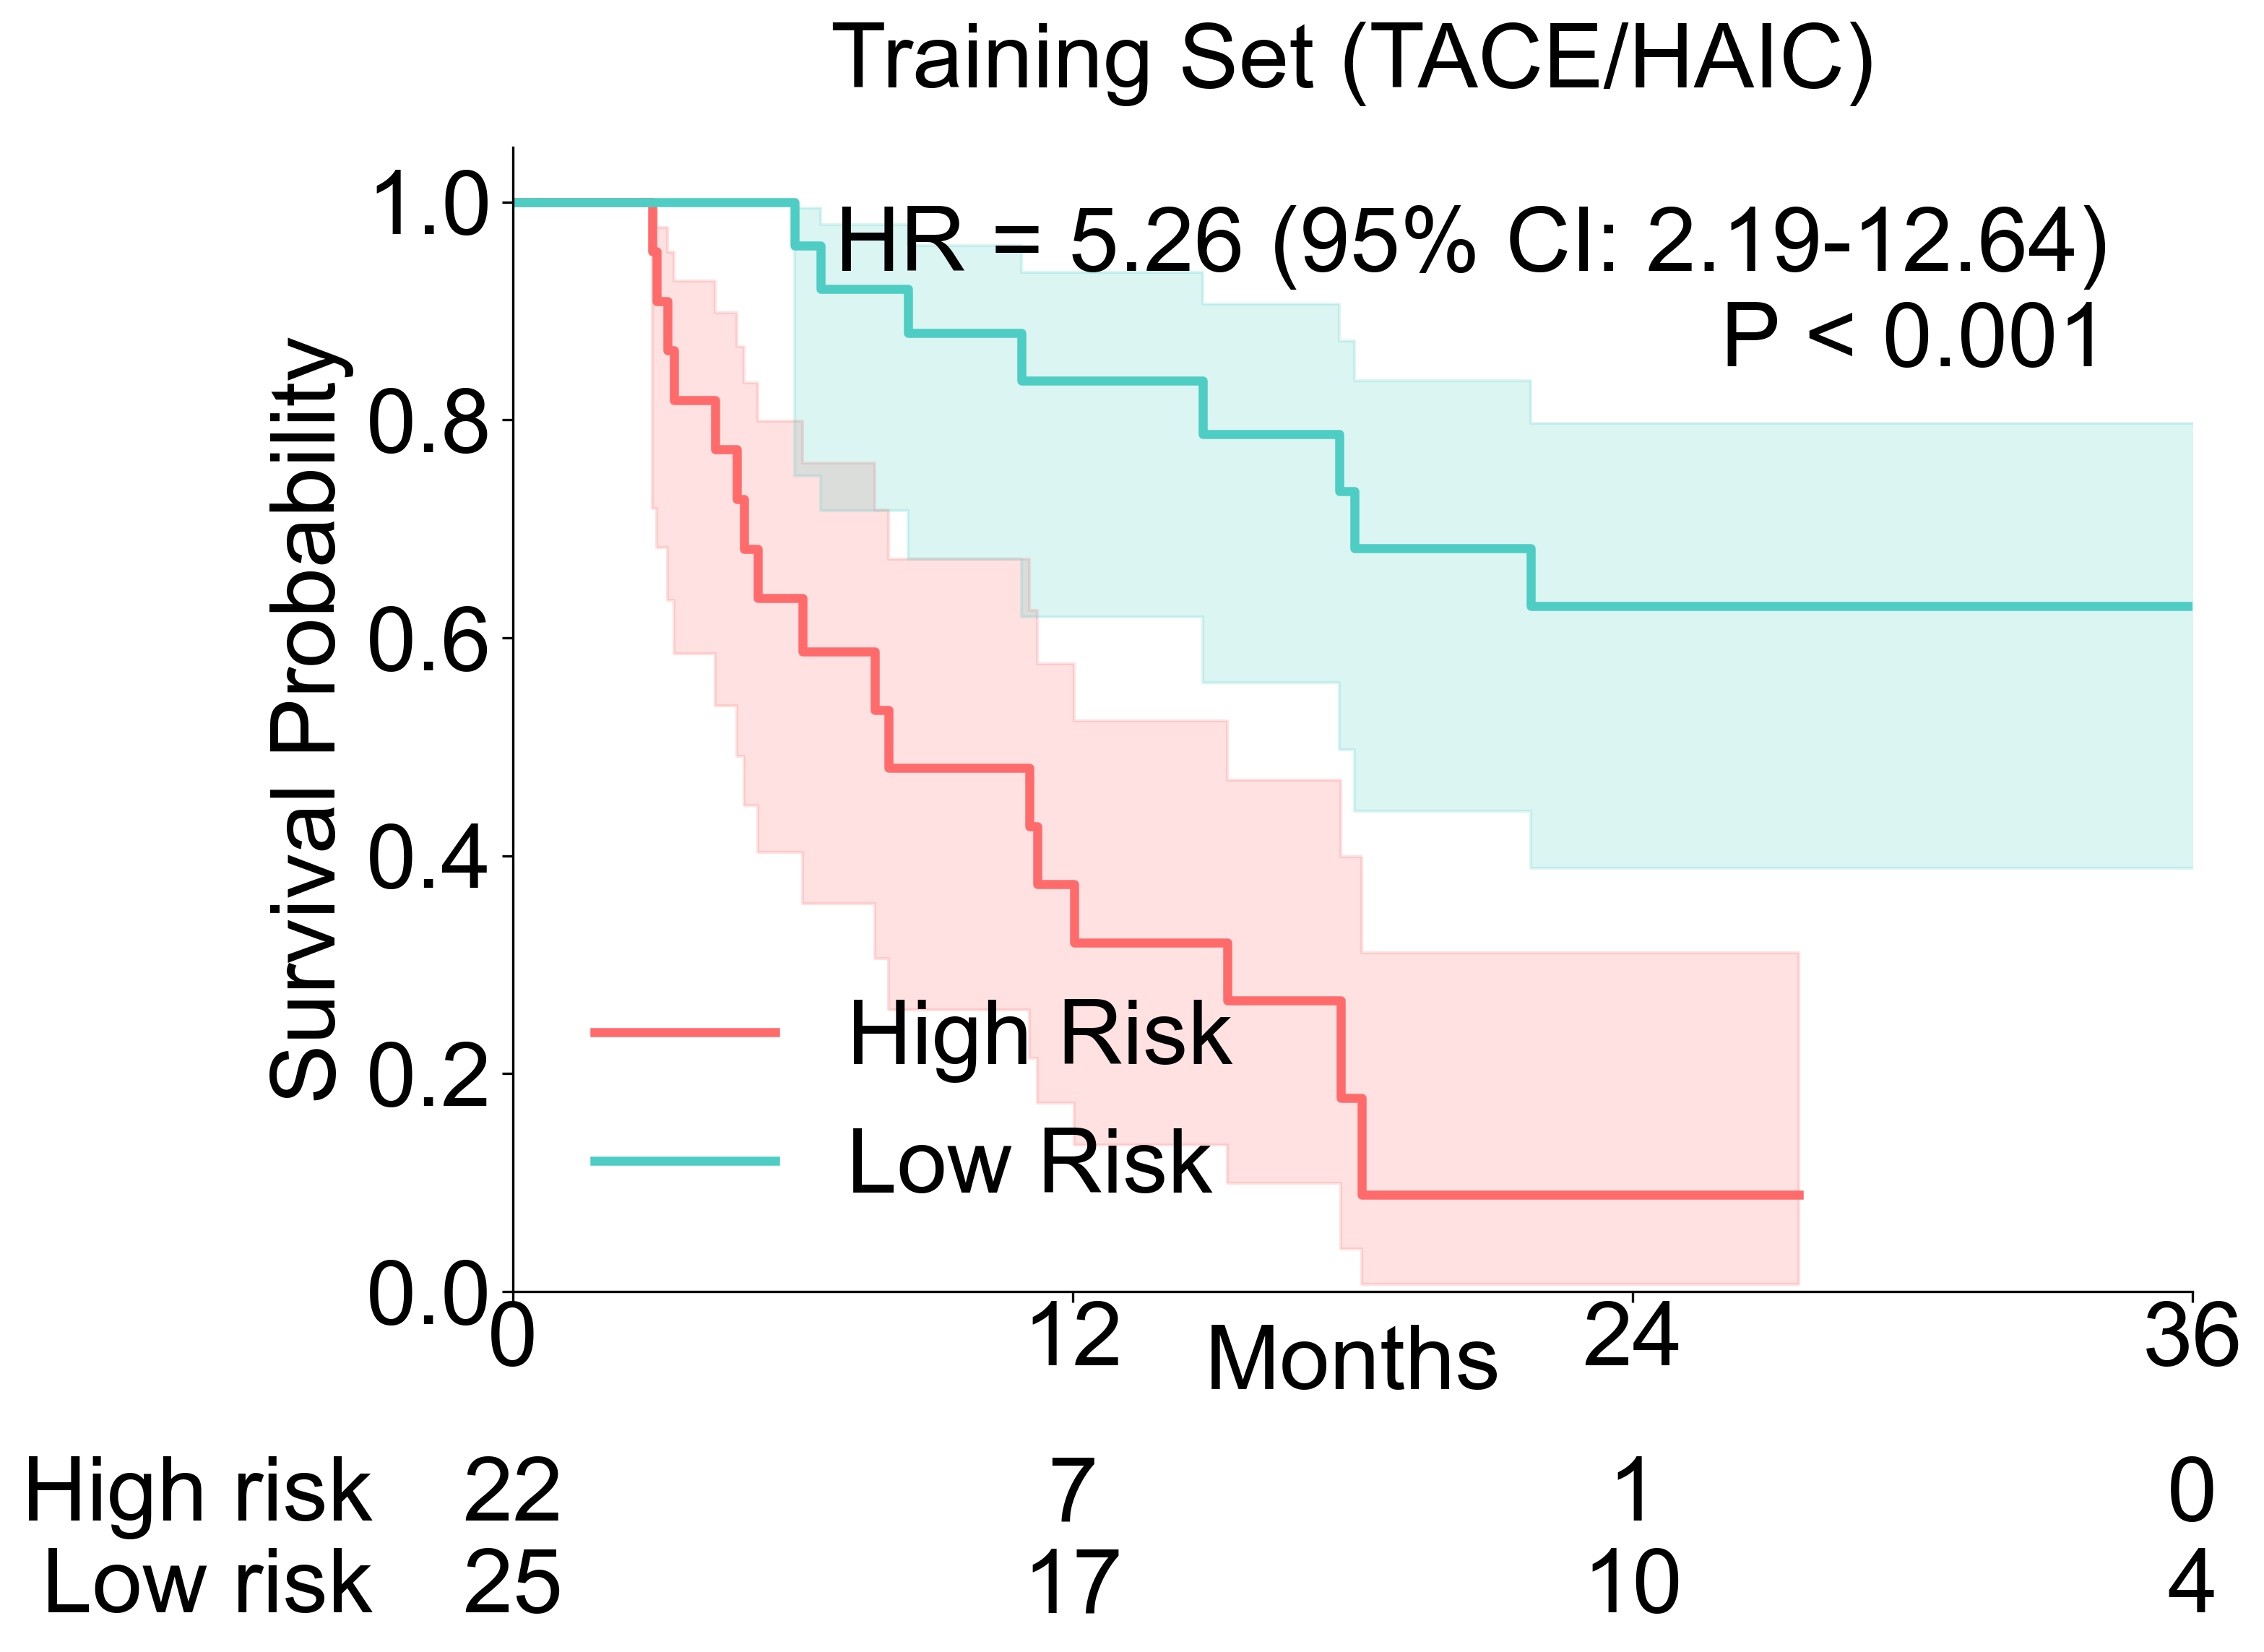

Training Set (TACE/HAIC) Log-rank Test: P-value = 4.6511e-05
Training Set (TACE/HAIC) Cox Regression: HR = 5.26 (95% CI: 2.19-12.64), P < 0.001
------------------------------------------------------------

=== Test Set (TACE+HAIC) ===
Saved: KM_Test_Set_TACE_HAIC_TACEplusHAIC.pdf


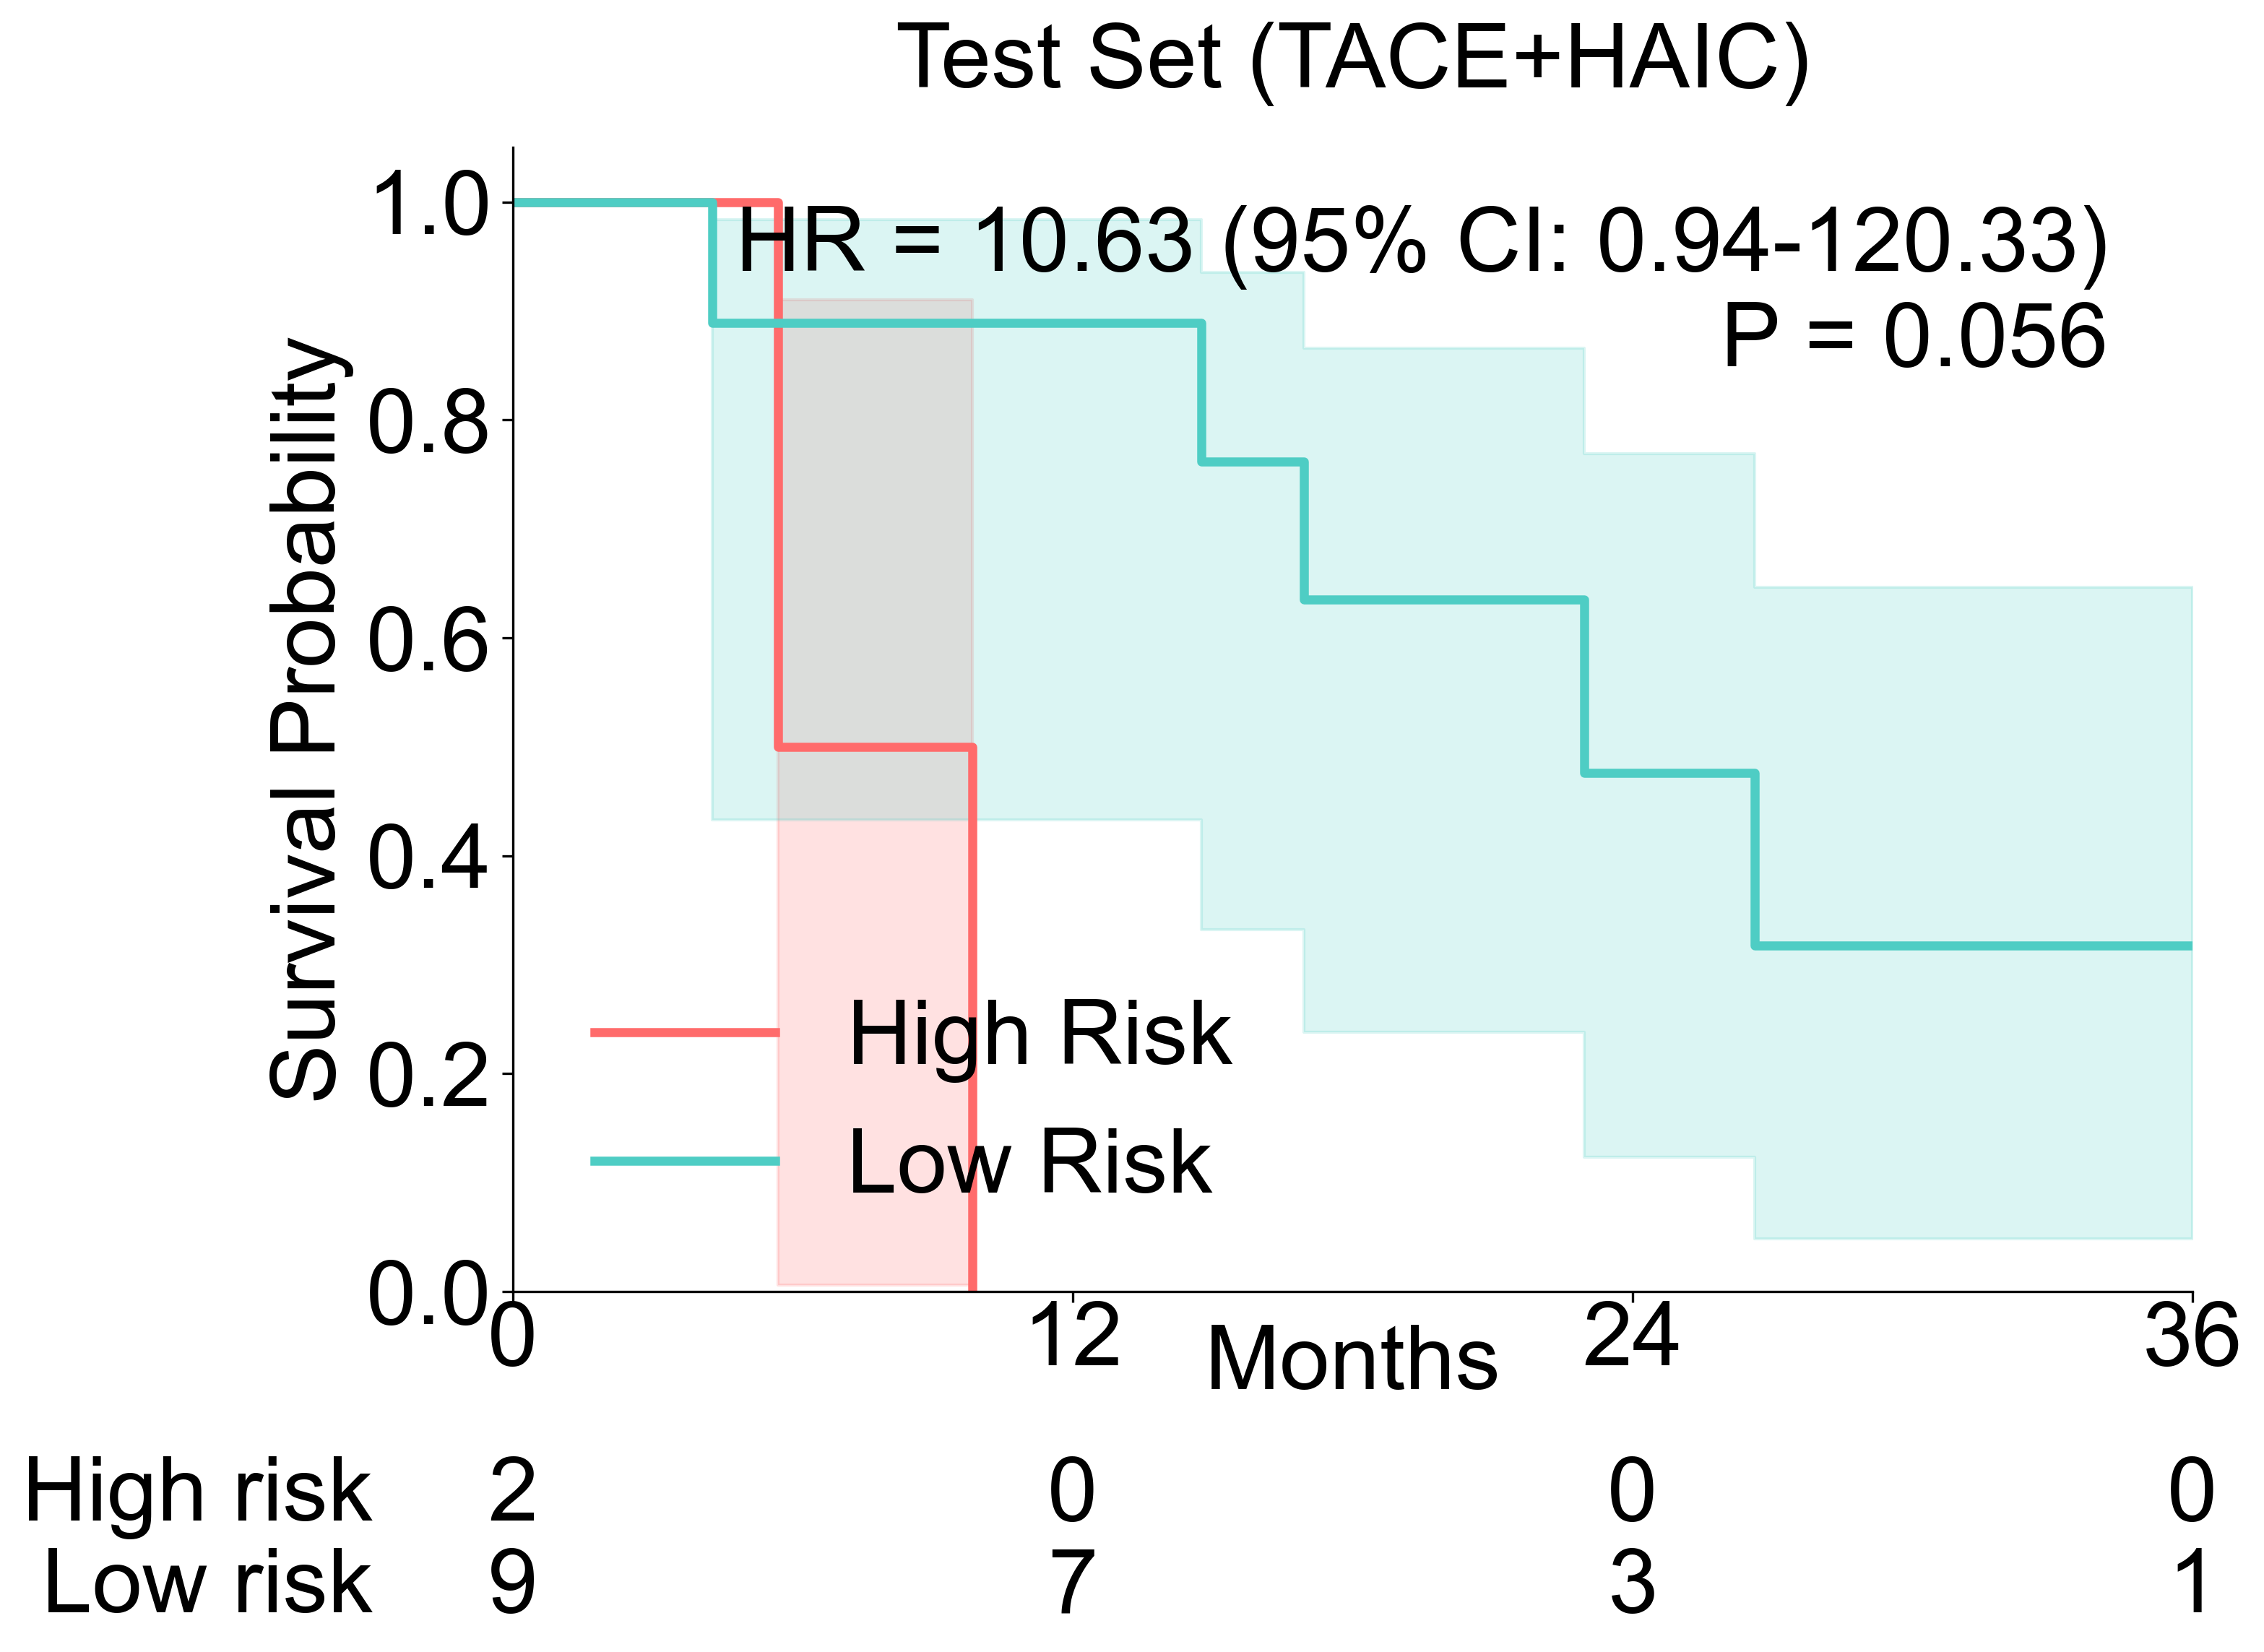

Test Set (TACE+HAIC) Log-rank Test: P-value = 1.8236e-02
Test Set (TACE+HAIC) Cox Regression: HR = 10.63 (95% CI: 0.94-120.33), P = 0.056
------------------------------------------------------------

=== Test Set (TACE/HAIC) ===
Saved: KM_Test_Set_TACE_HAIC_TACE_HAIC.pdf


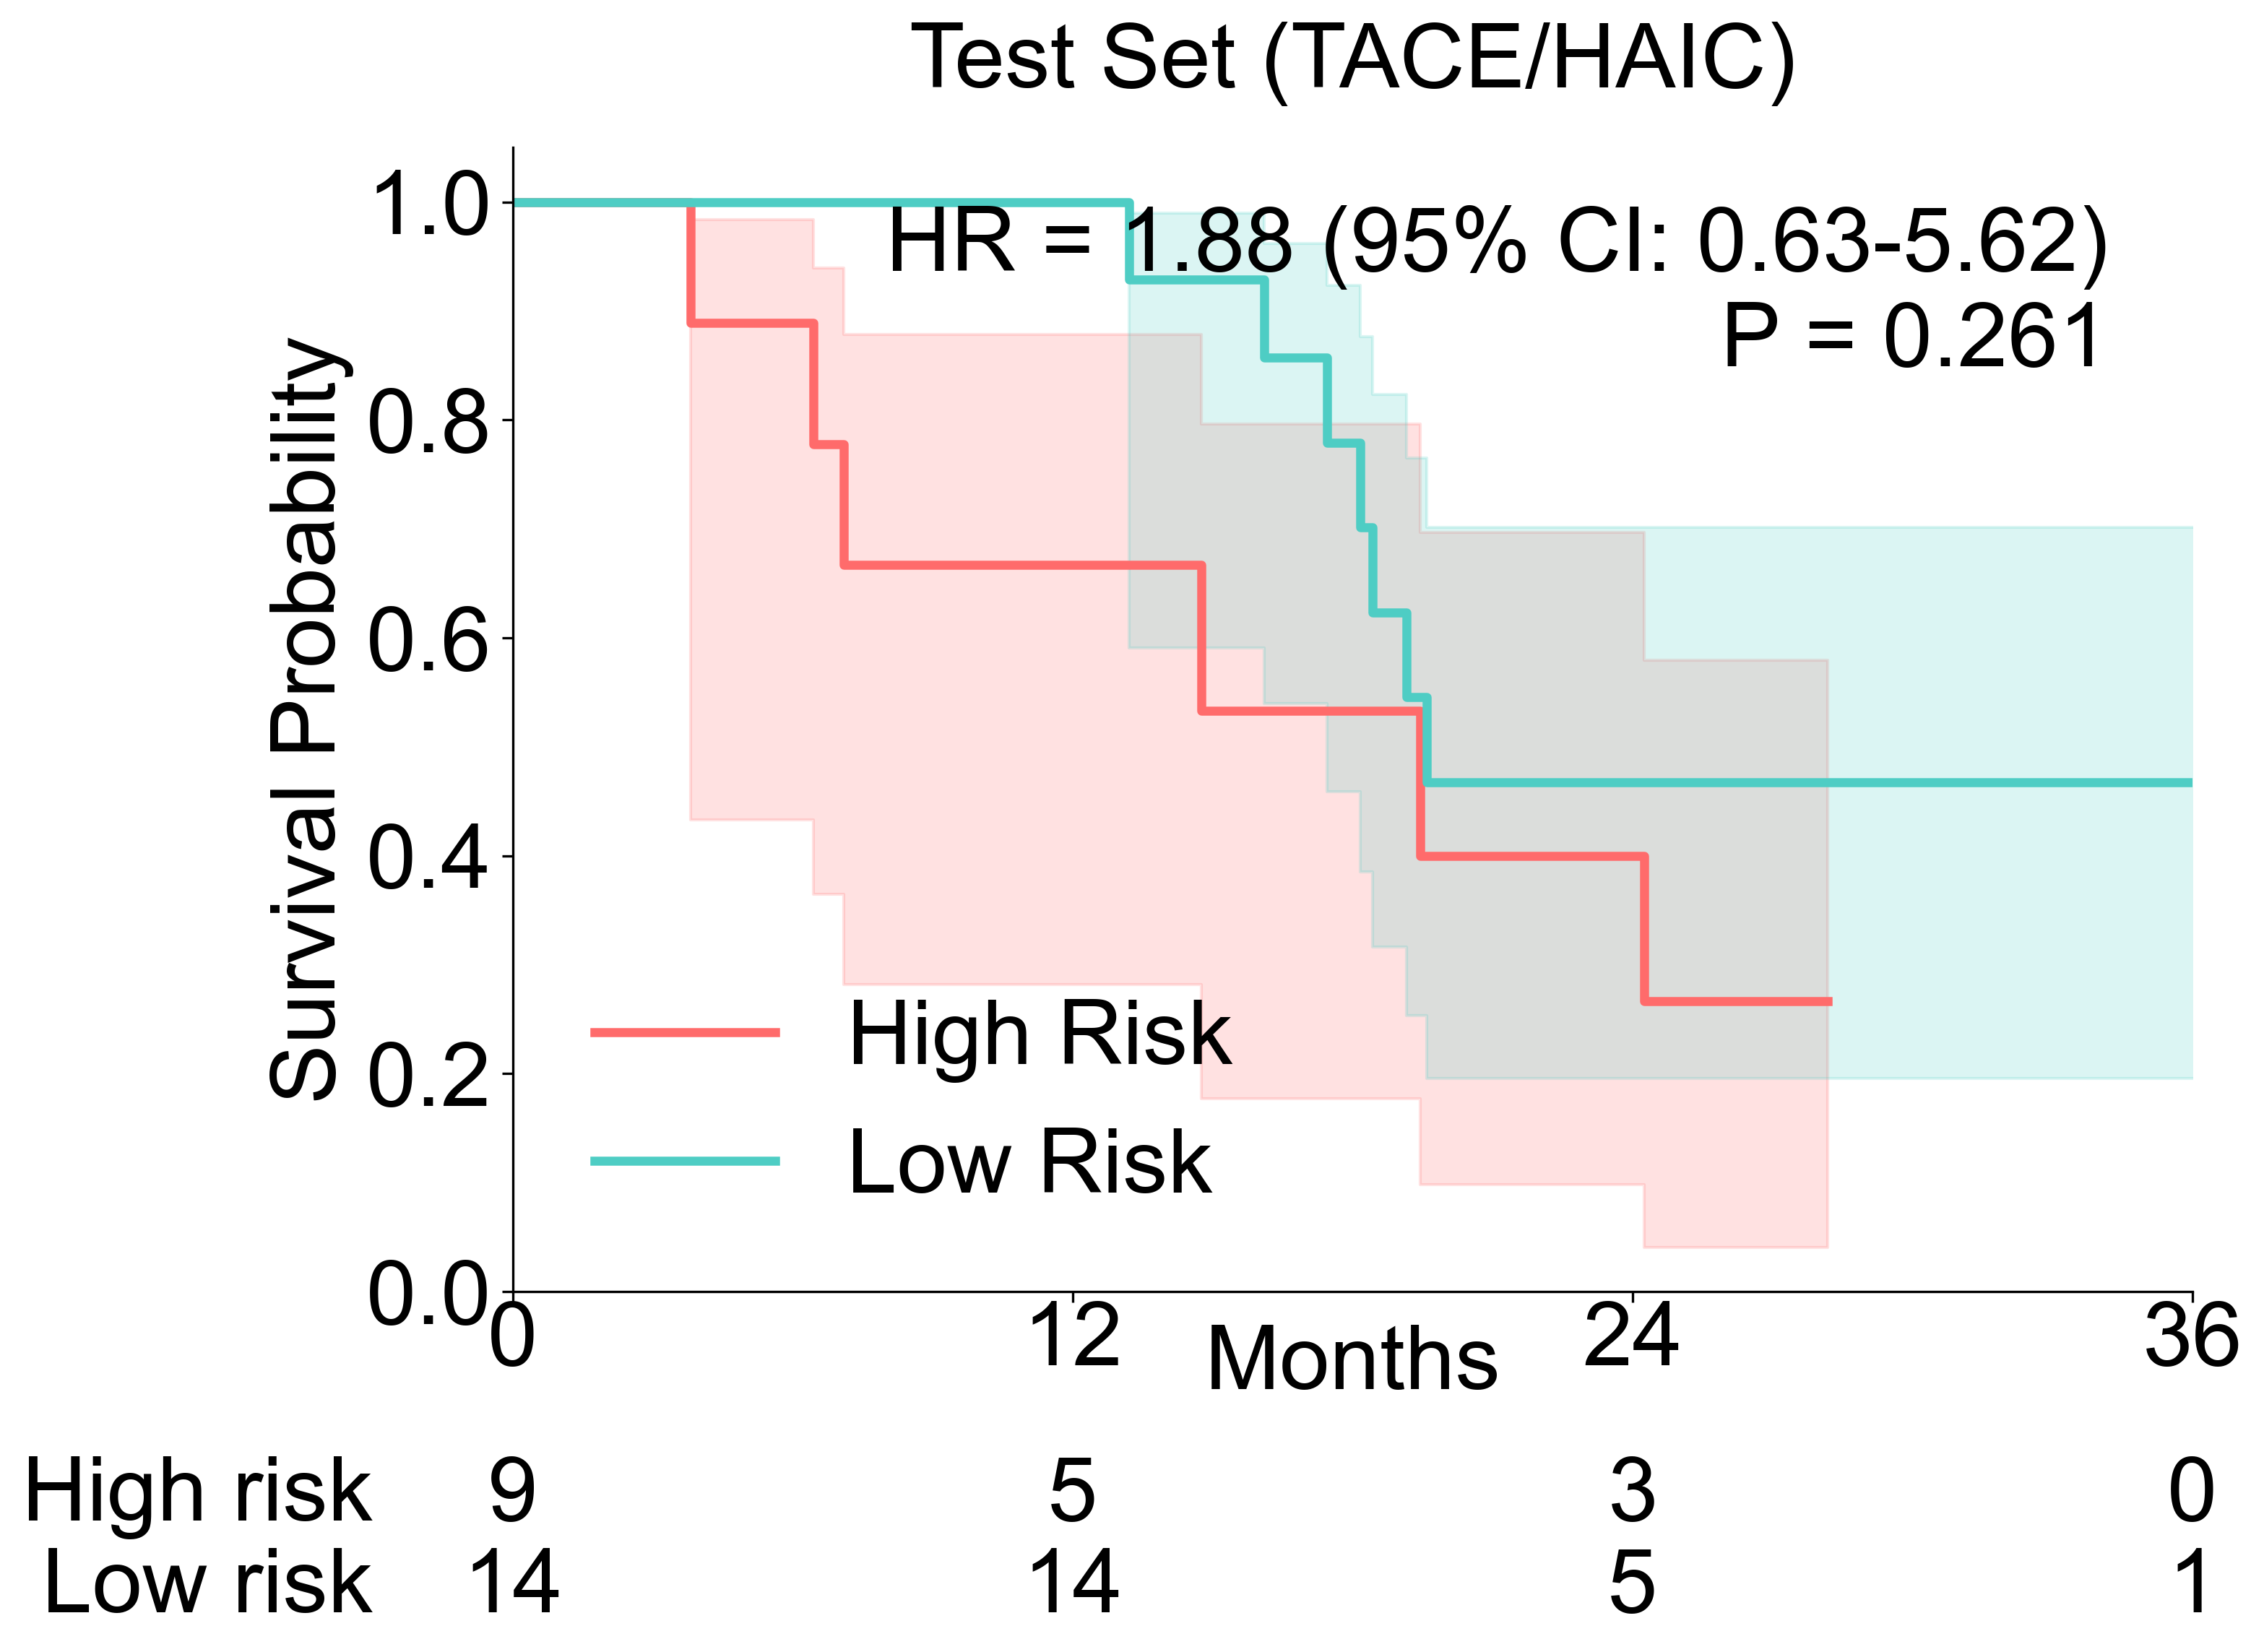

Test Set (TACE/HAIC) Log-rank Test: P-value = 2.5335e-01
Test Set (TACE/HAIC) Cox Regression: HR = 1.88 (95% CI: 0.63-5.62), P = 0.261
------------------------------------------------------------

=== External Validation Set (TACE+HAIC) ===
Saved: KM_External_Validation_Set_TACE_HAIC_TACEplusHAIC.pdf


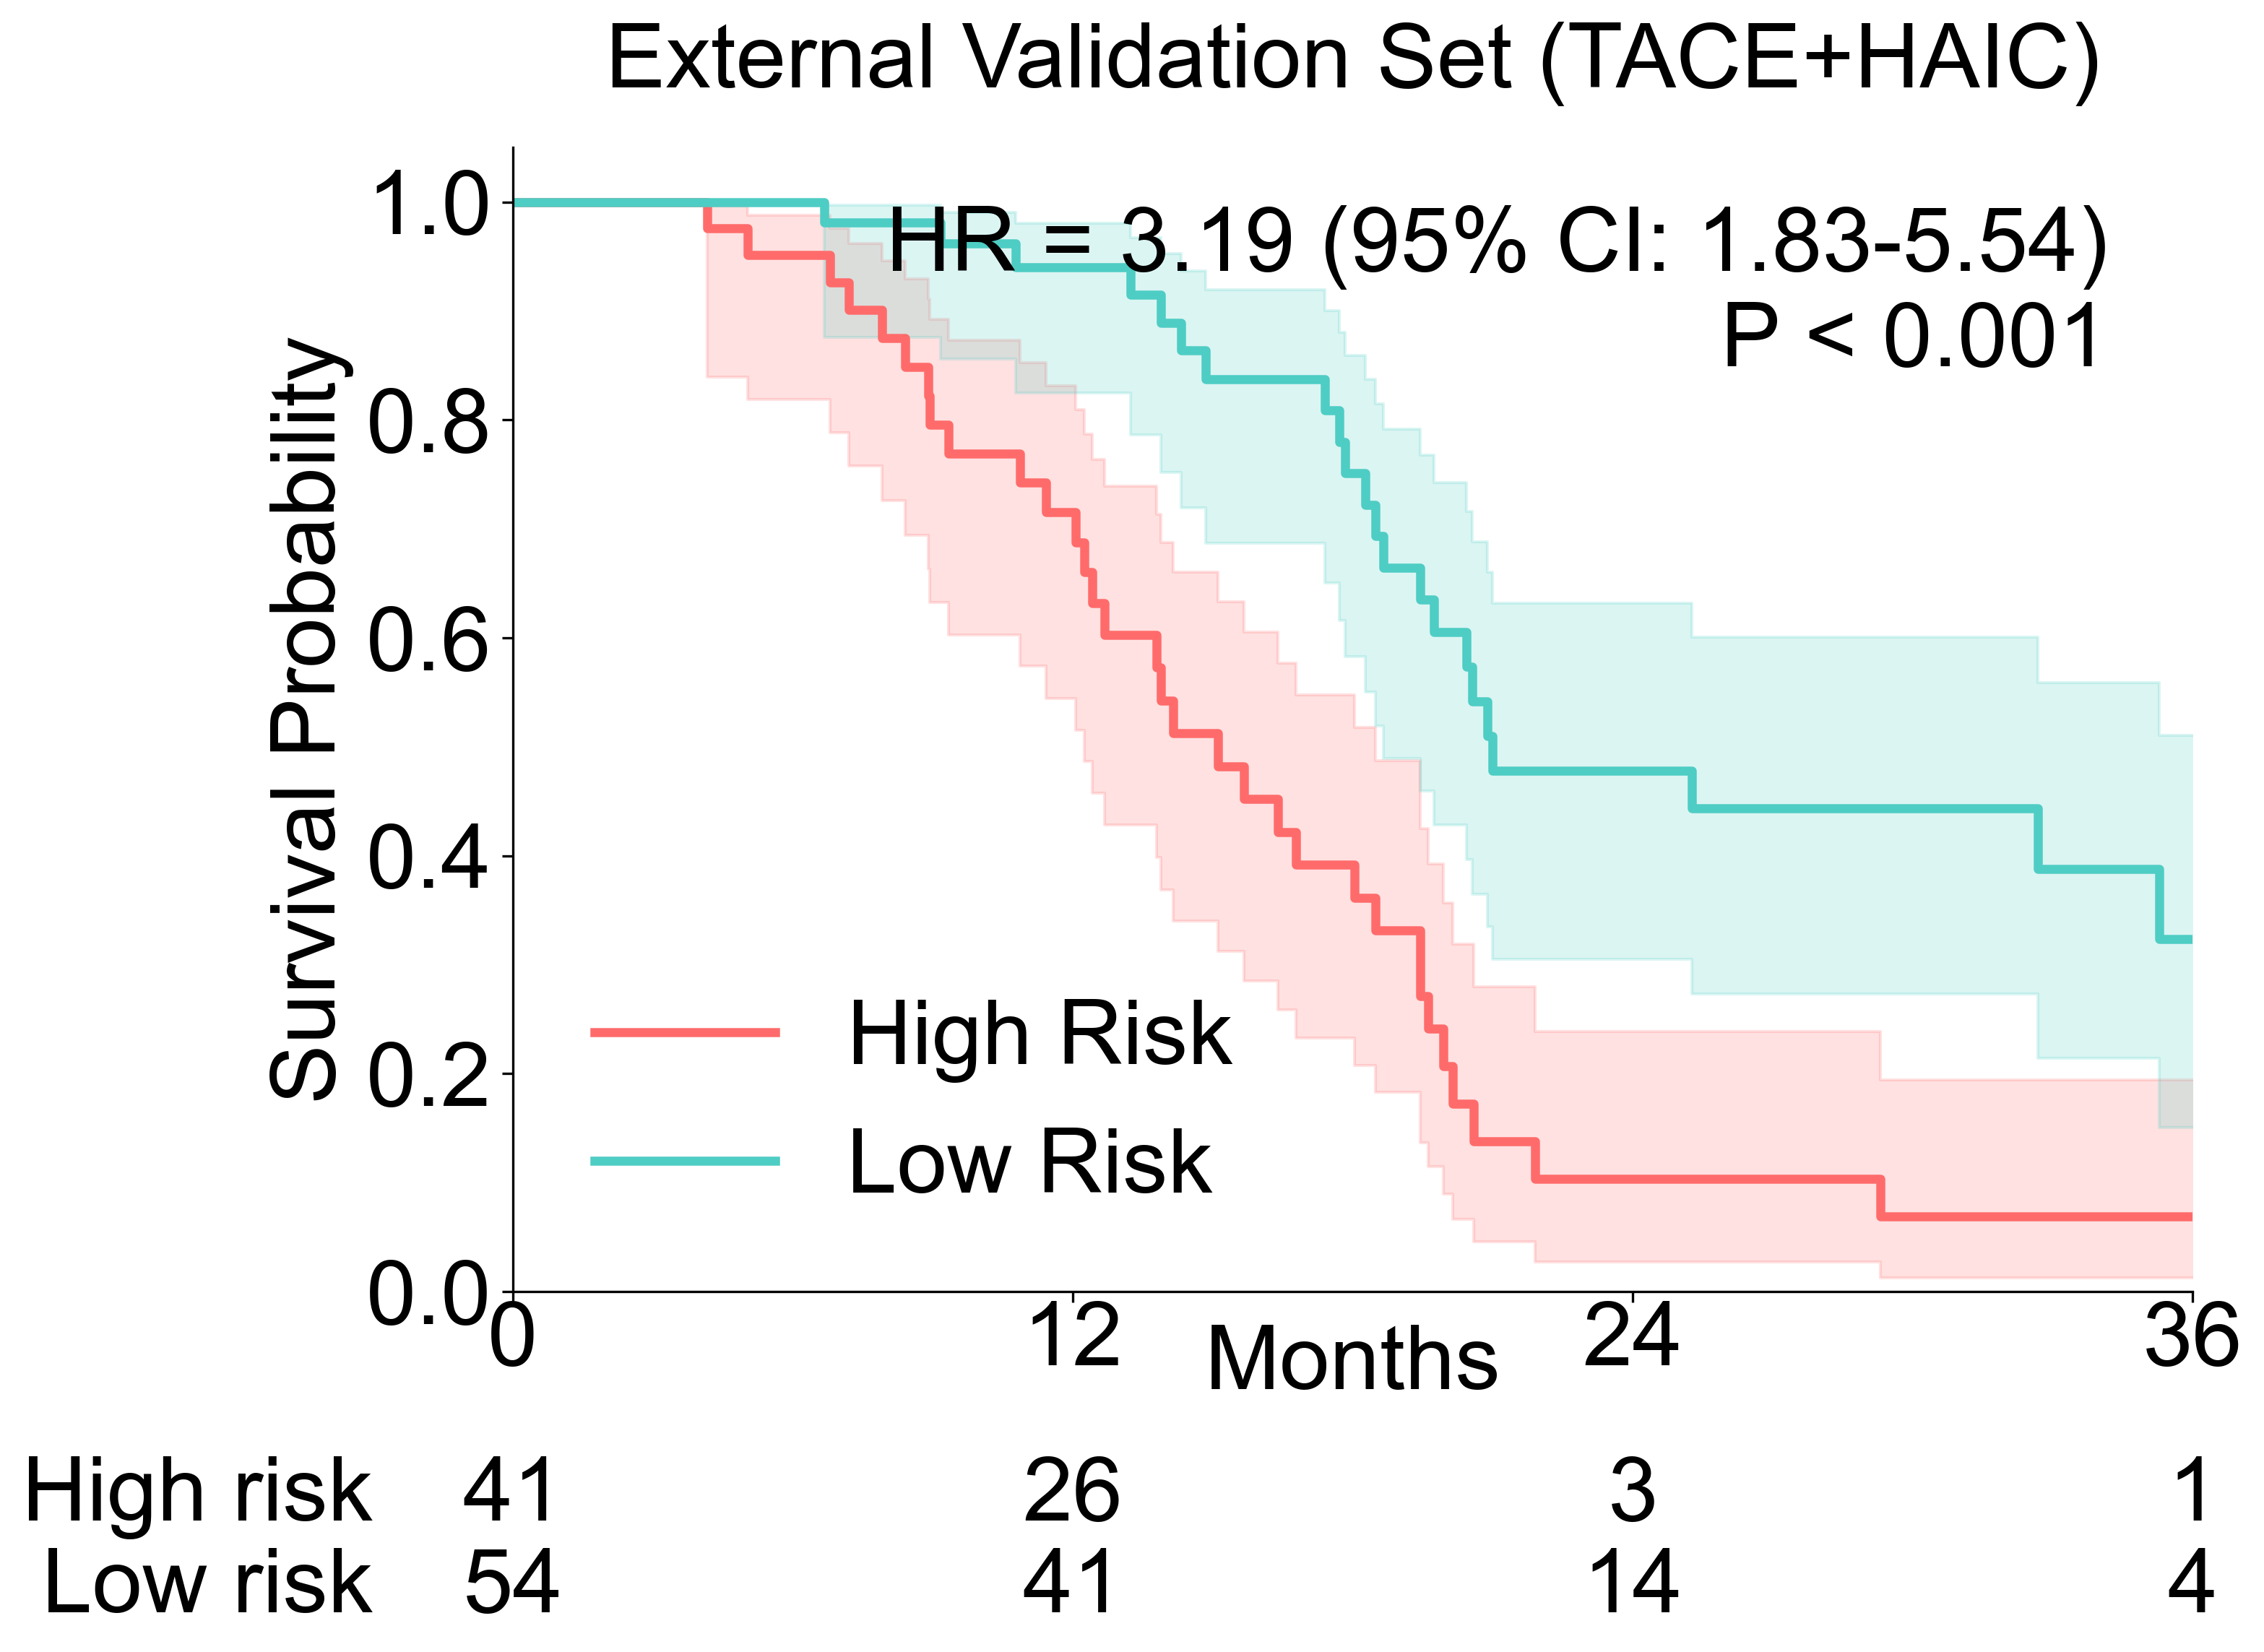

External Validation Set (TACE+HAIC) Log-rank Test: P-value = 1.5441e-05
External Validation Set (TACE+HAIC) Cox Regression: HR = 3.19 (95% CI: 1.83-5.54), P < 0.001
------------------------------------------------------------

=== External Validation Set (TACE/HAIC) ===
Saved: KM_External_Validation_Set_TACE_HAIC_TACE_HAIC.pdf


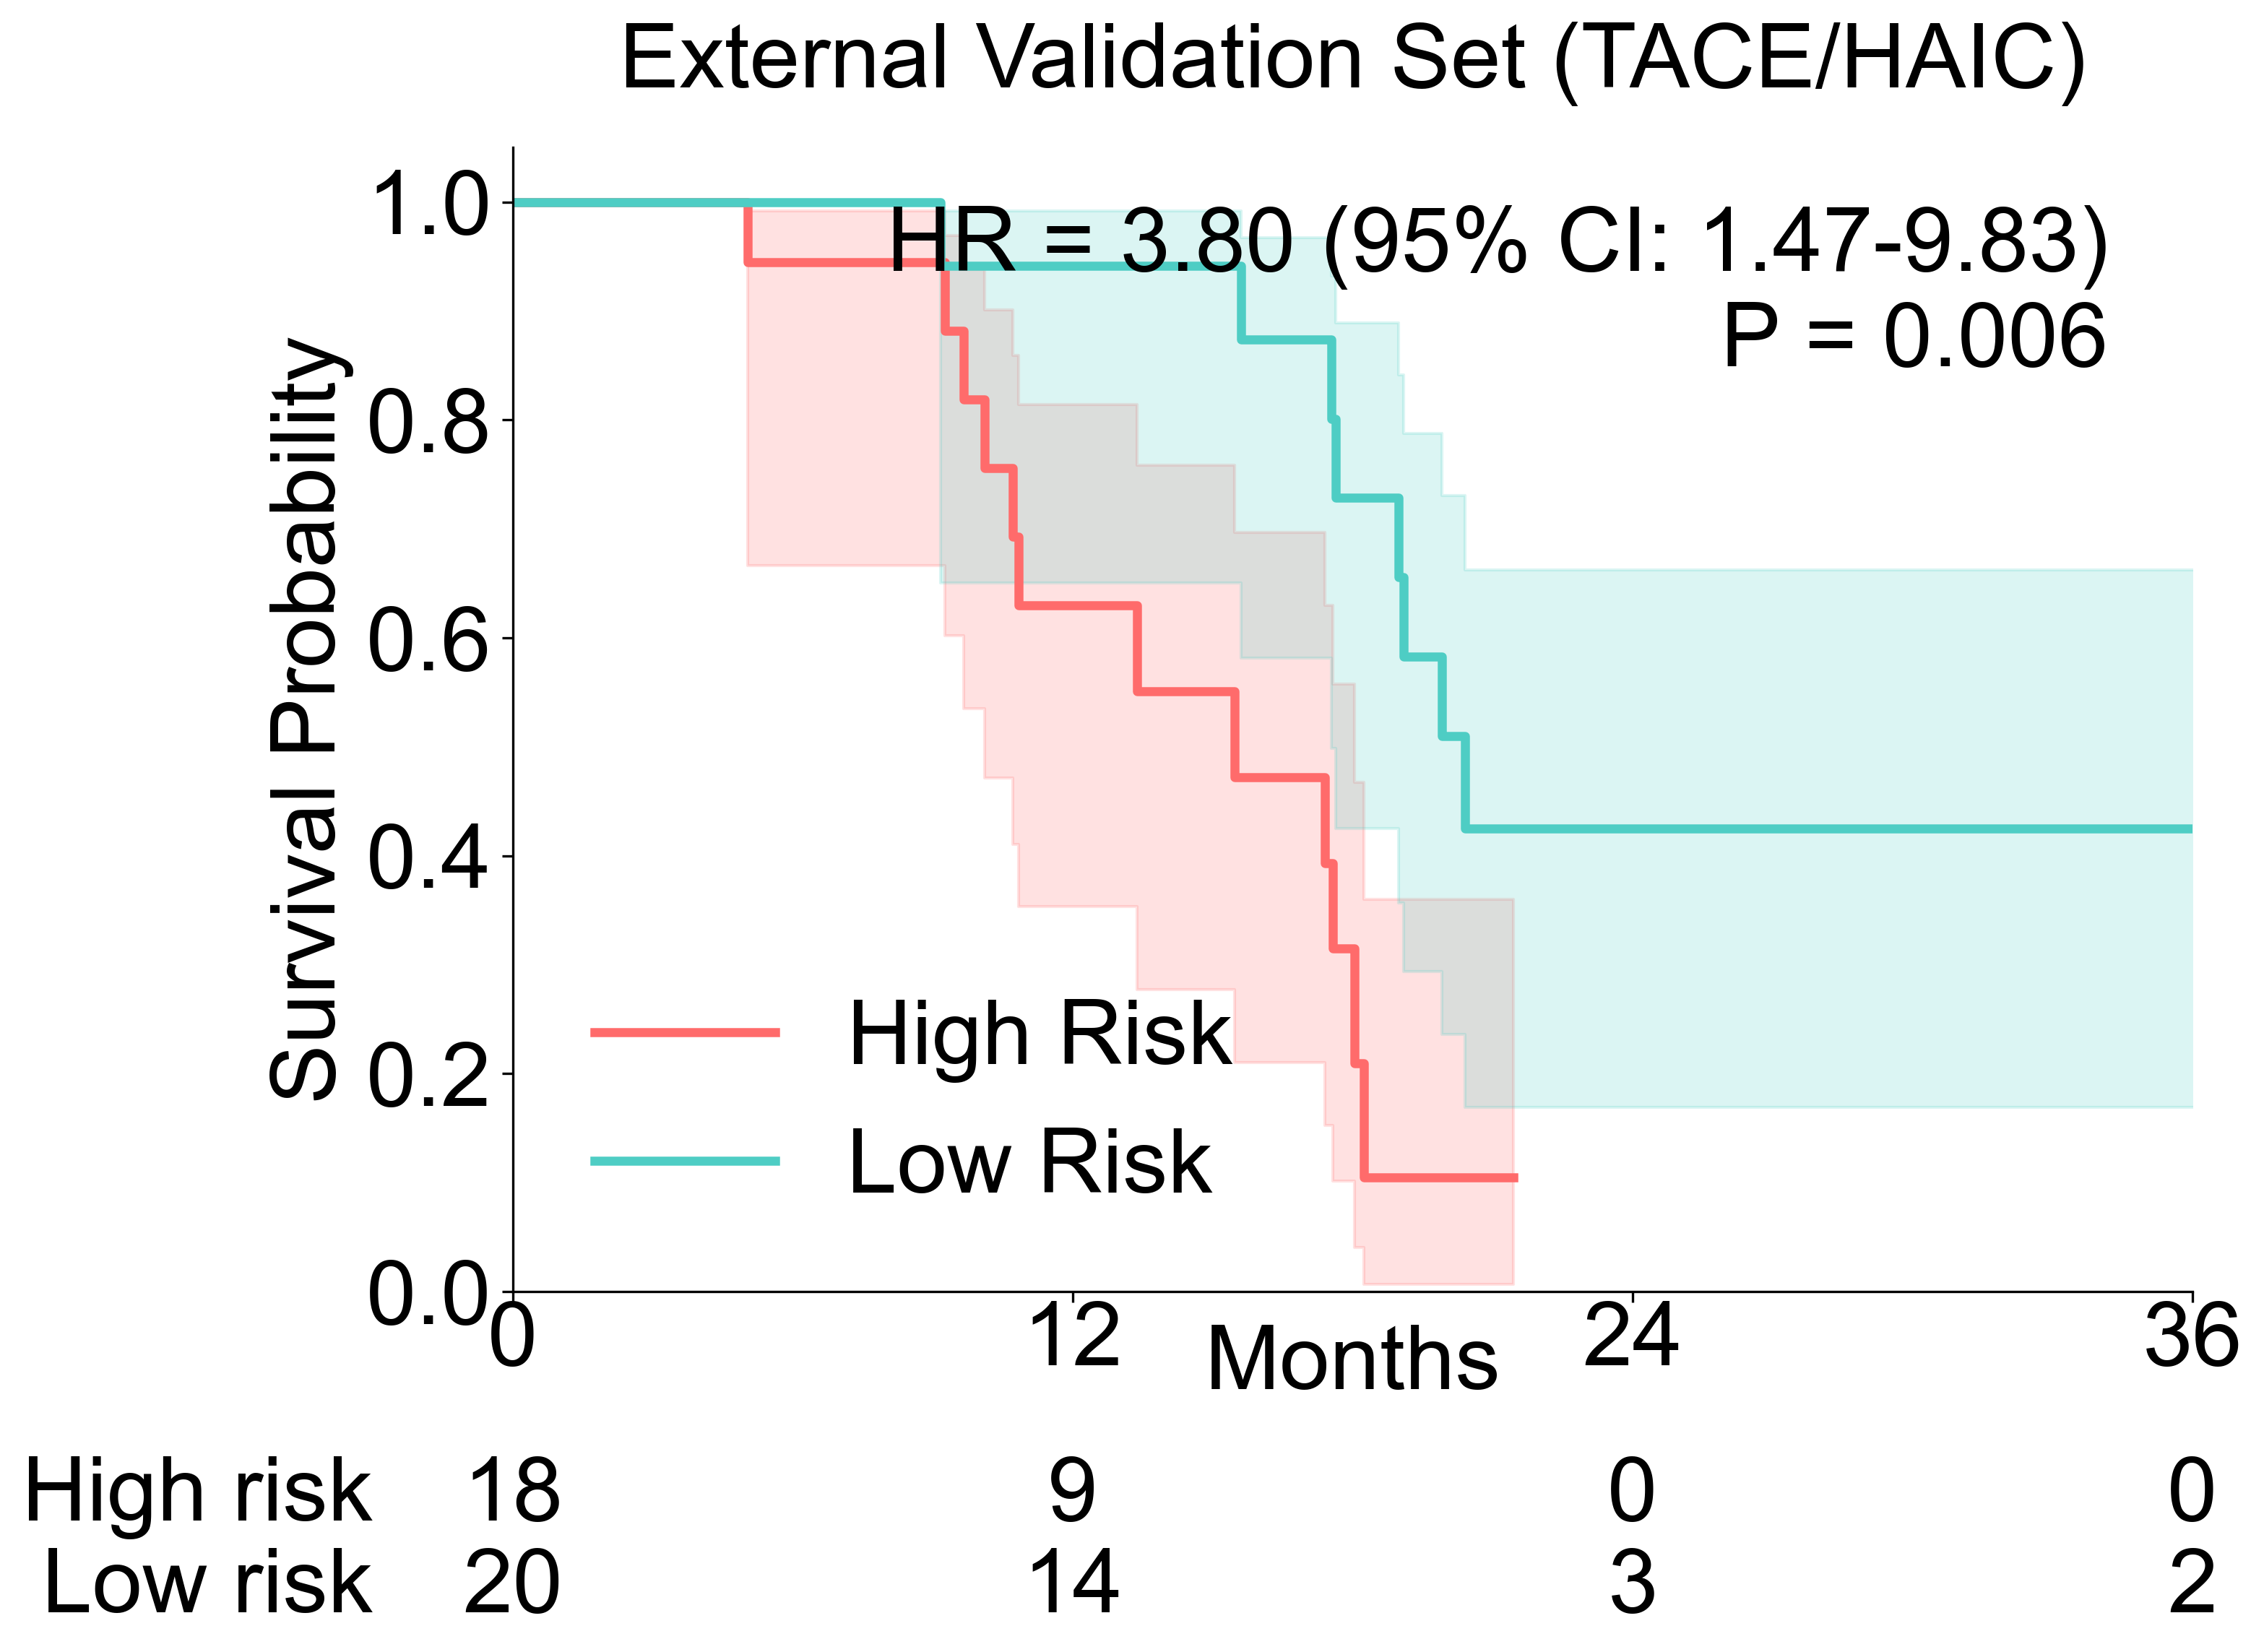

External Validation Set (TACE/HAIC) Log-rank Test: P-value = 3.6819e-03
External Validation Set (TACE/HAIC) Cox Regression: HR = 3.80 (95% CI: 1.47-9.83), P = 0.006
------------------------------------------------------------


In [9]:
# survival risk stratification for TACE/HAIC subgroup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import warnings

warnings.filterwarnings("ignore")

# Load modality 2 survival data and external validation data
file_mod2 = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
data_mod2 = pd.read_excel(file_mod2)
ext_file_mod2 = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
ext_mod2 = pd.read_excel(ext_file_mod2)

# From modality 2 data, get T1H2TH0 information
T1H2TH0_train = data_mod2['T1H2TH0'].iloc[:len(X_train1)].values
T1H2TH0_test = data_mod2['T1H2TH0'].iloc[len(X_train1):].values
T1H2TH0_ext = ext_mod2['T1H2TH0'].values

# Update survival dataframe, adding T1H2TH0 information
df_train['T1H2TH0'] = T1H2TH0_train
df_test['T1H2TH0'] = T1H2TH0_test
df_ext['T1H2TH0'] = T1H2TH0_ext

# Get training set median fusion risk for cutoff calculation
median_cut = np.median(fusion_risk_train)
print(f"Training set fusion risk median cut-off: {median_cut:.4f}")

def plot_km_by_TACE_HAIC(df, dataset_name="Dataset", T1H2TH0_value=1, median_cut=None, save_pdf=True):
    """
    Plot KM curves stratified by TACE+HAIC status, automatically skip empty groups, use Arial font, and save as PDF.
    """
    TACE_HAIC_label = "TACE+HAIC" if T1H2TH0_value == 1 else "TACE/HAIC"
    colors = {'High': '#FF6B6B', 'Low': '#4ECDC4'}

    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.sans-serif'] = ['Arial']

    # Filter specific group data
    df_TACE_HAIC = df[df['T1H2TH0'] == T1H2TH0_value].copy()
    df_TACE_HAIC['time_months'] = pd.to_numeric(df_TACE_HAIC['time'], errors='coerce') / 30.44
    df_TACE_HAIC['risk_group'] = np.where(df_TACE_HAIC['fusion_risk'] >= median_cut, 'High', 'Low')
    df_TACE_HAIC['risk_flag'] = (df_TACE_HAIC['risk_group'] == 'High').astype(int)

    kmf_high = KaplanMeierFitter()
    kmf_low = KaplanMeierFitter()

    mask_high = df_TACE_HAIC["risk_group"] == "High"
    mask_low = df_TACE_HAIC["risk_group"] == "Low"
    T_high = pd.to_numeric(df_TACE_HAIC.loc[mask_high, "time_months"], errors='coerce').dropna()
    E_high = pd.to_numeric(df_TACE_HAIC.loc[mask_high, "event"], errors='coerce').dropna()
    T_low = pd.to_numeric(df_TACE_HAIC.loc[mask_low, "time_months"], errors='coerce').dropna()
    E_low = pd.to_numeric(df_TACE_HAIC.loc[mask_low, "event"], errors='coerce').dropna()

    # Handle empty groups
    if len(T_high) == 0 or len(T_low) == 0:
        print(f"[{dataset_name}][{TACE_HAIC_label}] Number of samples in one risk group is 0, skip plotting.")
        return

    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

    kmf_high.fit(T_high, event_observed=E_high, label="High Risk")
    kmf_low.fit(T_low, event_observed=E_low, label="Low Risk")

    ax = kmf_high.plot(ci_show=True,
                       color=colors['High'],
                       ci_alpha=0.2,
                       linewidth=3,
                       show_censors=False,
                       ax=ax)
    ax = kmf_low.plot(ax=ax,
                      ci_show=True,
                      color=colors['Low'],
                      ci_alpha=0.2,
                      linewidth=3,
                      show_censors=False)

    times = [0, 12, 24, 36]
    high_risk_counts = [sum(T_high >= t) for t in times]
    low_risk_counts = [sum(T_low >= t) for t in times]

    from lifelines.utils import ConvergenceWarning
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    lr_result = logrank_test(T_high, T_low, event_observed_A=E_high, event_observed_B=E_low)

    df_cph = df_TACE_HAIC.loc[mask_high | mask_low, ["time_months", "event", "risk_flag"]].dropna()
    cph = CoxPHFitter()
    cph.fit(df_cph, duration_col="time_months", event_col="event")
    hr = cph.hazard_ratios_["risk_flag"]
    ci_lower = cph.summary.loc["risk_flag", "exp(coef) lower 95%"]
    ci_upper = cph.summary.loc["risk_flag", "exp(coef) upper 95%"]
    p_value = cph.summary.loc["risk_flag", "p"]

    if p_value < 0.001:
        p_text = "P < 0.001"
    else:
        p_text = f"P = {p_value:.3f}"

    textstr = f"HR = {hr:.2f} (95% CI: {ci_lower:.2f}-{ci_upper:.2f})\n{p_text}"
    plt.text(0.95, 0.95, textstr,
             transform=ax.transAxes,
             horizontalalignment='right',
             verticalalignment='top',
             bbox=dict(facecolor='none', edgecolor='none', pad=2.5),
             fontsize=30, family="Arial")

    plt.title(f"{dataset_name} ({TACE_HAIC_label})",
              fontsize=30,
              pad=20,
              family="Arial")
    plt.xlabel("Months", fontsize=30, family="Arial")
    plt.ylabel("Survival Probability", fontsize=30, family="Arial")

    plt.legend(
        loc='lower left',
        frameon=True,
        edgecolor='none',
        shadow=False,
        fontsize=30,
        facecolor='none',
        framealpha=0
    )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=18)
    plt.ylim(0, 1.05)
    plt.xticks(times, fontsize=30)
    plt.yticks(fontsize=30)
    plt.subplots_adjust(bottom=0.22)
    ax.set_xticklabels([])

    for i, t in enumerate(times):
        plt.text(t, -0.08, str(t),
                 ha='center', va='bottom',
                 transform=ax.get_xaxis_transform(),
                 fontsize=30, family="Arial")
    x_min = min(times)
    time_interval = times[1] - times[0]
    label_x_pos = x_min - time_interval/4
    plt.text(label_x_pos, -0.18, "High risk",
             ha='right', va='center',
             transform=ax.get_xaxis_transform(),
             fontsize=30, family="Arial",
             bbox=dict(facecolor='none', edgecolor='none', pad=2.5))

    plt.text(label_x_pos, -0.26, "Low risk",
             ha='right', va='center',
             transform=ax.get_xaxis_transform(),
             fontsize=30, family="Arial",
             bbox=dict(facecolor='none', edgecolor='none', pad=2.5))
    for i, (high_count, low_count) in enumerate(zip(high_risk_counts, low_risk_counts)):
        plt.text(times[i], -0.18, str(high_count),
                 ha='center', va='center',
                 transform=ax.get_xaxis_transform(),
                 fontsize=30, family="Arial")
        plt.text(times[i], -0.26, str(low_count),
                 ha='center', va='center',
                 transform=ax.get_xaxis_transform(),
                 fontsize=30, family="Arial")
    plt.xlim(times[0], times[-1])
    if save_pdf:
        pdfname = f"KM_{dataset_name.replace(' ', '_')}_TACE_HAIC_{TACE_HAIC_label.replace('+', 'plus').replace('/', '_')}.pdf"
        plt.savefig(pdfname, format="pdf", bbox_inches="tight")
        print(f"Saved: {pdfname}")
    plt.show()
    print(f"{dataset_name} ({TACE_HAIC_label}) Log-rank Test: P-value = {lr_result.p_value:.4e}")
    print(f"{dataset_name} ({TACE_HAIC_label}) Cox Regression: HR = {hr:.2f} (95% CI: {ci_lower:.2f}-{ci_upper:.2f}), {p_text}")
    print("-" * 60)

print("=== Training Set (TACE+HAIC) ===")
plot_km_by_TACE_HAIC(df_train, dataset_name="Training Set", T1H2TH0_value=1, median_cut=median_cut)
print("\n=== Training Set (TACE/HAIC) ===")
plot_km_by_TACE_HAIC(df_train, dataset_name="Training Set", T1H2TH0_value=0, median_cut=median_cut)
print("\n=== Test Set (TACE+HAIC) ===")
plot_km_by_TACE_HAIC(df_test, dataset_name="Test Set", T1H2TH0_value=1, median_cut=median_cut)
print("\n=== Test Set (TACE/HAIC) ===")
plot_km_by_TACE_HAIC(df_test, dataset_name="Test Set", T1H2TH0_value=0, median_cut=median_cut)
print("\n=== External Validation Set (TACE+HAIC) ===")
plot_km_by_TACE_HAIC(df_ext, dataset_name="External Validation Set", T1H2TH0_value=1, median_cut=median_cut)
print("\n=== External Validation Set (TACE/HAIC) ===")
plot_km_by_TACE_HAIC(df_ext, dataset_name="External Validation Set", T1H2TH0_value=0, median_cut=median_cut)

Fusion weights: 0.375 (imaging), 0.625 (clinical)
Fusion model SHAP values shape: (34, 20)
SHAP DataFrame shape: (34, 20)


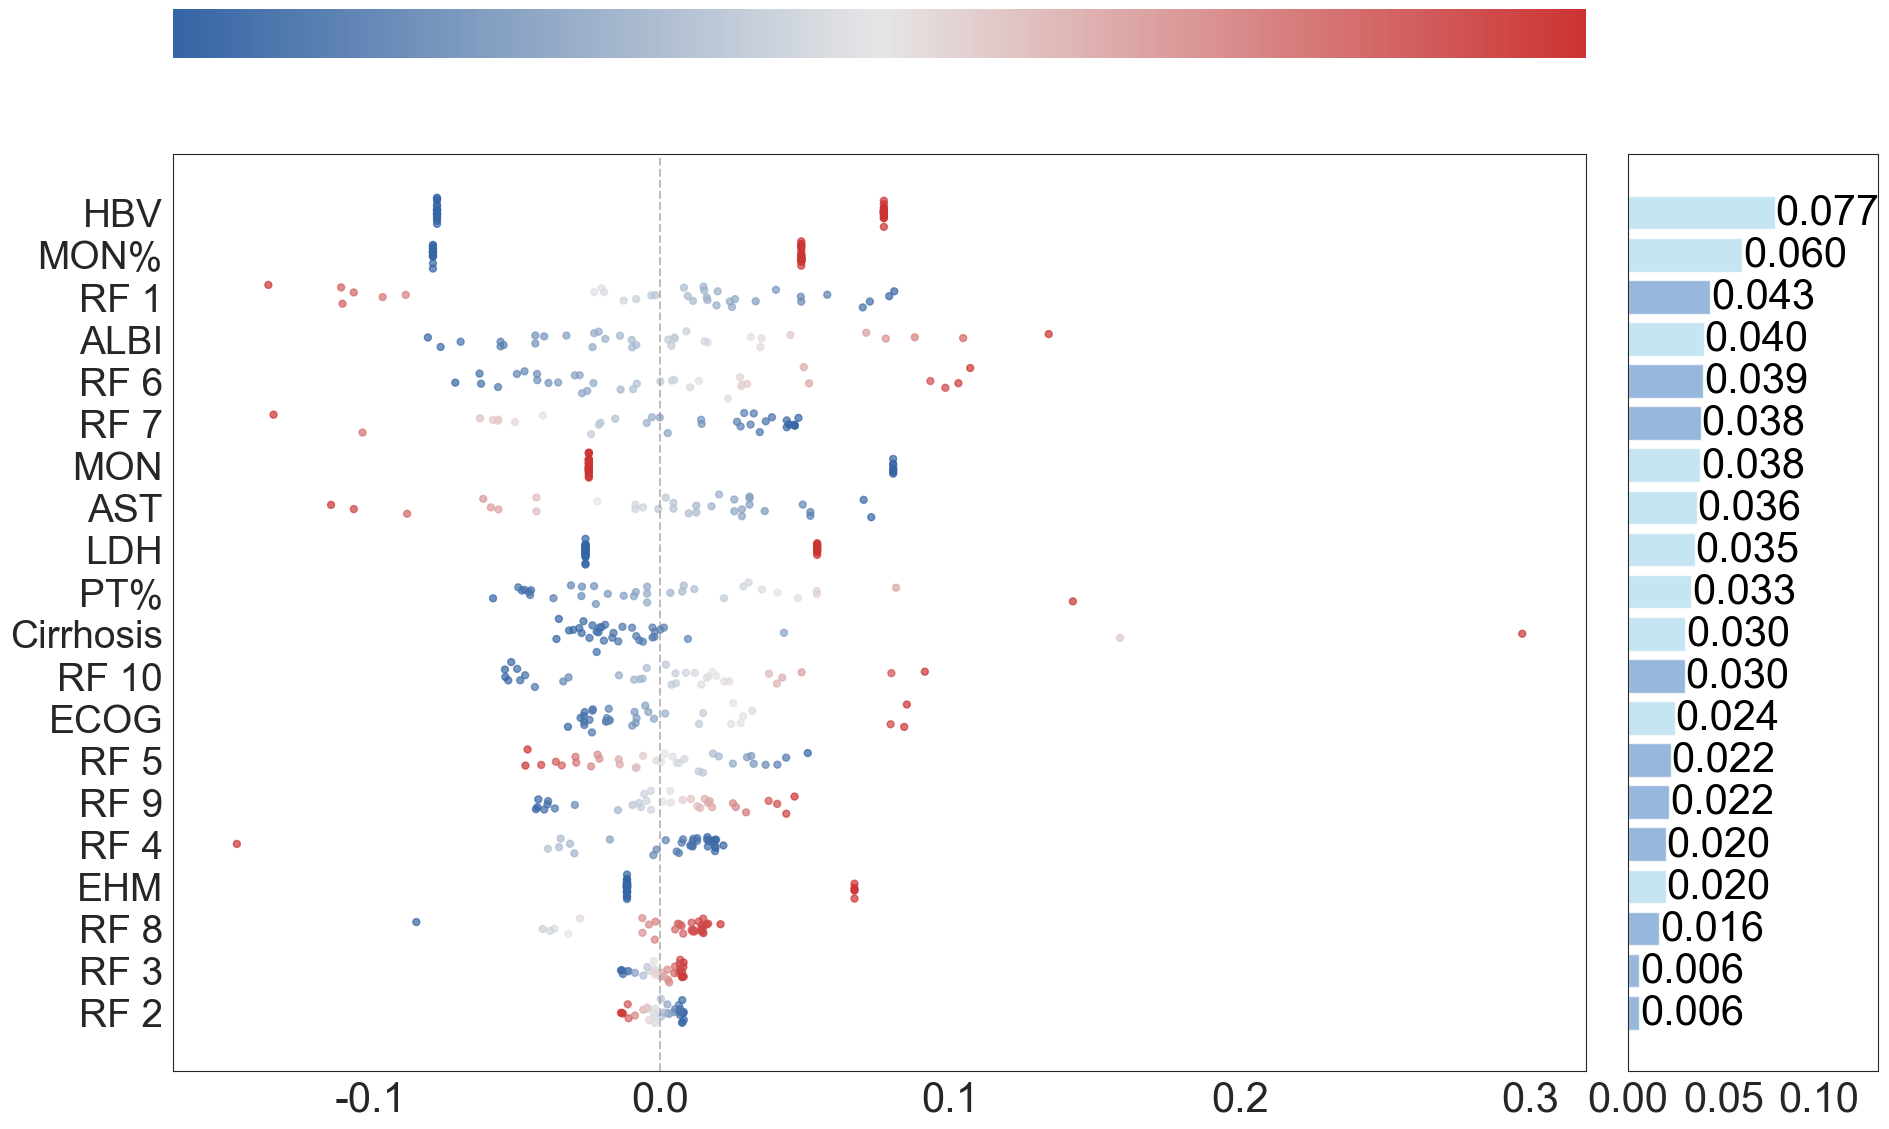

 SHAP visualization finished and saved to survival_shap_fusion.pdf


In [109]:
# SHAP for the late-fusion survival model
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import KDTree
from sksurv.metrics import concordance_index_censored

# ---------------------------------------------------------------------
# Assumes:
#   - X_train1, X_test1: imaging data (features)
#   - X_train2, X_test2: clinical data (features)
#   - y_train, y_test: survival outcome with fields "fstat", "lenfol"
#   - best_svm_model1: imaging model
#   - best_svm_model2: clinical model
#   - selected_features_mod1: imaging feature names (array-like)
#   - selected_features_mod2: clinical feature names (array-like)
# ---------------------------------------------------------------------

def visualize_shap(values, X_data, feature_names, title, output_filename, imaging_prefix="RF", clinical_prefix=None):
    """
    values: SHAP values (n_samples, n_features)
    X_data: original feature array (n_samples, n_features)
    feature_names: list of feature names (length = n_features)
    imaging_prefix: prefix for imaging features, default 'RF'
    clinical_prefix: prefix for clinical features, default None (do not rename)
    """
    # Set global font
    plt.rcParams["font.sans-serif"] = ["Arial"]
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["axes.unicode_minus"] = False

    n_features = len(feature_names)
    # Generate display feature names if needed
    if imaging_prefix is not None and clinical_prefix is None:
        # imaging features: use RF abbreviation, clinical features: original name
        # Determine if unimodal or fusion
        if n_features == len(selected_features_mod1):
            # imaging only
            imaging_features_abbr = [f"{imaging_prefix} {i+1}" for i in range(n_features)]
            pd.DataFrame({
                f"{imaging_prefix} Abbreviation": imaging_features_abbr,
                "Original Imaging Feature Name": feature_names
            }).to_csv(f"{output_filename.replace('.pdf', '_rf_abbreviation.csv')}", index=False)
            display_names = imaging_features_abbr
            clinical_cut = 0
        elif n_features == len(selected_features_mod1) + len(selected_features_mod2):
            # fusion
            imaging_features_abbr = [f"{imaging_prefix} {i+1}" for i in range(len(selected_features_mod1))]
            clinical_features_names = list(selected_features_mod2)
            pd.DataFrame({
                f"{imaging_prefix} Abbreviation": imaging_features_abbr,
                "Original Imaging Feature Name": list(selected_features_mod1)
            }).to_csv(f"{output_filename.replace('.pdf', '_rf_abbreviation.csv')}", index=False)
            display_names = imaging_features_abbr + clinical_features_names
            clinical_cut = len(imaging_features_abbr)
        else:
            # fallback: do not rename
            display_names = feature_names
            clinical_cut = 0
    elif imaging_prefix is None and clinical_prefix is None:
        # clinical only
        display_names = feature_names
        clinical_cut = len(display_names)
    else:
        display_names = feature_names
        clinical_cut = 0

    shap_df = pd.DataFrame(values, columns=display_names)
    X_df = pd.DataFrame(X_data, columns=display_names)
    print(f"SHAP DataFrame shape: {shap_df.shape}")

    # Set up visualization parameters
    jitter_scale = 0.15
    distance_threshold = 0.05
    custom_cmap = LinearSegmentedColormap.from_list("custom", ["#3465A4", "#E6E6E6", "#CC3333"])

    # Compute mean absolute SHAP values and sort features descending
    mean_abs_shap_values = shap_df.abs().mean().sort_values(ascending=False)
    sorted_features = mean_abs_shap_values.index

    # Build plotting DataFrame with normalized feature values
    plot_data = []
    for feature in sorted_features:
        for shap_val, feat_val in zip(shap_df[feature], X_df[feature]):
            norm_val = (feat_val - X_df[feature].min()) / (X_df[feature].max() - X_df[feature].min() + 1e-8)
            plot_data.append({"Feature": feature, "SHAP Value": shap_val, "Normalized Value": norm_val})
    plot_df = pd.DataFrame(plot_data)

    # Build a KDTree on SHAP values for jittering
    all_points = plot_df["SHAP Value"].values.reshape(-1, 1)
    tree = KDTree(all_points)

    # Color grouping
    if n_features == len(selected_features_mod1) + len(selected_features_mod2):
        n_imaging = len(selected_features_mod1)
        n_clinical = len(selected_features_mod2)
    elif n_features == len(selected_features_mod1):
        n_imaging = n_features
        n_clinical = 0
    elif n_features == len(selected_features_mod2):
        n_imaging = 0
        n_clinical = n_features
    else:
        n_imaging = n_features // 2
        n_clinical = n_features - n_imaging

    feature_groups = {
        "Imaging": display_names[:n_imaging],
        "Clinical": display_names[n_imaging:]
    }
    group_colors = {"Imaging": "#6A9ACF", "Clinical": "#ABDAEC"}
    feature_colors = []
    for feature in sorted_features:
        assigned = "#cccccc"
        for group, feats in feature_groups.items():
            if feature in feats:
                assigned = group_colors.get(group, "#000000")
                break
        feature_colors.append(assigned)

    # Set up figure and grid layout, more compact color bar
    fig = plt.figure(figsize=(22, 12))
    gs = gridspec.GridSpec(2, 2, width_ratios=[0.85, 0.15], height_ratios=[0.05, 0.95])
    ax = plt.subplot(gs[1, 0])

    # Scatter plot: each feature's SHAP values with jitter on y-axis
    for i, feature in enumerate(sorted_features):
        subset = plot_df[plot_df["Feature"] == feature]
        shap_vals = subset["SHAP Value"].values
        jit = np.zeros(len(shap_vals))
        for idx, val in enumerate(shap_vals):
            if len(tree.query_ball_point([val], r=distance_threshold)) > 1:
                jit[idx] = np.random.normal(0, jitter_scale)
        ax.scatter(subset["SHAP Value"], jit + i, c=subset["Normalized Value"],
                   cmap=custom_cmap, s=25, alpha=0.7)

    ax.axvline(0, color="gray", linestyle="--", linewidth=1.5, alpha=0.5)
    ax.tick_params(axis='x', labelsize=20)
    # ax.set_xlabel("SHAP Value (Impact on Risk Score)", fontsize=20, family="Arial")
    # ax.set_ylabel("Features", fontsize=20, family="Arial")
    ax.set_yticks(range(len(sorted_features)))
    ax.set_yticklabels(sorted_features, fontsize=28, family="Arial")
    ax.invert_yaxis()
    ax.grid(False)
    plt.xticks(fontsize=30)
    # Bar chart showing mean(|SHAP value|)
    ax_bar = plt.subplot(gs[1, 1], sharey=ax)
    bars = ax_bar.barh(range(len(sorted_features)), mean_abs_shap_values.values,
                       color=feature_colors, alpha=0.7)
    ax_bar.set_xlim(0, mean_abs_shap_values.max() * 1.7)
    for bar, value in zip(bars, mean_abs_shap_values.values):
        ax_bar.text(value + mean_abs_shap_values.max() * 0.005,
                    bar.get_y() + bar.get_height() / 2,
                    f"{value:.3f}", va="center", fontsize=30, color="black", family="Arial")
    ax_bar.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    ax_bar.grid(False)
    plt.xticks(fontsize=30)
    # Colorbar for scatter plot, compact without any text
    cax = plt.subplot(gs[0, 0])
    sm = plt.cm.ScalarMappable(cmap=custom_cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.xaxis.set_ticks([])
    # Remove colorbar title and min/max labels
    cbar.ax.set_title("")
    cbar.ax.set_xticklabels([])
    # Do not display low/high labels
    plt.subplots_adjust(top=0.995, wspace=0.05)
    # plt.suptitle(title, fontsize=24, family="Arial")
    plt.savefig(output_filename, format="pdf", bbox_inches="tight", dpi=1200)
    plt.show()
    print(f"{title} SHAP visualization finished and saved to {output_filename}")


# ========== SHAP for Fusion Survival Model (Imaging + Clinical) ==========
d1 = X_test1.shape[1]
d2 = X_test2.shape[1]
X_fusion_test = np.concatenate((X_test1, X_test2), axis=1)
fusion_feature_names_abbr = [f"RF {i+1}" for i in range(len(selected_features_mod1))] + list(selected_features_mod2)
pd.DataFrame({
    "RF Abbreviation": [f"RF {i+1}" for i in range(len(selected_features_mod1))],
    "Original Imaging Feature Name": list(selected_features_mod1)
}).to_csv("survival_shap_fusion_rf_abbreviation.csv", index=False)

# Compute weights using training set predictions
pred1_train = best_svm_model1.predict(X_train1)
pred2_train = best_svm_model2.predict(X_train2)
cindex1 = concordance_index_censored(y_train["fstat"], y_train["lenfol"], pred1_train)[0]
cindex2 = concordance_index_censored(y_train["fstat"], y_train["lenfol"], pred2_train)[0]
tau = 0.1
w1 = np.exp((cindex1 - 0.5) / tau)
w2 = np.exp((cindex2 - 0.5) / tau)
total = w1 + w2
norm_w1 = w1 / total
norm_w2 = w2 / total
print(f"Fusion weights: {norm_w1:.3f} (imaging), {norm_w2:.3f} (clinical)")

def fusion_model_wrapper(X):
    X1_part = X[:, :d1]
    X2_part = X[:, d1:]
    risk1 = best_svm_model1.predict(X1_part)
    risk2 = best_svm_model2.predict(X2_part)
    return norm_w1 * risk1 + norm_w2 * risk2

explainer_fusion = shap.Explainer(fusion_model_wrapper, X_fusion_test)
shap_values_fusion_obj = explainer_fusion(X_fusion_test)
shap_values_fusion = shap_values_fusion_obj.values
print("Fusion model SHAP values shape:", shap_values_fusion.shape)
visualize_shap(shap_values_fusion, X_fusion_test, fusion_feature_names_abbr,
               "", "survival_shap_fusion.pdf", imaging_prefix="RF")

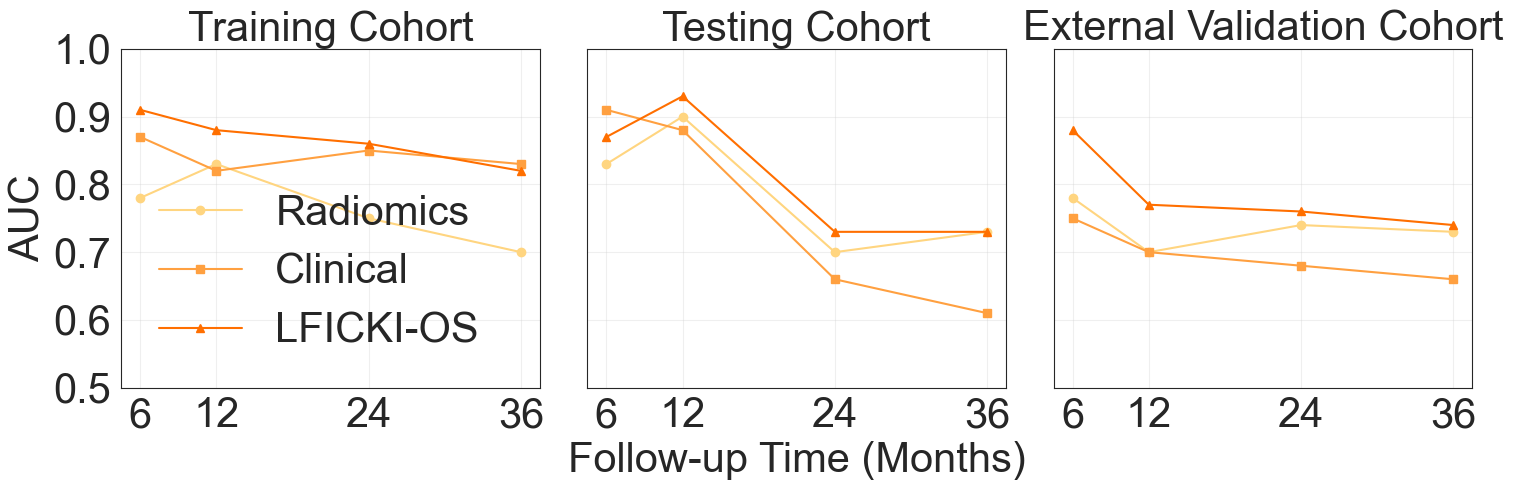

In [81]:
# Performence AUC-T
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame, RC changed to Late Fusion
data = {
    'Model': ['Radiomics', 'Radiomics', 'Radiomics', 'Radiomics',
              'Clinical', 'Clinical', 'Clinical', 'Clinical',
              'LFICKI-OS', 'LFICKI-OS', 'LFICKI-OS', 'LFICKI-OS'] * 3,
    'Time': [6, 12, 24, 36] * 9,
    'AUC': [0.78, 0.83, 0.75, 0.70,  # Radiomics Training
            0.87, 0.82, 0.85, 0.83,  # Clinical Training
            0.91, 0.88, 0.86, 0.82,  # Late Fusion Training
            0.83, 0.90, 0.70, 0.73,  # Radiomics Testing
            0.91, 0.88, 0.66, 0.61,  # Clinical Testing
            0.87, 0.93, 0.73, 0.73,  # Late Fusion Testing
            0.78, 0.70, 0.74, 0.73,  # Radiomics External
            0.75, 0.70, 0.68, 0.66,  # Clinical External
            0.88, 0.77, 0.76, 0.74], # Late Fusion External
    'Cohort': ['Training'] * 12 + ['Testing'] * 12 + ['External Validation'] * 12
}

df = pd.DataFrame(data)

# Set global font to Arial
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 24
plt.rcParams["figure.titlesize"] = 22

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Orange gradient color map
color_map = {
    'Radiomics': '#FFD580',      # Light orange
    'Clinical': '#FFA040',       # Orange
    'LFICKI-OS': '#FF6F00'     # Dark orange
}
marker_map = {
    'Radiomics': '-o',
    'Clinical': '-s',
    'LFICKI-OS': '-^'
}

# Create three subplots
for i, (ax, cohort) in enumerate(zip(axes, ['Training', 'Testing', 'External Validation'])):
    for model in ['Radiomics', 'Clinical', 'LFICKI-OS']:
        style = marker_map[model]
        data_sub = df[(df['Cohort'] == cohort) & (df['Model'] == model)]
        ax.plot(data_sub['Time'], data_sub['AUC'], style, label=model, color=color_map[model])

    ax.set_title(f'{cohort} Cohort', fontsize=30, fontfamily="Arial")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.5, 1.0)
    ax.set_xticks([6, 12, 24, 36])
    ax.set_xticklabels([6, 12, 24, 36], fontsize=30, fontfamily="Arial")
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

    if i == 0:
        ax.set_ylabel('AUC', fontsize=30, fontfamily="Arial")
        ax.legend(loc='lower left', fontsize=30, frameon=False)
        ax.tick_params(axis='y', labelsize=30)  # Keep left y-axis ticks
    else:
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelleft=False)  # Hide right y-axis ticks

    if i == 1:
        ax.set_xlabel('Follow-up Time (Months)', fontsize=30, fontfamily="Arial")
    else:
        ax.set_xlabel('')

plt.tight_layout()
plt.savefig("survival_auc_t_three_modalities.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

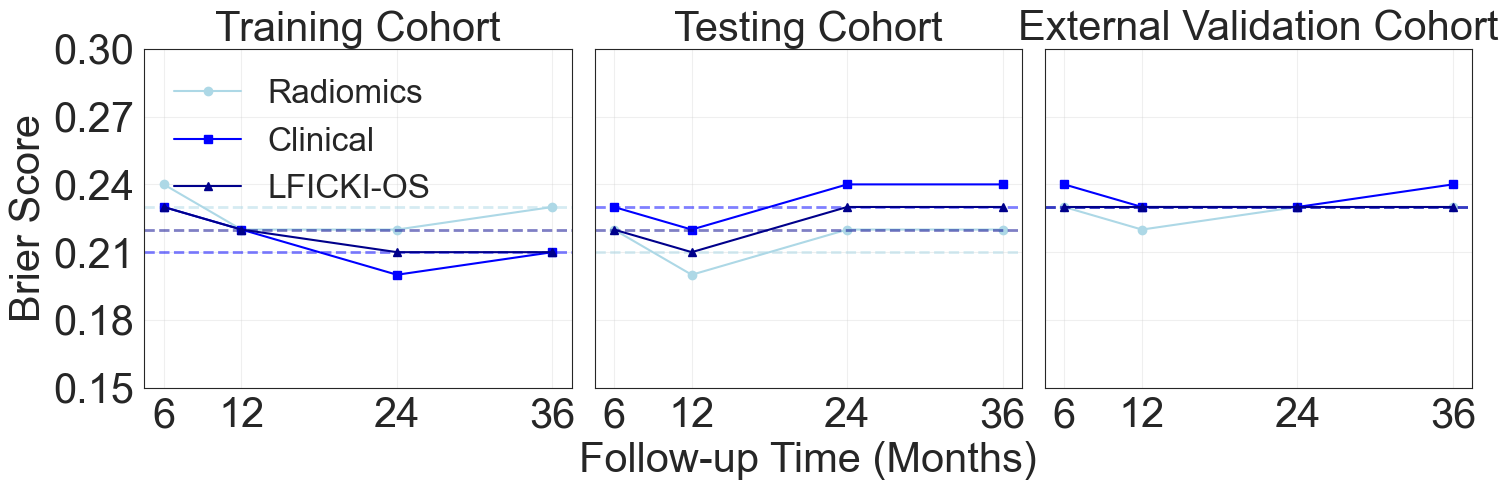

In [86]:
# Performence Brier score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame, RC changed to Late Fusion
data = {
    'Model': ['Radiomics', 'Radiomics', 'Radiomics', 'Radiomics',
              'Clinical', 'Clinical', 'Clinical', 'Clinical',
              'LFICKI-OS', 'LFICKI-OS', 'LFICKI-OS', 'LFICKI-OS'] * 3,
    'Time': [6, 12, 24, 36] * 9,
    'Brier': [0.24, 0.22, 0.22, 0.23,  # Radiomics Training
              0.23, 0.22, 0.20, 0.21,  # Clinical Training
              0.23, 0.22, 0.21, 0.21,  # Late Fusion Training
              0.22, 0.20, 0.22, 0.22,  # Radiomics Testing
              0.23, 0.22, 0.24, 0.24,  # Clinical Testing
              0.22, 0.21, 0.23, 0.23,  # Late Fusion Testing
              0.23, 0.22, 0.23, 0.23,  # Radiomics External
              0.24, 0.23, 0.23, 0.24,  # Clinical External
              0.23, 0.23, 0.23, 0.23], # Late Fusion External
    'Cohort': ['Training'] * 12 + ['Testing'] * 12 + ['External Validation'] * 12
}

df = pd.DataFrame(data)

# Integrated Brier Scores, RC changed to Late Fusion
ibs = {
    'Training': {'Radiomics': 0.23, 'Clinical': 0.21, 'LFICKI-OS': 0.22},
    'Testing': {'Radiomics': 0.21, 'Clinical': 0.23, 'LFICKI-OS': 0.22},
    'External Validation': {'Radiomics': 0.23, 'Clinical': 0.23, 'LFICKI-OS': 0.23}
}

# Set global font to Arial
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["figure.titlesize"] = 22

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

color_map = {
    'Radiomics': 'lightblue',
    'Clinical': 'blue',
    'LFICKI-OS': 'darkblue'
}
marker_map = {
    'Radiomics': '-o',
    'Clinical': '-s',
    'LFICKI-OS': '-^'
}

for i, (ax, cohort) in enumerate(zip(axes, ['Training', 'Testing', 'External Validation'])):
    for model in ['Radiomics', 'Clinical', 'LFICKI-OS']:
        style = marker_map[model]
        data_sub = df[(df['Cohort'] == cohort) & (df['Model'] == model)]
        color = color_map[model]
        # Plot Brier Score over time
        ax.plot(data_sub['Time'], data_sub['Brier'], style, 
                label=f"{model}",
                color=color)
        # Plot Integrated Brier Score as horizontal line
        ax.axhline(y=ibs[cohort][model], color=color, linestyle='--', 
                   linewidth=2, alpha=0.5)

    ax.set_title(f'{cohort} Cohort', fontsize=30, fontfamily="Arial")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.15, 0.30)
    ax.set_xticks([6, 12, 24, 36])
    ax.set_xticklabels([6, 12, 24, 36], fontsize=30, fontfamily="Arial")
    ax.set_yticks([0.15, 0.18, 0.21, 0.24, 0.27, 0.30])
    
    if i == 0:
        ax.set_ylabel('Brier Score', fontsize=30, fontfamily="Arial")
        ax.legend(loc='upper left',  fontsize=24, frameon=False)
        ax.tick_params(axis='y', labelsize=30)
    else:
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelleft=False)  # Hide non-left y-axis ticks

    if i == 1:
        ax.set_xlabel('Follow-up Time (Months)', fontsize=30, fontfamily="Arial")
    else:
        ax.set_xlabel('')

plt.tight_layout()
plt.savefig("survival_brier_ibs_comparison.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

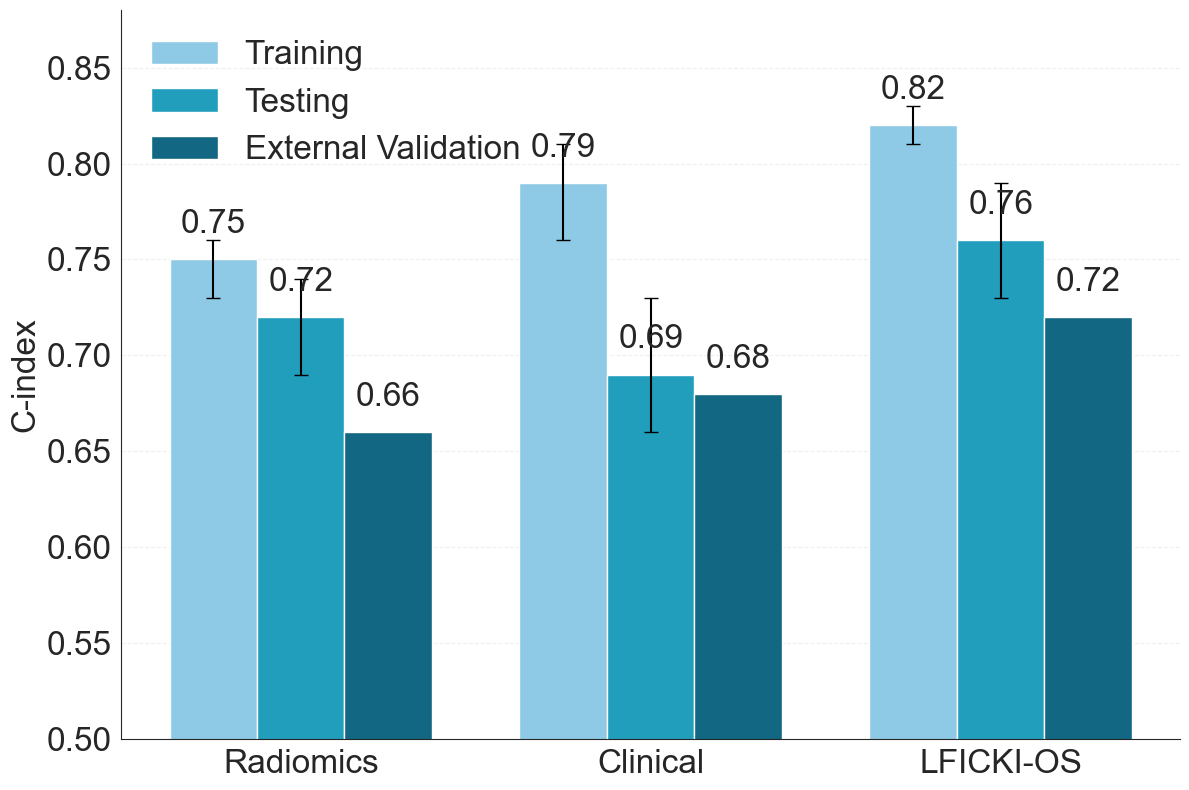

In [70]:
# Performence C-index
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame, CR changed to Late Fusion
data = {
    'Modality': ['Radiomics', 'Clinical', 'LFICKI-OS'],
    'Training': [0.75, 0.79, 0.82],
    'Training_CI_Lower': [0.73, 0.76, 0.81],
    'Training_CI_Upper': [0.76, 0.81, 0.83],
    'Testing': [0.72, 0.69, 0.76],
    'Testing_CI_Lower': [0.69, 0.66, 0.73],
    'Testing_CI_Upper': [0.74, 0.73, 0.79],
    'External_Validation': [0.66, 0.68, 0.72]
}
df = pd.DataFrame(data)

# Set global font to Arial
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 24
plt.rcParams["figure.titlesize"] = 22

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Set background style
sns.set_style("white")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set soft color scheme
colors = ['#8ecae6', '#219ebc', '#126782']

# Set group positions
x = np.arange(len(data['Modality']))
width = 0.25

# Calculate error bar values
training_yerr = np.array([
    np.array(data['Training']) - np.array(data['Training_CI_Lower']),
    np.array(data['Training_CI_Upper']) - np.array(data['Training'])
])
testing_yerr = np.array([
    np.array(data['Testing']) - np.array(data['Testing_CI_Lower']),
    np.array(data['Testing_CI_Upper']) - np.array(data['Testing'])
])

# Plot bars and error bars
training_bars = ax.bar(x - width, data['Training'], width, label='Training',
                      color=colors[0], yerr=training_yerr, capsize=5)
testing_bars = ax.bar(x, data['Testing'], width, label='Testing',
                     color=colors[1], yerr=testing_yerr, capsize=5)
external_bars = ax.bar(x + width, data['External_Validation'], width,
                      label='External Validation', color=colors[2])

# Add value labels
def add_value_labels(bars, fontsize=24):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=fontsize, fontfamily="Arial")

add_value_labels(training_bars)
add_value_labels(testing_bars)
add_value_labels(external_bars)

# Customize chart
# ax.set_xlabel('Model', fontsize=18, fontfamily="Arial")
ax.set_ylabel('C-index', fontsize=24, fontfamily="Arial")
# ax.set_title('C-index Comparison Across Different Models',
#              fontsize=22, pad=20, fontfamily="Arial")
ax.set_xticks(x)
ax.set_xticklabels(data['Modality'], fontsize=24, fontfamily="Arial")
ax.legend(fontsize=24, frameon=False)
plt.yticks(fontsize=24)
# Calculate y-axis limit
all_values = []
all_values.extend(data['Training'])
all_values.extend(data['Testing'])
all_values.extend(data['External_Validation'])
all_values.extend(data['Training_CI_Upper'])
all_values.extend(data['Testing_CI_Upper'])

ymin = 0.5
ymax = max(all_values) + 0.05
ax.set_ylim(ymin, ymax)

# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()

# Save as PDF
plt.savefig("survival_three_modalities_comparison.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

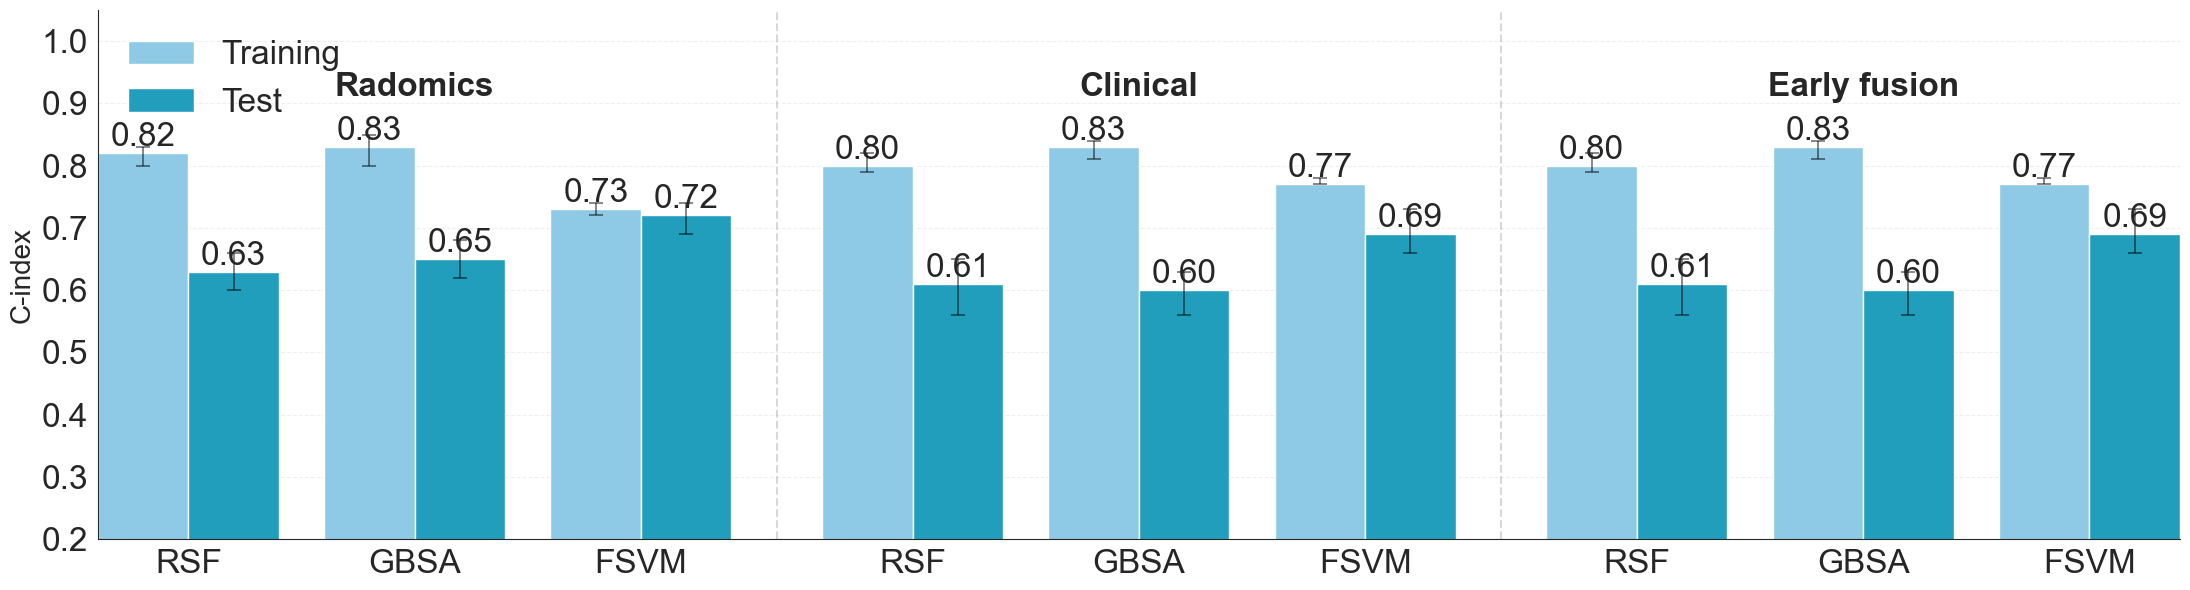

In [105]:
# Performence model selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data section, model type names in English, keep Early fusion as is
data = {
    'Model_Type': ['Radiomics']*6 + ['Clinical']*6 + ['Early fusion']*6,
    'Algorithm': ['RSF', 'GBSA', 'FastSurvivalSVM']*6,
    'Dataset': ['Test', 'Test', 'Test', 'Training', 'Training', 'Training']*3,
    'C-index': [0.63, 0.65, 0.72, 0.82, 0.83, 0.73,
                0.61, 0.60, 0.69, 0.80, 0.83, 0.77,
                0.61, 0.60, 0.69, 0.80, 0.83, 0.77],
    'CI_Lower': [0.60, 0.62, 0.69, 0.80, 0.80, 0.72,
                 0.56, 0.56, 0.66, 0.79, 0.81, 0.77,
                 0.56, 0.56, 0.66, 0.79, 0.81, 0.77],
    'CI_Upper': [0.66, 0.68, 0.74, 0.83, 0.85, 0.74,
                 0.65, 0.63, 0.73, 0.82, 0.84, 0.78,
                 0.65, 0.63, 0.73, 0.82, 0.84, 0.78]
}

df = pd.DataFrame(data)

# Set global font to Arial, font size consistent with previous plots
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 24
plt.rcParams["figure.titlesize"] = 22

plt.figure(figsize=(22, 6))
ax = plt.gca()

sns.set_style("white")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

colors = ['#8ecae6', '#219ebc']
n_algorithms = 3
width = 0.4

for i, model_type in enumerate(['Radiomics', 'Clinical', 'Early fusion']):
    train_data = df[(df['Model_Type'] == model_type) & (df['Dataset'] == 'Training')]
    test_data = df[(df['Model_Type'] == model_type) & (df['Dataset'] == 'Test')]
    x = np.arange(n_algorithms) + i * (n_algorithms + 0.2)
    # Training set
    train_bars = ax.bar(x - width/2, train_data['C-index'], width, 
                       label='Training' if i == 0 else "", color=colors[0])
    # Test set
    test_bars = ax.bar(x + width/2, test_data['C-index'], width,
                      label='Test' if i == 0 else "", color=colors[1])
    # Training error bars
    ax.errorbar(x - width/2, train_data['C-index'],
               yerr=[train_data['C-index'] - train_data['CI_Lower'],
                     train_data['CI_Upper'] - train_data['C-index']],
               fmt='none', color='black', capsize=5, alpha=0.6, elinewidth=1.1, capthick=1.1)
    # Test error bars
    ax.errorbar(x + width/2, test_data['C-index'],
               yerr=[test_data['C-index'] - test_data['CI_Lower'],
                     test_data['CI_Upper'] - test_data['C-index']],
               fmt='none', color='black', capsize=5, alpha=0.6, elinewidth=1.1, capthick=1.1)
    # Value labels
    for bars in [train_bars, test_bars]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=24, fontfamily="Arial")
    # Top model type label
    plt.text((i * (n_algorithms + 0.2) + 1), 0.90, model_type,
             ha='center', va='bottom', fontsize=24, fontweight='bold', fontfamily="Arial")
    # Vertical separation dashed line
    if i < 2:
        separation_x = x[-1] + width + 0.2
        plt.axvline(x=separation_x, color='gray', linestyle='--', alpha=0.3)

# Set x-axis labels
all_x = np.array([np.arange(n_algorithms) + i * (n_algorithms + 0.2) for i in range(3)]).flatten()
plt.xticks(all_x, ['RSF', 'GBSA', 'FSVM'] * 3, fontfamily="Arial", fontsize=24)

# plt.xlabel('Algorithm', fontsize=18, labelpad=10, fontfamily="Arial")
plt.ylabel('C-index', fontsize=20, fontfamily="Arial")
plt.yticks(fontsize=24)
# plt.title('C-index Comparison Across Different Models',
#           fontsize=22, pad=20, fontfamily="Arial")
plt.legend(loc='upper left', fontsize=24, frameon=False)

plt.ylim(0.2, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xlim(all_x[0] - width, all_x[-1] + width)
plt.tight_layout()

# Save as PDF
plt.savefig("survival_multimodal_comparison.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
# correlation matrix
from scipy.stats import pearsonr
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def create_abbreviated_feature_names(radiomic_features, clinical_features):
    """
    Automatically abbreviate radiomic features as RF 1,2,...,
    keep clinical feature names unchanged, and return a mapping DataFrame.
    """
    radiomic_features = list(radiomic_features)
    clinical_features = list(clinical_features)
    radiomic_short = [f"RF {i+1}" for i in range(len(radiomic_features))]
    feature_name_abbr = radiomic_short + clinical_features
    abbr_df = pd.DataFrame({
        "Radiomic Abbreviation": radiomic_short,
        "Original Radiomic Feature Name": radiomic_features
    })
    return feature_name_abbr, abbr_df, radiomic_short

def plot_fusion_correlation_matrix(X1_train_s, X2_train_s, selected_features_mod1, selected_features_mod2):
    """
    Plot the correlation matrix for the two modalities in the fusion model.
    Radiomic features are automatically abbreviated as RF, Arial font, larger font size,
    only keep the last row and first column axis labels.
    """
    # Set global font
    plt.rcParams["font.sans-serif"] = ["Arial"]
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["axes.unicode_minus"] = False

    # Abbreviate feature names: radiomics as RF, clinical features as is
    all_features, radiomic_df, radiomic_short = create_abbreviated_feature_names(
        selected_features_mod1, selected_features_mod2
    )
    # Save mapping table
    radiomic_df.to_csv("fusion_radiomic_feature_abbreviation.csv", index=False)

    # Concatenate data
    df = pd.DataFrame(np.hstack([X1_train_s, X2_train_s]),
                     columns=all_features)
    n = len(df.columns)
    
    # Calculate correlation matrix and p-values
    corr = df.corr()
    p_values = pd.DataFrame(np.zeros((n, n)), columns=df.columns, index=df.columns)
    for i in range(n):
        for j in range(n):
            if i != j:
                _, p = pearsonr(df.iloc[:, i], df.iloc[:, j])
                p_values.iloc[i, j] = p

    # Create figure
    fig, axes = plt.subplots(n, n, figsize=(2.3 * n, 2.3 * n))

    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            if i == j:
                # Diagonal: plot histogram
                sns.histplot(df.iloc[:, i], kde=True, ax=ax)
                ax.set_title(df.columns[i], fontsize=18, pad=6, family="Arial")
            elif i > j:
                # Lower triangle: plot scatter plot with fit line and confidence interval
                sns.scatterplot(x=df.iloc[:, j], y=df.iloc[:, i], ax=ax, edgecolor=None)
                X = sm.add_constant(df.iloc[:, j])
                model = sm.OLS(df.iloc[:, i], X).fit()
                x_values = np.linspace(df.iloc[:, j].min(), df.iloc[:, j].max(), 100)
                X_pred = sm.add_constant(x_values)
                y_pred = model.predict(X_pred)
                conf_int_pred = model.get_prediction(X_pred).conf_int()
                ax.plot(x_values, y_pred, color="red")
                ax.fill_between(x_values, conf_int_pred[:, 0], conf_int_pred[:, 1], 
                              color="blue", alpha=0.2)
            else:
                # Upper triangle: plot heatmap and significance annotation
                sns.heatmap(pd.DataFrame([[corr.iloc[i, j]]]), 
                          cmap=sns.diverging_palette(240, 10, as_cmap=True),
                          cbar=False, annot=True, fmt=".2f", square=True, 
                          ax=ax, vmin=-1, vmax=1,
                          annot_kws={"size": 22, "family": "Arial"})
                # Significance annotation
                p_val = p_values.iloc[i, j]
                if p_val < 0.001:
                    ax.text(0.5, 0.8, "***", color="black", ha="center", 
                           va="center", transform=ax.transAxes, fontsize=16, family="Arial")
                elif p_val < 0.01:
                    ax.text(0.5, 0.8, "**", color="black", ha="center", 
                           va="center", transform=ax.transAxes, fontsize=16, family="Arial")
                elif p_val < 0.05:
                    ax.text(0.5, 0.8, "*", color="black", ha="center", 
                           va="center", transform=ax.transAxes, fontsize=16, family="Arial")

            # Set axis labels: only keep last row and first column
            if i < n - 1:
                ax.set_xticks([])
                ax.set_xticklabels([])
            else:
                ax.set_xticks([0.5])
                ax.set_xticklabels([df.columns[j]], fontsize=16, family="Arial", rotation=60, ha="right")
            if j > 0:
                ax.set_yticks([])
                ax.set_yticklabels([])
            else:
                ax.set_yticks([0.5])
                ax.set_yticklabels([df.columns[i]], fontsize=16, family="Arial", rotation=0, va="center")

            # Adjust diagonal subplot title position
            if i == j:
                ax.set_title(df.columns[i], fontsize=18, pad=6, family="Arial")

    # Adjust layout
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # Add colorbar
    fig.subplots_adjust(right=0.86)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
    norm = plt.Normalize(vmin=-1, vmax=1)
    sm_map = plt.cm.ScalarMappable(cmap=sns.diverging_palette(240, 10, as_cmap=True), 
                                  norm=norm)
    sm_map.set_array([])
    cbar = fig.colorbar(sm_map, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label("Pearson correlation", fontsize=20, family="Arial")

    # Add title
    plt.suptitle('Fusion Model Features Correlation Matrix', y=0.95, fontsize=20, family="Arial")

    # Save and show figure
    plt.savefig("Fusion_Features_Correlation_Matrix.pdf", format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Main routine
if __name__ == "__main__":
    print_session_info()
    
    try:
        print("\nPlotting fusion feature correlation matrix...")
        print(f"Number of radiomic features: {len(selected_features_mod1)}")
        print(f"Number of clinical features: {len(selected_features_mod2)}")
        print("\nRadiomic feature names:")
        for i, feat in enumerate(selected_features_mod1, 1):
            print(f"{i}. {feat}")
        print("\nClinical feature names:")
        for i, feat in enumerate(selected_features_mod2, 1):
            print(f"{i}. {feat}")
            
        plot_fusion_correlation_matrix(
            X_train1,  # Preprocessed radiomic data
            X_train2,  # Preprocessed clinical data
            selected_features_mod1,  # Selected radiomic feature names
            selected_features_mod2   # Selected clinical feature names
        )
        
    except NameError as e:
        print(f"\nError: {e}")
        print("Please ensure the main routine has been run and the necessary variables have been generated.")